# Imports

In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, mape, rmse
from darts.models import (
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    LightGBMModel,
    LinearRegressionModel,
    NaiveDrift,
    NaiveMean,
    NaiveMovingAverage,
    NaiveSeasonal,
    NBEATSModel,
    Prophet,
    RNNModel,
    Theta,
)
from darts.timeseries import concatenate
from darts.utils.missing_values import (
    extract_subseries,
    fill_missing_values,
    missing_values_ratio,
)
from darts.utils.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.utils.statistics import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm.auto import tqdm

/home/estevaojs/.conda/envs/5g-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from pipeline_5g.utils import adf_test

In [3]:
# %matplotlib inline
warnings.filterwarnings("ignore")
# %config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_theme()


rcParams["figure.figsize"] = 20, 5
# tqdm.pandas()

## Funções utilizadas

In [4]:
# Funções
def split_by_uid_into_dfs(df: pd.DataFrame) -> list:
    """
    Splits a DataFrame with 'Timestamp' and 'RSRP' columns containing lists
    into a list of DataFrames, one for each Uid, with 'Timestamp' as the index.

    Parameters:
        df (pd.DataFrame): Original DataFrame with columns 'Uid', 'Timestamp', 'RSRP' (as lists).

    Returns:
        list_of_dfs (list): List of DataFrames (one for each Uid),
                            with 'Timestamp' as the index and 'RSRP' as the column.
    """
    # Explode list columns
    df_exploded = df[['Uid', 'Timestamp', 'RSRP']].explode(['Timestamp', 'RSRP'])

    # Ensure Timestamp is in datetime format
    df_exploded['Timestamp'] = pd.to_datetime(df_exploded['Timestamp'])

    # Create one DataFrame per Uid with Timestamp as index
    list_of_dfs = [
        group.set_index('Timestamp')[['RSRP']].sort_index()
        for _, group in df_exploded.groupby('Uid')
    ]

    return list_of_dfs

def detect_periodicity_fft(series, plot=True):
    """
    Detects the dominant periodicity of a time series using FFT.
    
    Parameters:
    - series: Darts TimeSeries object
    - plot: bool, if True, plots the frequency spectrum
    
    Returns:
    - dominant_freq: dominant frequency
    - dominant_period: dominant period (in number of points)
    """
    y = series.values().flatten()
    
    fft_vals = np.fft.fft(y - np.mean(y))
    freqs = np.fft.fftfreq(len(y))
    
    positive_freqs = freqs[freqs > 0]
    positive_fft = np.abs(fft_vals[freqs > 0])
    
    dominant_freq = positive_freqs[np.argmax(positive_fft)]
    dominant_period = 1 / dominant_freq

    print(f"Dominant frequency: {dominant_freq}")
    print(f"Estimated period: {dominant_period:.1f} points")

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(positive_freqs, positive_fft)
        plt.title("Frequency Spectrum (FFT)")
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()
        
    return dominant_freq, dominant_period

def plot_rsrp_distribution(df):
    # Flatten os valores de RSRP em uma única lista
    values = [val for sublist in df["RSRP"] for val in sublist if val is not None]

    # Categorias conforme a tabela fornecida
    bins = [-140, -100, -90, -80, 0]  # limites de categorias
    colors = ['red', 'orange', 'yellow', 'green']
    labels = ['Cell Edge', 'Mid Cell', 'Good', 'Excellent']

    # Criar histograma
    n, bins, patches = plt.hist(values, bins=bins, edgecolor='black')

    # Aplicar cores às barras
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)

    # Adicionar legenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    plt.legend(handles, labels)

    # Título e rótulos
    plt.title('Distribuição de RSRP por Categoria de Qualidade de Sinal')
    plt.xlabel('RSRP (dBm)')
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

def plot_splits_by_uid(df):
    # Divide o DataFrame em múltiplos DataFrames baseados no UID
    list_of_splits = split_by_uid_into_dfs(df)
    
    # Plota cada DataFrame resultante
    for idx, split in enumerate(list_of_splits):
        plt.figure(figsize=(10, 6))
        split.plot(title=f'Série {idx}')
        plt.xlabel('Índice')
        plt.ylabel('Valor')
        plt.grid()
        plt.show()


def plot_pearson_correlation(df: pd.DataFrame, metrics: list = None) -> None:
    """
    Plota o heatmap da correlação de Pearson entre as métricas do DataFrame.
    
    Parâmetros:
    - df: DataFrame com colunas contendo listas por Uid.
    - metrics: Lista opcional de nomes das colunas a considerar como métricas. 
               Se None, usa colunas padrão.

    Retorna:
    - None. Apenas exibe o gráfico.
    """
    if metrics is None:
        metrics = ['RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'Speed']
    
    exploded_df = pd.DataFrame()
    
    for col in metrics:
        exploded = df[['Uid', col]].explode(col)
        exploded[col] = pd.to_numeric(exploded[col], errors='coerce')
        
        if exploded_df.empty:
            exploded_df = exploded
        else:
            exploded_df[col] = exploded[col].values

    # Remove linhas com qualquer NaN
    exploded_df = exploded_df.dropna(subset=metrics)
    
    # Matriz de correlação
    correlation_matrix = exploded_df[metrics].corr(method='pearson')
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Matriz de Correlação de Pearson')
    plt.tight_layout()
    plt.show()


## Dataset: Static Vs. Driving

In [5]:
os.getcwd()

'/home/estevaojs/Mestrado/Repos/5g-forecasting/notebooks'

In [6]:
with open(os.path.join(os.pardir, "data", "processed_timeseries", "processed_targets.pkl"), "rb") as f:
    ts_targets = pickle.load(f)

<Axes: xlabel='timestamp'>

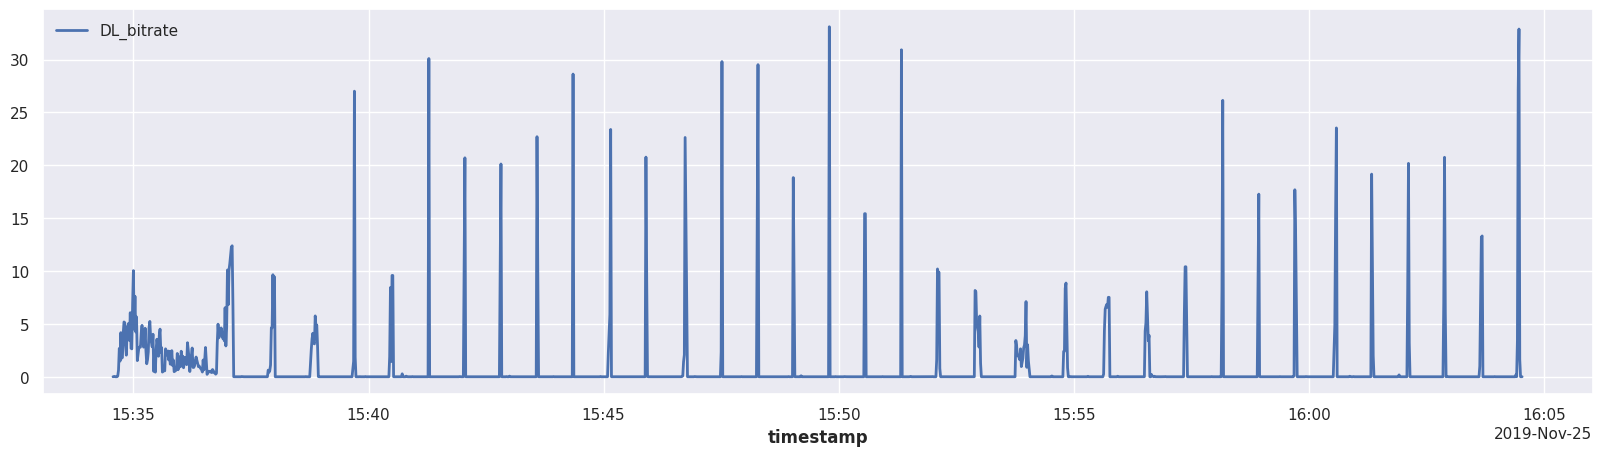

In [38]:
ts_targets[50].plot()

In [8]:
# Montando o dicionário com os caminhos dos arquivos
data_directory = os.path.join(os.pardir, "data", "reduced_metrics_datasets")

file_dict = {
    "static_down_metrics": os.path.join(data_directory, "static_down_metrics.pkl"),
    "static_strm_metrics": os.path.join(data_directory, "static_strm_metrics.pkl"),
    "driving_down_metrics": os.path.join(data_directory, "driving_down_metrics.pkl"),
    "driving_strm_metrics": os.path.join(data_directory, "driving_strm_metrics.pkl"),
}

# Carregando todos os DataFrames com um loop
dfs = []
for name, path in file_dict.items():
    with open(path, "rb") as f:
        df = pickle.load(f)
        df["source"] = name  # opcional: adicionar coluna de origem
        dfs.append(df)

# Concatenando todos os DataFrames
df_total = pd.concat(dfs, ignore_index=True)

In [9]:
df_total.head()

Uid                                          Timestamp  \
0  8d5tfppm  [2020-01-16 10:43:34, 2020-01-16 10:43:35, 202...   
1  DxU2NxRV  [2020-02-27 18:39:27, 2020-02-27 18:39:28, 202...   
2  ZBoZR6aN  [2020-02-14 13:21:26, 2020-02-14 13:21:27, 202...   
3  ec7EfKaB  [2020-02-13 13:57:29, 2020-02-13 13:57:30, 202...   
4  niiD4KgJ  [2019-12-16 13:40:04, 2019-12-16 13:40:05, 201...   

                                                RSRP  \
0  [-99.0, -100.0, -100.0, -101.0, -101.0, -100.0...   
1  [-101.0, -101.0, -101.0, -101.0, -101.0, -101....   
2  [-103.0, -103.0, -102.0, -103.0, -103.0, -104....   
3  [-101.0, -101.0, -102.0, -102.0, -102.0, -100....   
4  [-103.0, -102.0, -102.0, -104.0, -104.0, -104....   

                                                RSRQ  \
0  [-10.0, -10.0, -10.0, -9.0, -9.0, -9.0, -9.0, ...   
1  [-10.0, -10.0, -10.0, -10.0, -12.0, -12.0, -10...   
2  [-15.0, -15.0, -15.0, -16.0, -16.0, -16.0, -16...   
3  [-15.0, -12.0, -11.0, -11.0, -11.0, -12.0, -12...   
4  [-15.0, -16.0, -16.0, -14.0, -14.0, -14.0, -14...   

                                                 SNR  \
0  [9.0, 4.0, 4.0, 2.0, 2.0, 7.0, 7.0, 5.0, 5.0, ...   
1  [0.0, 0.0, 8.0, 8.0, 3.0, 3.0, 4.0, 4.0, 8.0, ...   
2  [5.0, 5.0, 1.0, -2.0, -2.0, 2.0, 2.0, -4.0, -4...   
3  [4.0, 1.0, 1.0, 1.0, 1.0, -4.0, -4.0, -5.0, -5...   
4  [1.0, 7.0, 7.0, -7.0, -7.0, -7.0, 1.0, -3.0, -...   

                                                 CQI  \
0  [14.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 14.0,...   
1  [12.0, 12.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12....   
2  [12.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 6.0, ...   
3  [11.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 10.0, 1...   
4  [15.0, 15.0, 15.0, 11.0, 11.0, 11.0, 11.0, 11....   

                                                RSSI  \
0  [-107.0, -107.0, -105.0, -105.0, -105.0, -105....   
1  [-103.0, -103.0, -103.0, -103.0, -103.0, -101....   
2  [-107.0, -107.0, -107.0, -105.0, -109.0, -105....   
3  [-103.0, -103.0, -103.0, -103.0, -103.0, -103....   
4  [-90.0, -90.0, -90.0, -88.0, -88.0, -88.0, -88...   

                                          DL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 14.199...   
1  [0.012, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.063, 0.002, 0.0, 0.002, 0.004, 20.568, 22.0...   
3  [0.169, 0.169, 0.166, 0.011, 0.011, 0.003, 4.5...   
4  [0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 27.631, 31.41...   

                                          UL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.219,...   
1  [0.003, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.02, 0.004, 0.0, 0.004, 0.006, 0.254, 0.057,...   
3  [0.129, 0.129, 0.232, 0.0, 0.0, 0.003, 0.111, ...   
4  [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138, 0.085, ...   

                                               Speed               source  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics

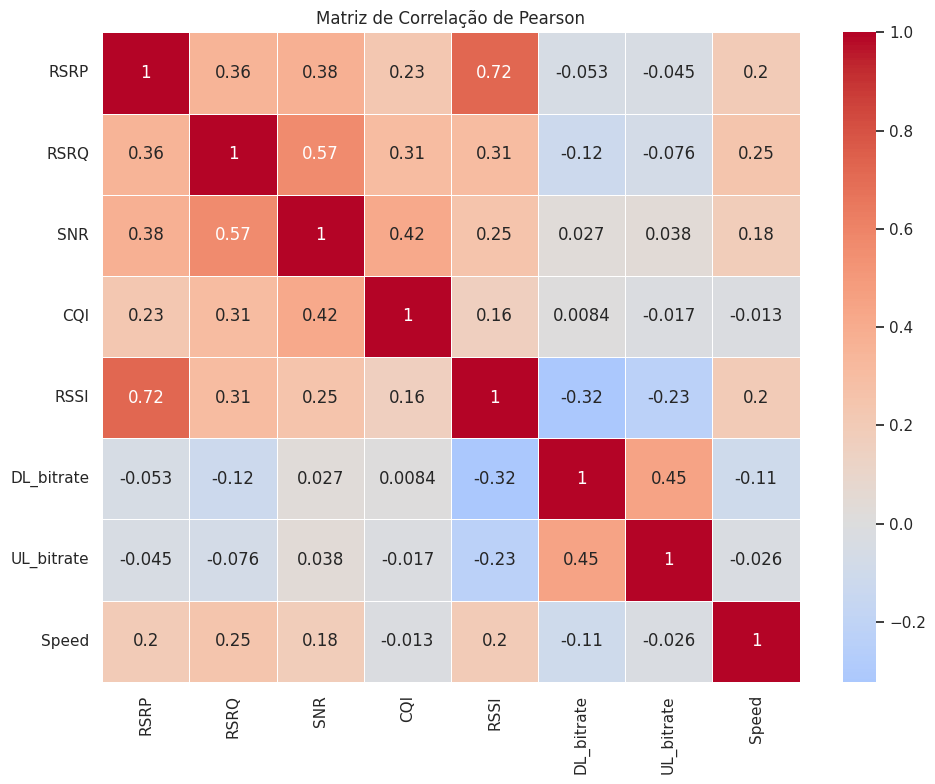

In [10]:
plot_pearson_correlation(df_total)

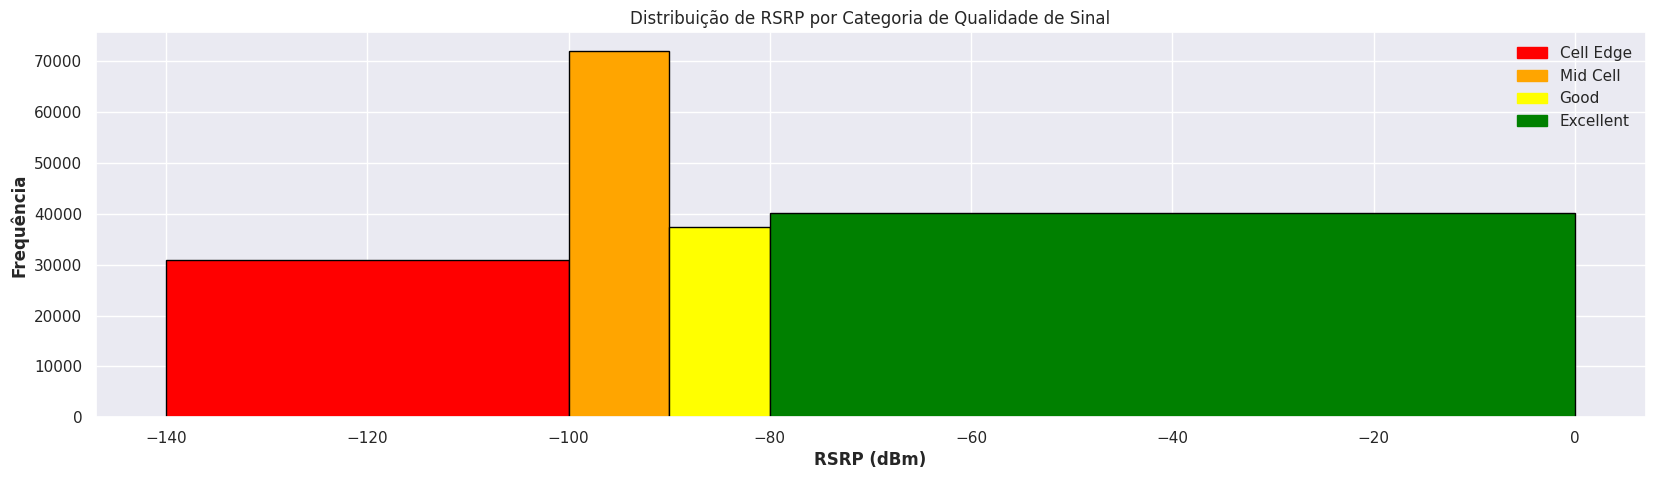

In [11]:
plot_rsrp_distribution(df_total)

### Static Downloading

In [12]:
df_total.query("source == 'static_down_metrics'")

Uid                                          Timestamp  \
0  8d5tfppm  [2020-01-16 10:43:34, 2020-01-16 10:43:35, 202...   
1  DxU2NxRV  [2020-02-27 18:39:27, 2020-02-27 18:39:28, 202...   
2  ZBoZR6aN  [2020-02-14 13:21:26, 2020-02-14 13:21:27, 202...   
3  ec7EfKaB  [2020-02-13 13:57:29, 2020-02-13 13:57:30, 202...   
4  niiD4KgJ  [2019-12-16 13:40:04, 2019-12-16 13:40:05, 201...   

                                                RSRP  \
0  [-99.0, -100.0, -100.0, -101.0, -101.0, -100.0...   
1  [-101.0, -101.0, -101.0, -101.0, -101.0, -101....   
2  [-103.0, -103.0, -102.0, -103.0, -103.0, -104....   
3  [-101.0, -101.0, -102.0, -102.0, -102.0, -100....   
4  [-103.0, -102.0, -102.0, -104.0, -104.0, -104....   

                                                RSRQ  \
0  [-10.0, -10.0, -10.0, -9.0, -9.0, -9.0, -9.0, ...   
1  [-10.0, -10.0, -10.0, -10.0, -12.0, -12.0, -10...   
2  [-15.0, -15.0, -15.0, -16.0, -16.0, -16.0, -16...   
3  [-15.0, -12.0, -11.0, -11.0, -11.0, -12.0, -12...   
4  [-15.0, -16.0, -16.0, -14.0, -14.0, -14.0, -14...   

                                                 SNR  \
0  [9.0, 4.0, 4.0, 2.0, 2.0, 7.0, 7.0, 5.0, 5.0, ...   
1  [0.0, 0.0, 8.0, 8.0, 3.0, 3.0, 4.0, 4.0, 8.0, ...   
2  [5.0, 5.0, 1.0, -2.0, -2.0, 2.0, 2.0, -4.0, -4...   
3  [4.0, 1.0, 1.0, 1.0, 1.0, -4.0, -4.0, -5.0, -5...   
4  [1.0, 7.0, 7.0, -7.0, -7.0, -7.0, 1.0, -3.0, -...   

                                                 CQI  \
0  [14.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 14.0,...   
1  [12.0, 12.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12....   
2  [12.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 6.0, ...   
3  [11.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 10.0, 1...   
4  [15.0, 15.0, 15.0, 11.0, 11.0, 11.0, 11.0, 11....   

                                                RSSI  \
0  [-107.0, -107.0, -105.0, -105.0, -105.0, -105....   
1  [-103.0, -103.0, -103.0, -103.0, -103.0, -101....   
2  [-107.0, -107.0, -107.0, -105.0, -109.0, -105....   
3  [-103.0, -103.0, -103.0, -103.0, -103.0, -103....   
4  [-90.0, -90.0, -90.0, -88.0, -88.0, -88.0, -88...   

                                          DL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 14.199...   
1  [0.012, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.063, 0.002, 0.0, 0.002, 0.004, 20.568, 22.0...   
3  [0.169, 0.169, 0.166, 0.011, 0.011, 0.003, 4.5...   
4  [0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 27.631, 31.41...   

                                          UL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.219,...   
1  [0.003, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.02, 0.004, 0.0, 0.004, 0.006, 0.254, 0.057,...   
3  [0.129, 0.129, 0.232, 0.0, 0.0, 0.003, 0.111, ...   
4  [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138, 0.085, ...   

                                               Speed               source  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics

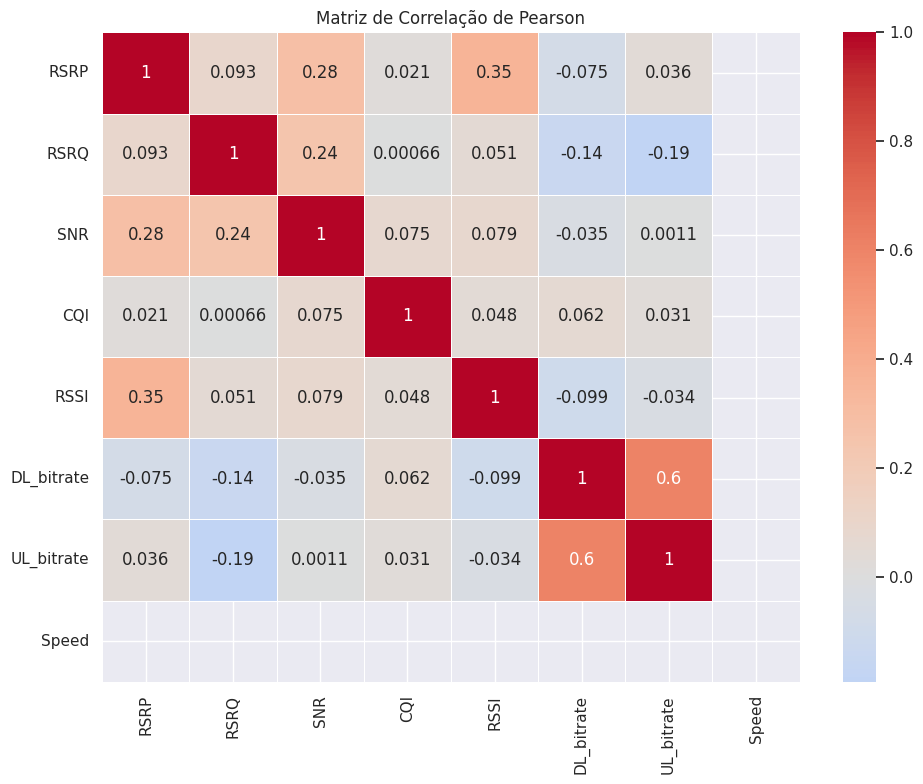

In [13]:
plot_pearson_correlation(df_total.query("source == 'static_down_metrics'"))

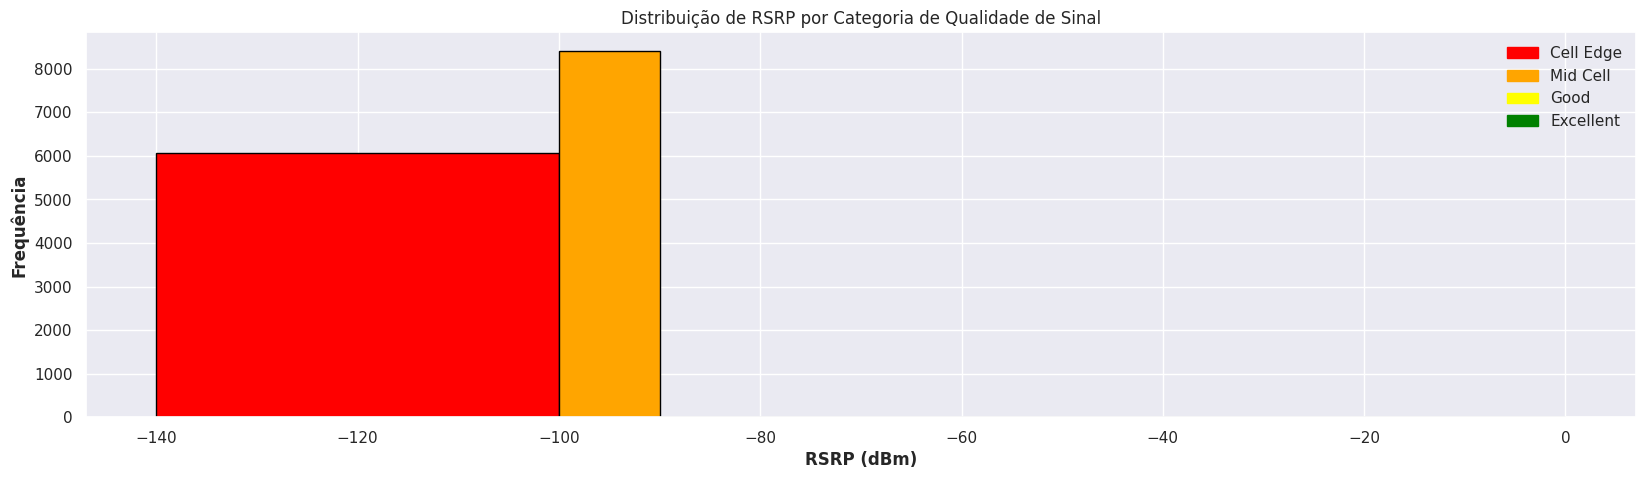

In [14]:
plot_rsrp_distribution(df_total.query("source == 'static_down_metrics'"))

In [15]:
df_total.query("source == 'static_down_metrics'")["DL_bitrate"]

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 14.199...
1    [0.012, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
2    [0.063, 0.002, 0.0, 0.002, 0.004, 20.568, 22.0...
3    [0.169, 0.169, 0.166, 0.011, 0.011, 0.003, 4.5...
4    [0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 27.631, 31.41...
Name: DL_bitrate, dtype: object

In [16]:
# Plot Raw Pandas
# plot_splits_by_uid(df)

### Static Streaming

In [17]:
df_total.query("source == 'static_strm_metrics'").head(5)

Uid                                          Timestamp  \
5  3N8r5bkv  [2020-01-06 09:55:14, 2020-01-06 09:55:15, 202...   
6  4op2yJzG  [2019-11-26 09:27:10, 2019-11-26 09:27:11, 201...   
7  9uyMy7Df  [2019-12-06 09:55:13, 2019-12-06 09:55:14, 201...   
8  9vdLBMon  [2020-01-03 10:54:39, 2020-01-03 10:54:40, 202...   
9  AcoaRdnv  [2019-12-19 15:00:47, 2019-12-19 15:00:48, 201...   

                                                RSRP  \
5  [-103.0, -102.0, -102.0, -102.0, -102.0, -101....   
6  [-91.0, -91.0, -91.0, -91.0, -92.0, -92.0, -91...   
7  [-104.0, -103.0, -102.0, -102.0, -104.0, -104....   
8  [-103.0, -102.0, -102.0, -99.0, -99.0, -101.0,...   
9  [-104.0, -104.0, -104.0, -104.0, -105.0, -105....   

                                                RSRQ  \
5  [-10.0, -10.0, -10.0, -9.0, -9.0, -11.0, -11.0...   
6  [-12.0, -12.0, -13.0, -13.0, -13.0, -13.0, -13...   
7  [-11.0, -10.0, -11.0, -11.0, -10.0, -10.0, -15...   
8  [-13.0, -12.0, -12.0, -11.0, -11.0, -10.0, -10...   
9  [-15.0, -15.0, -14.0, -14.0, -12.0, -12.0, -14...   

                                                 SNR  \
5  [2.0, 2.0, 2.0, -1.0, -1.0, 3.0, 3.0, 2.0, 2.0...   
6  [0.0, 0.0, -2.0, -2.0, 4.0, 4.0, 6.0, 6.0, 6.0...   
7  [4.0, 11.0, 2.0, 2.0, 5.0, 5.0, -2.0, -2.0, 2....   
8  [-2.0, 0.0, 0.0, 5.0, 5.0, 8.0, 8.0, 2.0, 2.0,...   
9  [-4.0, -4.0, -2.0, -2.0, 0.0, 0.0, 6.0, 6.0, 0...   

                                                 CQI  \
5  [12.0, 11.0, 11.0, 10.0, 10.0, 12.0, 12.0, 11....   
6  [9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 8.0, 8.0, 8.0,...   
7  [14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....   
8  [11.0, 8.0, 8.0, 13.0, 13.0, 13.0, 13.0, 10.0,...   
9  [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, ...   

                                                RSSI  \
5  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
6  [-70.0, -70.0, -70.0, -72.0, -72.0, -70.0, -72...   
7  [-86.0, -86.0, -86.0, -86.0, -86.0, -86.0, -86...   
8  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
9  [-87.0, -87.0, -87.0, -87.0, -87.0, -87.0, -87...   

                                          DL_bitrate  \
5  [0.0, 0.0, 0.0, 0.011, 0.993, 3.269, 2.415, 1....   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049, 0.695, 1...   
7  [0.0, 0.0, 0.045, 0.164, 0.505, 33.89, 0.489, ...   
8  [0.0, 0.004, 0.0, 0.0, 0.0, 4.824, 18.095, 6.8...   
9  [0.0, 0.0, 0.0, 0.0, 0.178, 0.0, 17.78, 2.282,...   

                                          UL_bitrate  \
5  [0.0, 0.0, 0.0, 0.0, 0.074, 0.37, 0.14, 0.064,...   
6  [0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.014, 0.339,...   
7  [0.0, 0.0, 0.013, 0.087, 0.061, 1.057, 0.018, ...   
8  [0.0, 0.005, 0.002, 0.0, 0.0, 0.22, 0.469, 0.2...   
9  [0.0, 0.0, 0.0, 0.0, 0.128, 0.0, 0.574, 0.069,...   

                                               Speed               source  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_strm_metrics  
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_strm_metrics  
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_strm_metrics  
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_strm_metrics  
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_strm_metrics

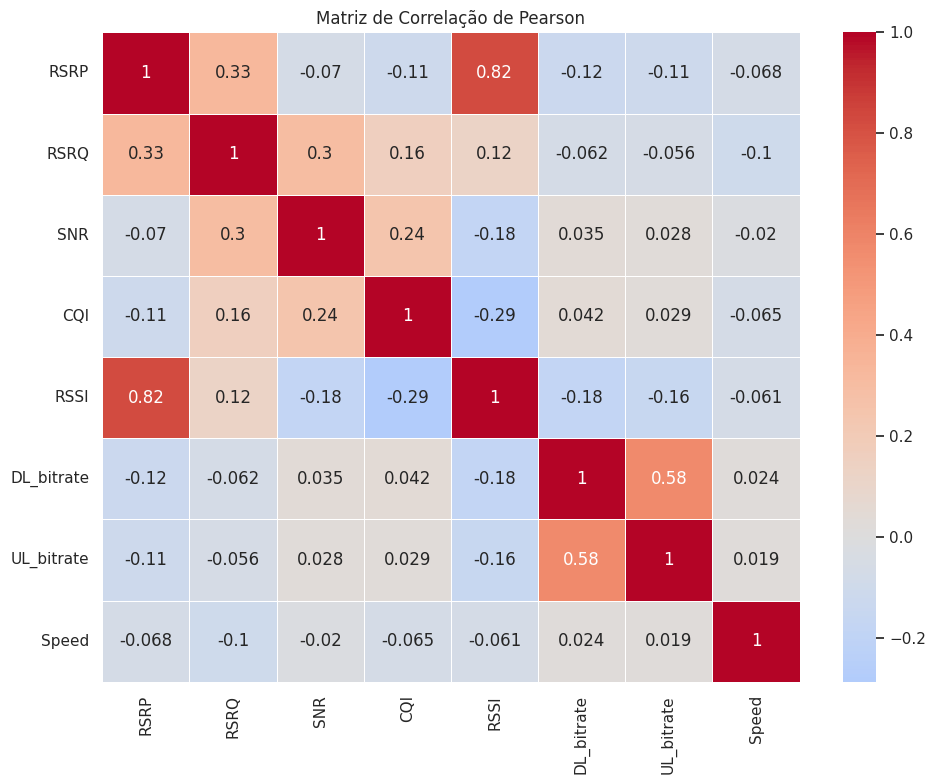

In [18]:
plot_pearson_correlation(df_total.query("source == 'static_strm_metrics'"))

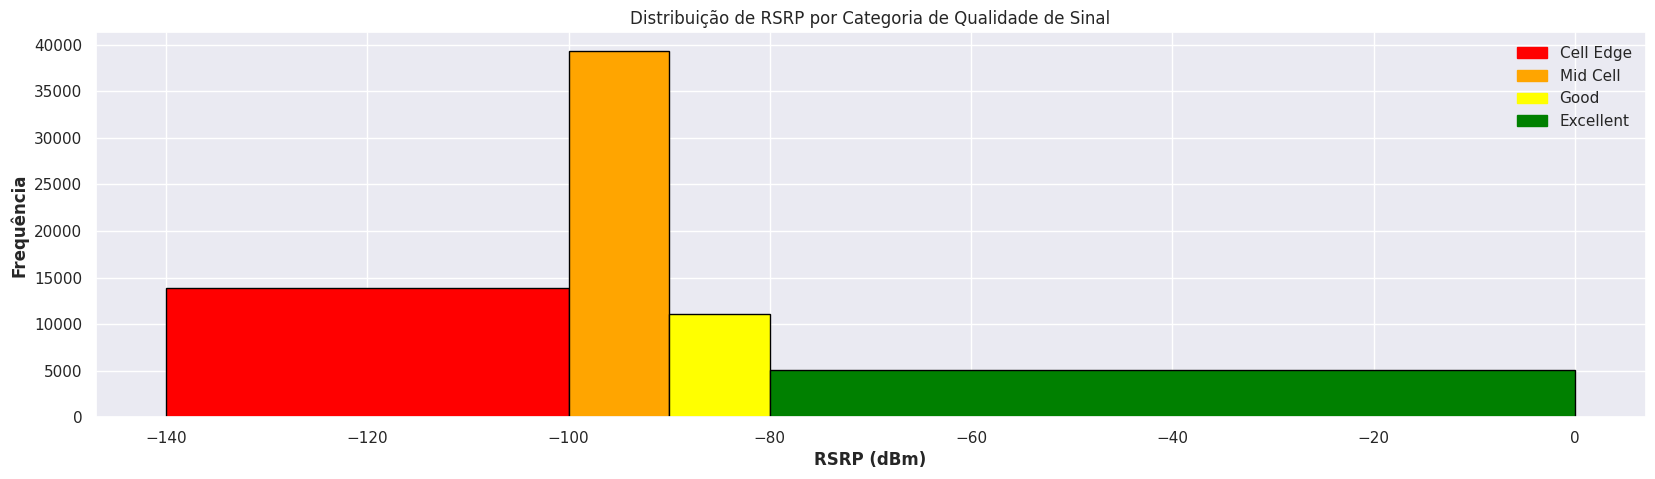

In [19]:
plot_rsrp_distribution(df_total.query("source == 'static_strm_metrics'"))

In [20]:
# plot_splits_by_uid(df)

### Driving Downloading

In [21]:
df_total.query("source == 'driving_down_metrics'").head(5)

Uid                                          Timestamp  \
23  3BLcyrV6  [2019-12-16 11:49:59, 2019-12-16 11:50:01, 201...   
24  BZKY9pPE  [2020-01-16 09:56:56, 2020-01-16 09:56:57, 202...   
25  CY79H6Z4  [2019-12-17 07:32:39, 2019-12-17 07:32:40, 201...   
26  DKmrkWJ8  [2020-01-16 07:26:43, 2020-01-16 07:26:44, 202...   
27  Nqfq64PY  [2020-02-13 13:03:24, 2020-02-13 13:03:25, 202...   

                                                 RSRP  \
23  [-91.0, -91.0, -91.0, -91.0, -91.0, -89.0, -89...   
24  [-99.0, -99.0, -99.0, -99.0, -99.0, -98.0, -84...   
25  [-103.0, -103.0, -103.0, -103.0, -103.0, -103....   
26  [-104.0, -104.0, -104.0, -104.0, -104.0, -102....   
27  [-100.0, -100.0, -99.0, -99.0, -98.0, -98.0, -...   

                                                 RSRQ  \
23  [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....   
24  [-10.0, -10.0, -9.0, -9.0, -9.0, -10.0, -10.0,...   
25  [-11.0, -10.0, -11.0, -11.0, -13.0, -13.0, -12...   
26  [-11.0, -11.0, -11.0, -12.0, -12.0, -13.0, -13...   
27  [-13.0, -13.0, -10.0, -10.0, -11.0, -11.0, -11...   

                                                  SNR  \
23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
24  [4.0, 4.0, 3.0, 3.0, 3.0, -1.0, 13.0, 13.0, 11...   
25  [0.0, 7.0, 8.0, 8.0, 10.0, 10.0, 13.0, 13.0, 9...   
26  [7.0, 0.0, 0.0, 4.0, 4.0, 8.0, 8.0, 8.0, 9.0, ...   
27  [1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 6.0, ...   

                                                  CQI  \
23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
24  [11.0, 11.0, 13.0, 13.0, 13.0, 9.0, 11.0, 11.0...   
25  [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....   
26  [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 11.0,...   
27  [13.0, 13.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0...   

                                                 RSSI  \
23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
24  [-101.0, -95.0, -99.0, -95.0, -99.0, -101.0, -...   
25  [-87.0, -87.0, -87.0, -87.0, -87.0, -87.0, -87...   
26  [-105.0, -105.0, -105.0, -105.0, -105.0, -103....   
27  [-103.0, -103.0, -103.0, -103.0, -101.0, -101....   

                                           DL_bitrate  \
23  [0.022, 0.072, 0.106, 0.01, 0.006, 1.034, 1.99...   
24  [0.129, 0.129, 0.0, 0.043, 0.043, 18.586, 18.7...   
25  [0.199, 0.001, 0.001, 0.035, 0.0, 0.0, 16.549,...   
26  [0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001,...   
27  [0.024, 0.003, 0.0, 0.0, 0.0, 0.018, 2.013, 14...   

                                           UL_bitrate  \
23  [0.036, 0.021, 0.02, 0.005, 0.003, 0.04, 0.046...   
24  [0.027, 0.027, 0.0, 0.017, 0.017, 0.203, 0.097...   
25  [0.051, 0.0, 0.0, 0.011, 0.0, 0.0, 0.214, 0.06...   
26  [0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001,...   
27  [0.003, 0.005, 0.0, 0.0, 0.0, 0.018, 0.068, 0....   

                                                Speed                source  
23  [0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...  driving_down_metrics  
24  [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  driving_down_metrics  
25  [0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...  driving_down_metrics  
26  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  driving_down_metrics  
27  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  driving_down_metrics

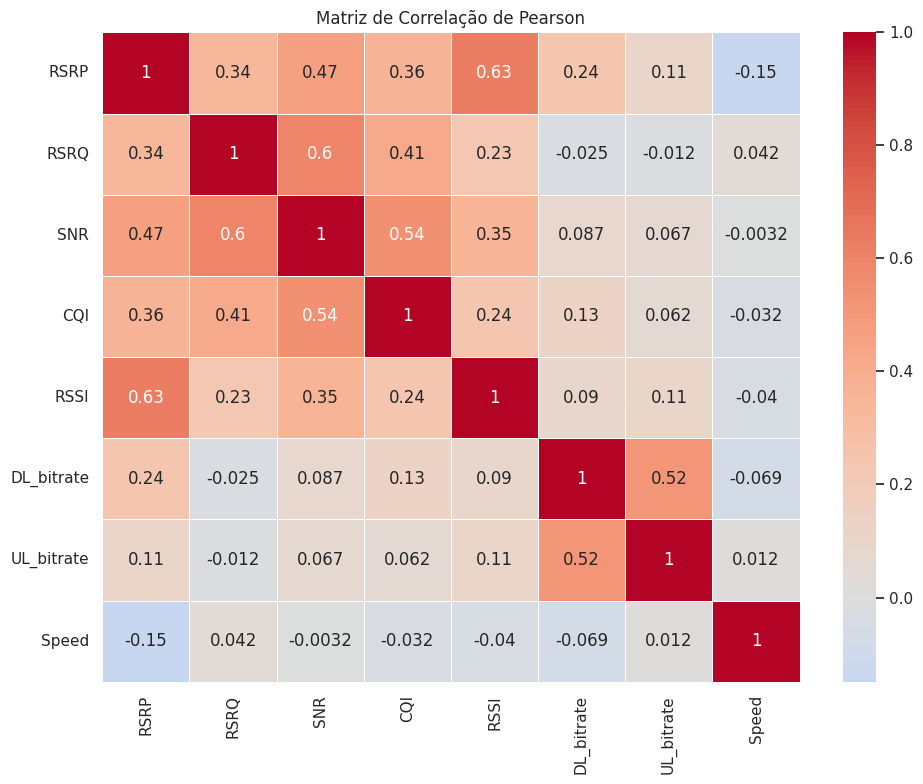

In [22]:
plot_pearson_correlation(df_total.query("source == 'driving_down_metrics'"))

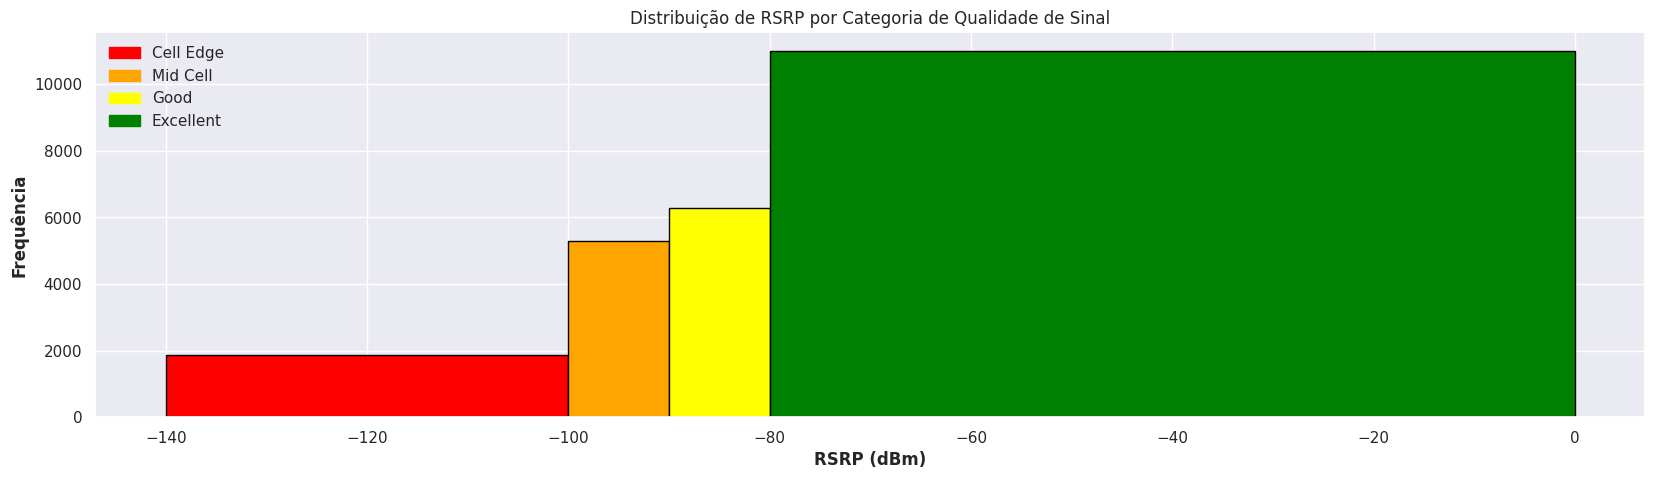

In [23]:
plot_rsrp_distribution(df_total.query("source == 'driving_down_metrics'"))

In [24]:
# plot_splits_by_uid(df)

### Driving Streaming

In [25]:
df_total.query("source == 'driving_strm_metrics'").head(5)

Uid                                          Timestamp  \
39  3YqrpMRw  [2019-11-28 12:05:30, 2019-11-28 12:05:31, 201...   
40  5Ro8F8gQ  [2019-12-02 09:39:35, 2019-12-02 09:39:36, 201...   
41  7LGTYG3i  [2019-11-28 10:14:25, 2019-11-28 10:14:26, 201...   
42  7barxnf5  [2019-11-26 09:53:40, 2019-11-26 09:53:41, 201...   
43  7gt2Bnv4  [2019-11-22 07:30:04, 2019-11-22 07:30:05, 201...   

                                                 RSRP  \
39  [-100.0, -100.0, -100.0, -101.0, -101.0, -100....   
40  [-73.0, -73.0, -73.0, -73.0, -73.0, -73.0, -73...   
41  [-89.0, -89.0, -90.0, -90.0, -89.0, -89.0, -89...   
42  [-88.0, -88.0, -93.0, -93.0, -93.0, -93.0, -91...   
43  [-102.0, -102.0, -102.0, -102.0, -102.0, -102....   

                                                 RSRQ  \
39  [-10.0, -10.0, -10.0, -11.0, -11.0, -11.0, -11...   
40  [-7.0, -8.0, -9.0, -9.0, -9.0, -10.0, -11.0, -...   
41  [-10.0, -10.0, -9.0, -9.0, -15.0, -15.0, -11.0...   
42  [-18.0, -18.0, -18.0, -18.0, -17.0, -17.0, -18...   
43  [-14.0, -11.0, -11.0, -12.0, -12.0, -11.0, -11...   

                                                  SNR  \
39  [1.0, -1.0, -1.0, -7.0, -7.0, 7.0, 7.0, 4.0, 4...   
40  [25.0, 22.0, 25.0, 25.0, 25.0, 23.0, 21.0, 21....   
41  [-3.0, -3.0, 7.0, 7.0, 5.0, 5.0, 6.0, 6.0, 5.0...   
42  [-9.0, -9.0, -7.0, -7.0, -1.0, -1.0, -6.0, -6....   
43  [-5.0, -6.0, -6.0, 4.0, 4.0, -6.0, -6.0, 4.0, ...   

                                                  CQI  \
39  [11.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....   
40  [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12....   
41  [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....   
42  [9.0, 9.0, 6.0, 11.0, 9.0, 9.0, 9.0, 9.0, 9.0,...   
43  [10.0, 10.0, 10.0, 10.0, 12.0, 12.0, 11.0, 10....   

                                                 RSSI  \
39  [-84.0, nan, nan, nan, nan, nan, nan, nan, nan...   
40  [-57.0, -57.0, -57.0, -57.0, -57.0, -57.0, -57...   
41  [-70.0, -70.0, -70.0, -70.0, -70.0, -70.0, -70...   
42  [-55.0, -55.0, -54.0, -58.0, -60.0, -60.0, -60...   
43  [-81.0, -81.0, -81.0, -81.0, -85.0, -85.0, -83...   

                                           DL_bitrate  \
39  [0.027, 0.0, 0.035, 0.867, 2.198, 0.0, 1.824, ...   
40  [0.17, 0.0, 0.0, 5.546, 5.546, 1.913, 1.192, 5...   
41  [0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0...   
42  [0.008, 0.008, 0.01, 0.003, 0.011, 0.166, 0.58...   
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.104, 0.011, 0.0, 0...   

                                           UL_bitrate  \
39  [0.008, 0.0, 0.01, 0.187, 0.042, 0.009, 0.186,...   
40  [0.041, 0.0, 0.001, 0.301, 0.301, 0.091, 0.157...   
41  [0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0...   
42  [0.0, 0.0, 0.0, 0.0, 0.001, 0.059, 0.317, 0.00...   
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.019, 0.001, 0.001,...   

                                                Speed                source  
39  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  driving_strm_metrics  
40  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  driving_strm_metrics  
41  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  driving_strm_metrics  
42  [12.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0,...  driving_strm_metrics  
43  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  driving_strm_metrics

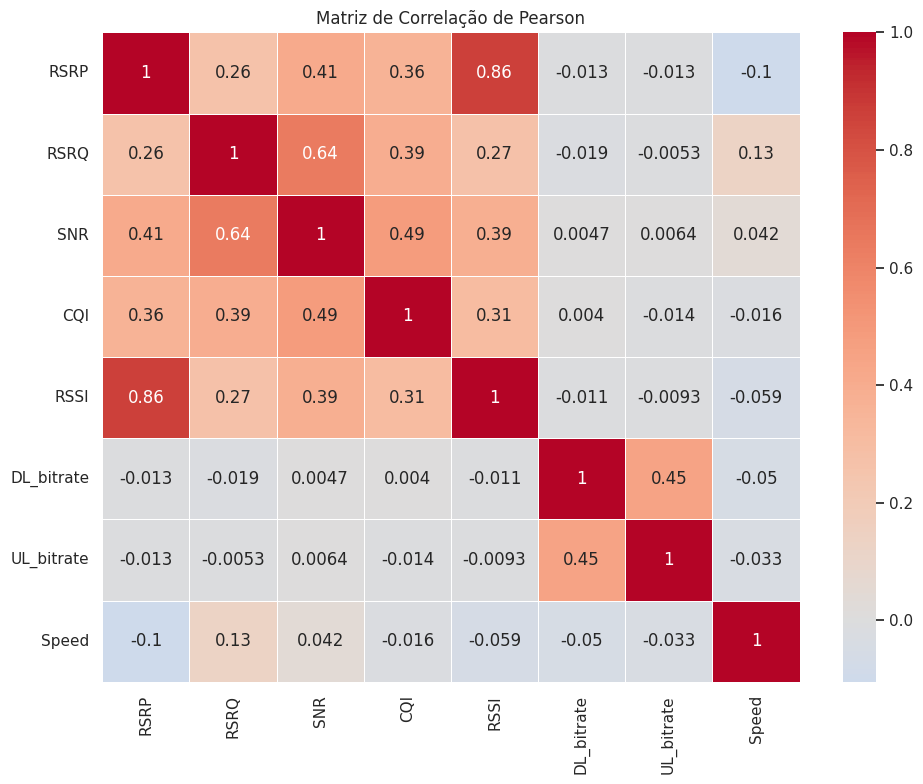

In [26]:
plot_pearson_correlation(df_total.query("source == 'driving_strm_metrics'"))

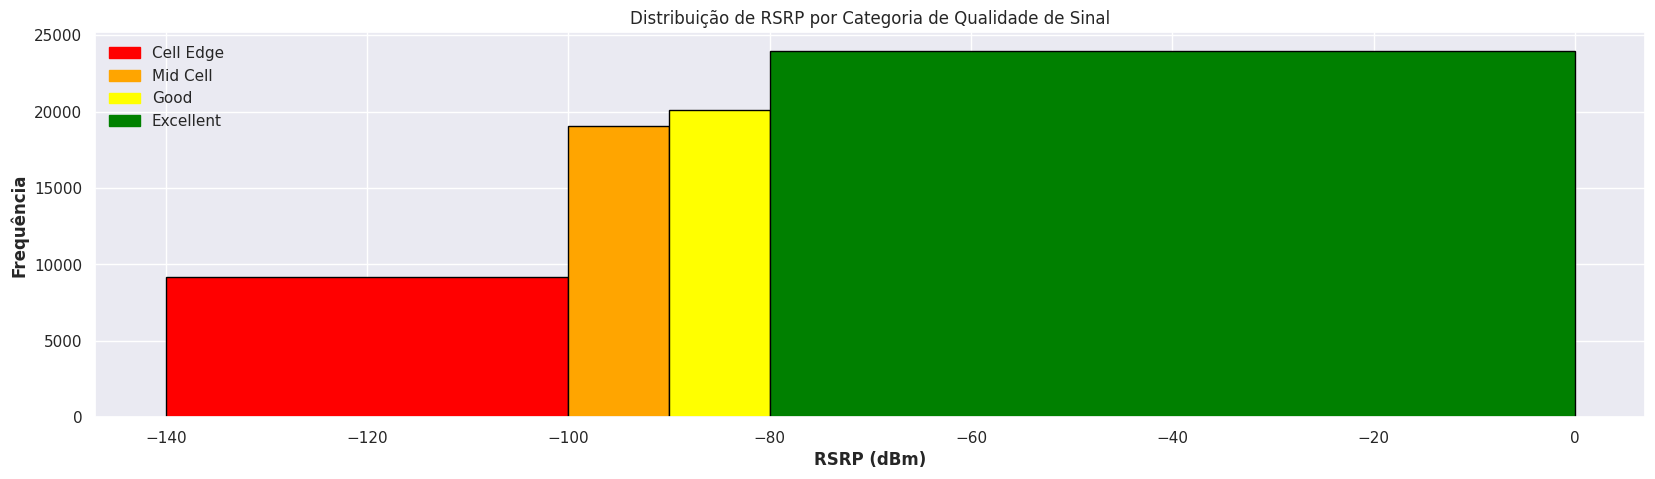

In [27]:
plot_rsrp_distribution(df_total.query("source == 'driving_strm_metrics'"))

In [28]:
# plot_splits_by_uid(df)

# Analisando o comportamento das séries

## Augmented Dickey-Fuller Test

In [29]:
# from pipeline_5g.utils.timeseries import split_and_impute_timeseries_on_gaps

In [30]:
df_total.head()

Uid                                          Timestamp  \
0  8d5tfppm  [2020-01-16 10:43:34, 2020-01-16 10:43:35, 202...   
1  DxU2NxRV  [2020-02-27 18:39:27, 2020-02-27 18:39:28, 202...   
2  ZBoZR6aN  [2020-02-14 13:21:26, 2020-02-14 13:21:27, 202...   
3  ec7EfKaB  [2020-02-13 13:57:29, 2020-02-13 13:57:30, 202...   
4  niiD4KgJ  [2019-12-16 13:40:04, 2019-12-16 13:40:05, 201...   

                                                RSRP  \
0  [-99.0, -100.0, -100.0, -101.0, -101.0, -100.0...   
1  [-101.0, -101.0, -101.0, -101.0, -101.0, -101....   
2  [-103.0, -103.0, -102.0, -103.0, -103.0, -104....   
3  [-101.0, -101.0, -102.0, -102.0, -102.0, -100....   
4  [-103.0, -102.0, -102.0, -104.0, -104.0, -104....   

                                                RSRQ  \
0  [-10.0, -10.0, -10.0, -9.0, -9.0, -9.0, -9.0, ...   
1  [-10.0, -10.0, -10.0, -10.0, -12.0, -12.0, -10...   
2  [-15.0, -15.0, -15.0, -16.0, -16.0, -16.0, -16...   
3  [-15.0, -12.0, -11.0, -11.0, -11.0, -12.0, -12...   
4  [-15.0, -16.0, -16.0, -14.0, -14.0, -14.0, -14...   

                                                 SNR  \
0  [9.0, 4.0, 4.0, 2.0, 2.0, 7.0, 7.0, 5.0, 5.0, ...   
1  [0.0, 0.0, 8.0, 8.0, 3.0, 3.0, 4.0, 4.0, 8.0, ...   
2  [5.0, 5.0, 1.0, -2.0, -2.0, 2.0, 2.0, -4.0, -4...   
3  [4.0, 1.0, 1.0, 1.0, 1.0, -4.0, -4.0, -5.0, -5...   
4  [1.0, 7.0, 7.0, -7.0, -7.0, -7.0, 1.0, -3.0, -...   

                                                 CQI  \
0  [14.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 14.0,...   
1  [12.0, 12.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12....   
2  [12.0, 12.0, 12.0, 10.0, 10.0, 9.0, 9.0, 6.0, ...   
3  [11.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 10.0, 1...   
4  [15.0, 15.0, 15.0, 11.0, 11.0, 11.0, 11.0, 11....   

                                                RSSI  \
0  [-107.0, -107.0, -105.0, -105.0, -105.0, -105....   
1  [-103.0, -103.0, -103.0, -103.0, -103.0, -101....   
2  [-107.0, -107.0, -107.0, -105.0, -109.0, -105....   
3  [-103.0, -103.0, -103.0, -103.0, -103.0, -103....   
4  [-90.0, -90.0, -90.0, -88.0, -88.0, -88.0, -88...   

                                          DL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 14.199...   
1  [0.012, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.063, 0.002, 0.0, 0.002, 0.004, 20.568, 22.0...   
3  [0.169, 0.169, 0.166, 0.011, 0.011, 0.003, 4.5...   
4  [0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 27.631, 31.41...   

                                          UL_bitrate  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.219,...   
1  [0.003, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
2  [0.02, 0.004, 0.0, 0.004, 0.006, 0.254, 0.057,...   
3  [0.129, 0.129, 0.232, 0.0, 0.0, 0.003, 0.111, ...   
4  [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138, 0.085, ...   

                                               Speed               source  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  static_down_metrics

In [31]:
from pipeline_5g.utils import create_target_timeseries, create_covariates_timeseries, impute_timeseries_missing_values

In [32]:
all_targets = []
all_past_covariates = []
target = "DL_bitrate"
covariates = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI", "Speed"]
for idx, row in df_total.iterrows():
    target_ts = create_target_timeseries(row, target, timestamp_col="Timestamp")
    past_cov_ts = create_covariates_timeseries(row, covariates, timestamp_col="Timestamp")
    
    # # Fill nan
    # target_ts = impute_timeseries_missing_values(target_ts)
    # past_cov_ts = impute_timeseries_missing_values(past_cov_ts)

    break

    # all_targets.append(target_ts)
    # all_past_covariates.append(past_cov_ts)

<Axes: xlabel='timestamp'>

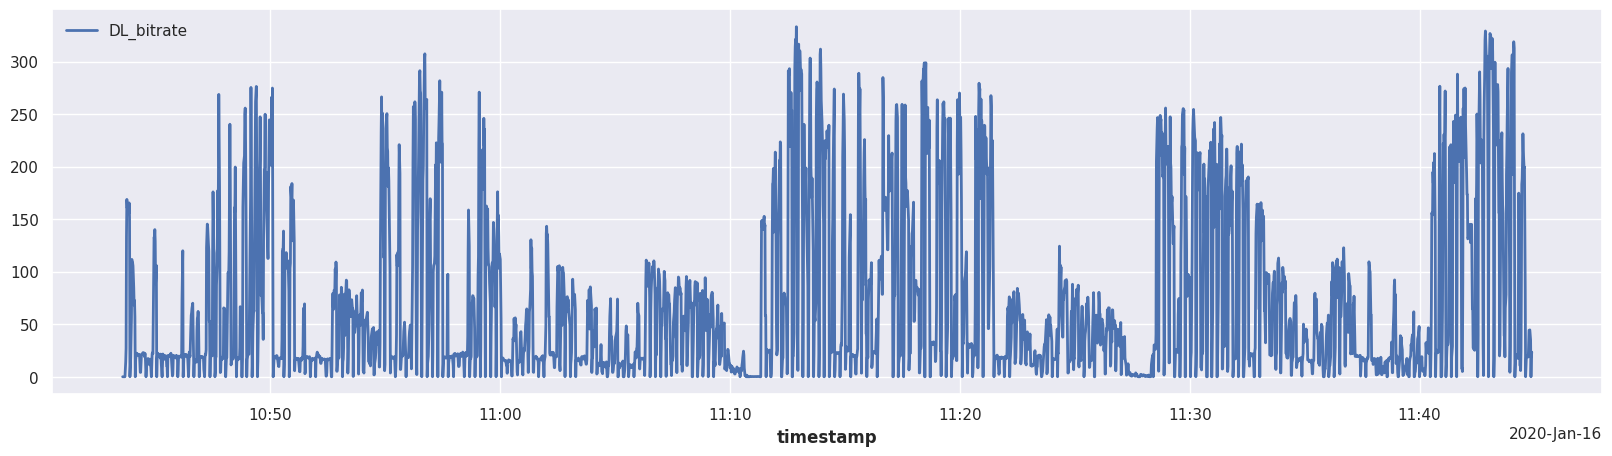

In [33]:
impute_timeseries_missing_values(target_ts).plot()

<Axes: xlabel='timestamp'>

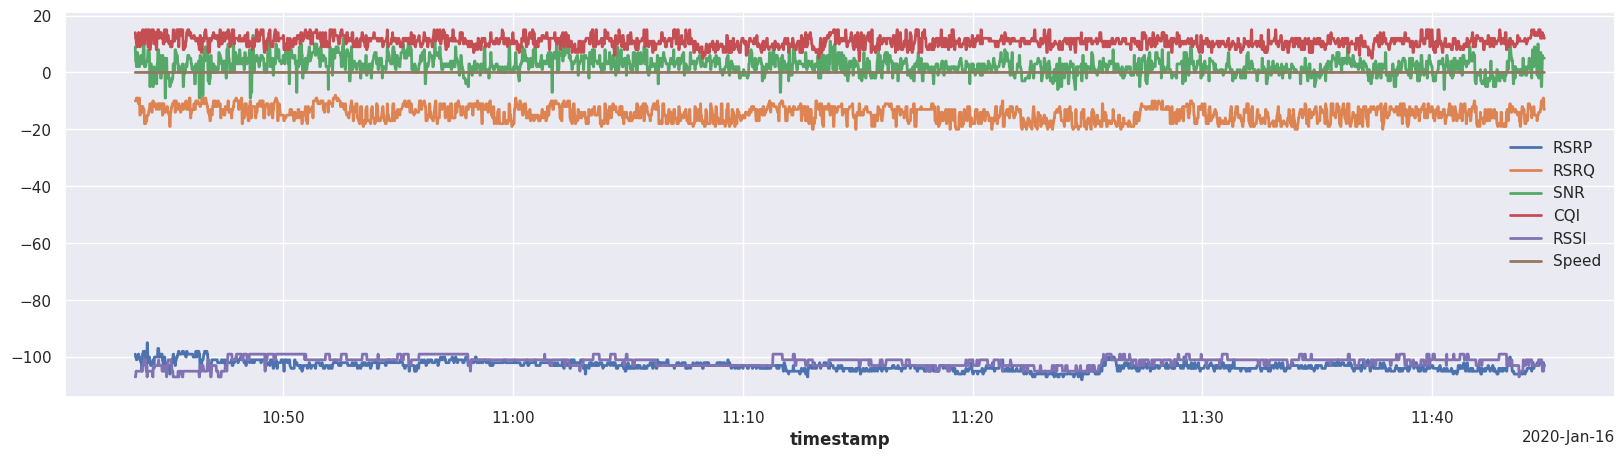

In [42]:
impute_timeseries_missing_values(past_cov_ts).plot()

<Axes: xlabel='timestamp'>

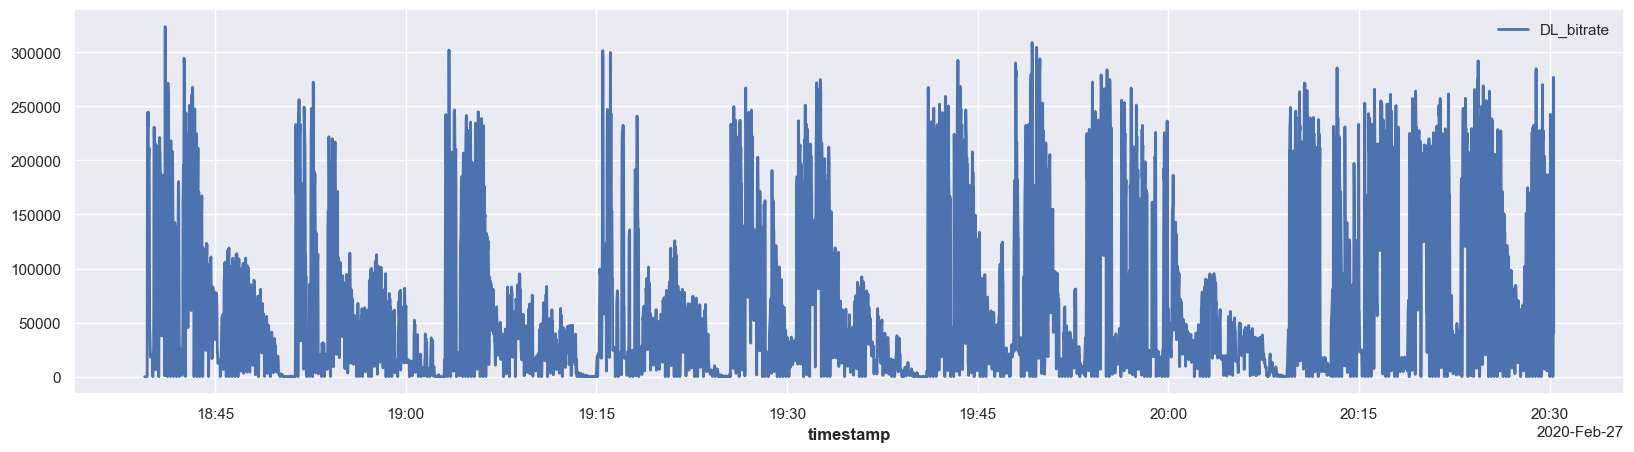

In [68]:
all_targets[3].plot()

<Axes: xlabel='timestamp'>

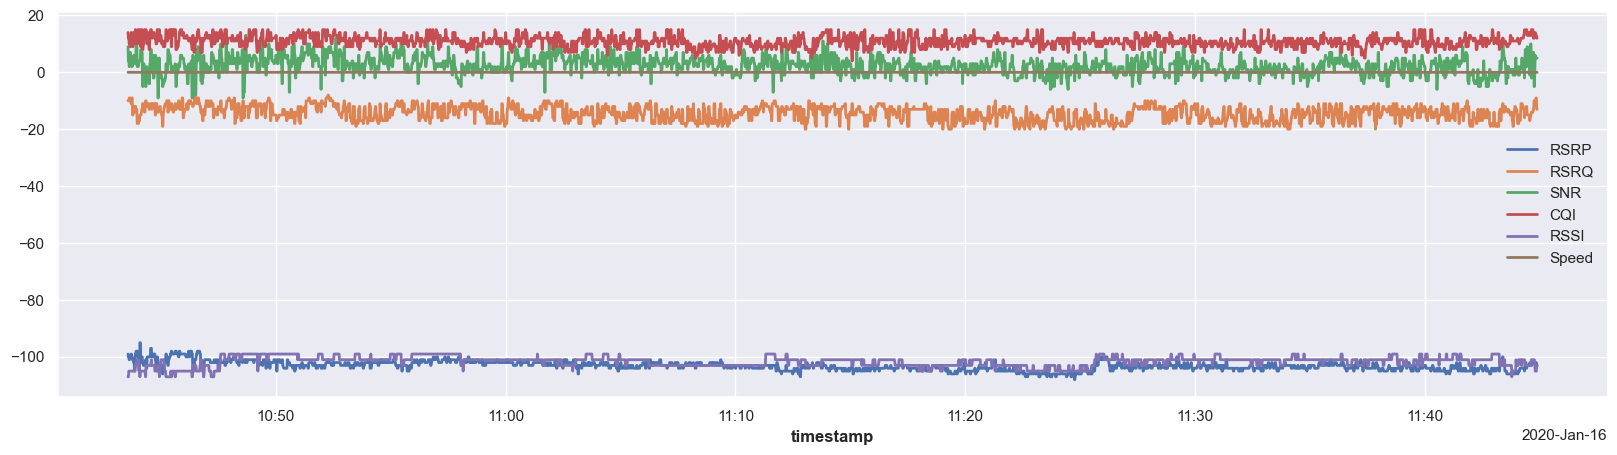

In [69]:
all_past_covariates[2].plot()

In [70]:
# from darts.utils.statistics import plot_acf, plot_pacf
# import matplotlib.pyplot as plt

# # A função irá plotar para no máximo 'max_series' (default 10)
# plot_acf(all_targets, m=None, max_lag=24, alpha=0.05)
# plt.suptitle("ACF para um subconjunto de Séries Alvo")
# plt.show()

# plot_pacf(all_targets, m=None, max_lag=24, alpha=0.05)
# plt.suptitle("PACF para um subconjunto de Séries Alvo")
# plt.show()

In [71]:
# processed_series = []
# for idx, row in df_total.iterrows():
#     subseries = split_and_impute_timeseries_on_gaps(
#         row, "DL_bitrate"
#     )
#     if subseries:
#         processed_series.extend(subseries)

<Axes: xlabel='timestamp'>

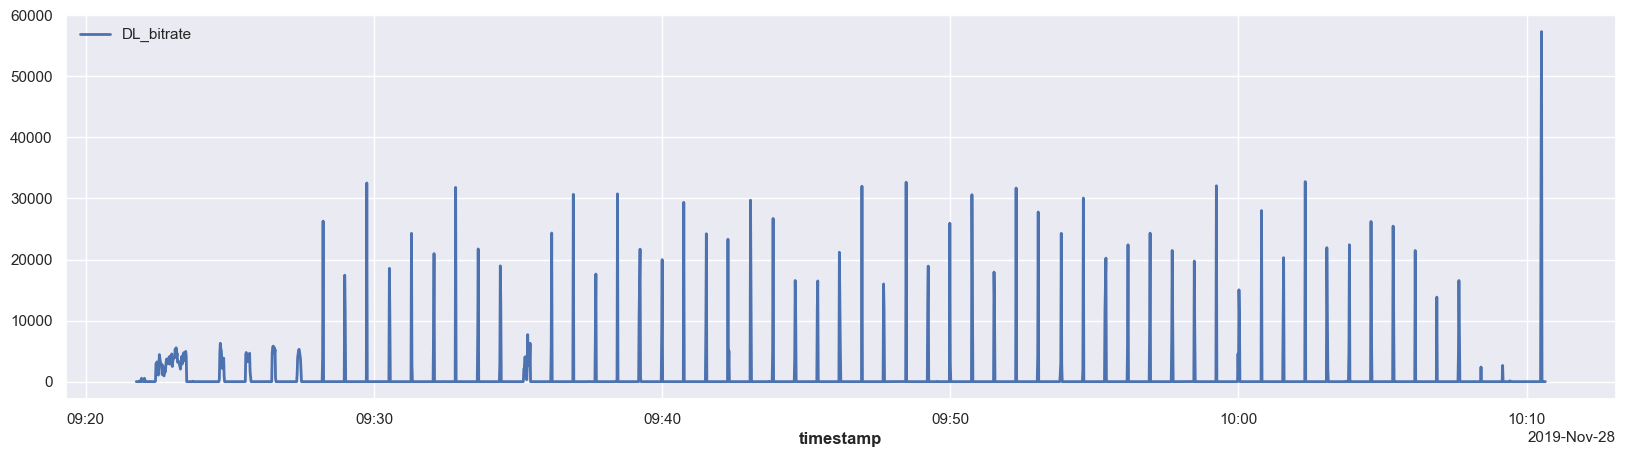

In [72]:
# Plot Timeseries processed
all_targets[7].plot()

In [73]:
for idx, serie in enumerate(all_targets):
    print(f"--- Series {idx} ---")
    adf_test(serie.pd_dataframe())

--- Series 0 ---
Augmented Dickey-Fuller Test: 
ADF test statistic     -8.025701e+00
p-value                 2.020190e-12
# lags used             2.800000e+01
# observations          3.469000e+03
critical value (1%)    -3.432236e+00
critical value (5%)    -2.862374e+00
critical value (10%)   -2.567214e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--- Series 1 ---
Augmented Dickey-Fuller Test: 
ADF test statistic     -6.929508e+00
p-value                 1.093285e-09
# lags used             1.500000e+01
# observations          1.087000e+03
critical value (1%)    -3.436380e+00
critical value (5%)    -2.864203e+00
critical value (10%)   -2.568188e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--- Series 2 ---
Augmented Dickey-Fuller Test: 
ADF test statistic     -5.956258e+00
p-value                 2.089818e-07
# lags used             3.000000e+01
# obs

## Autocorrelation

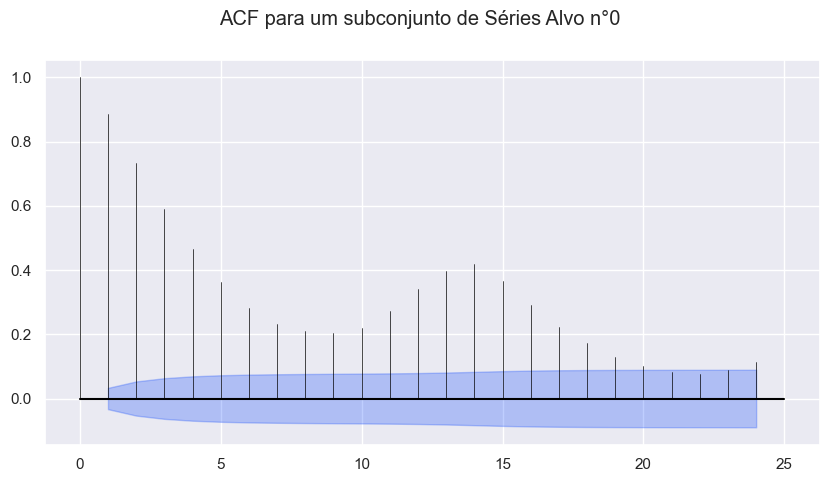

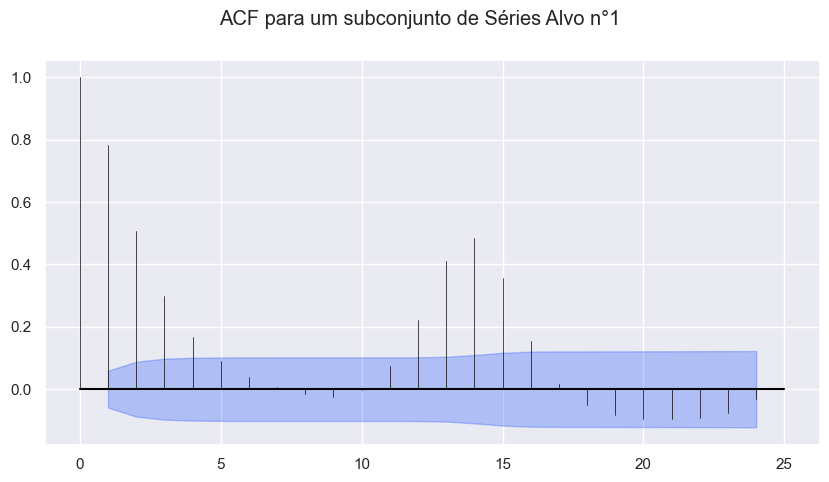

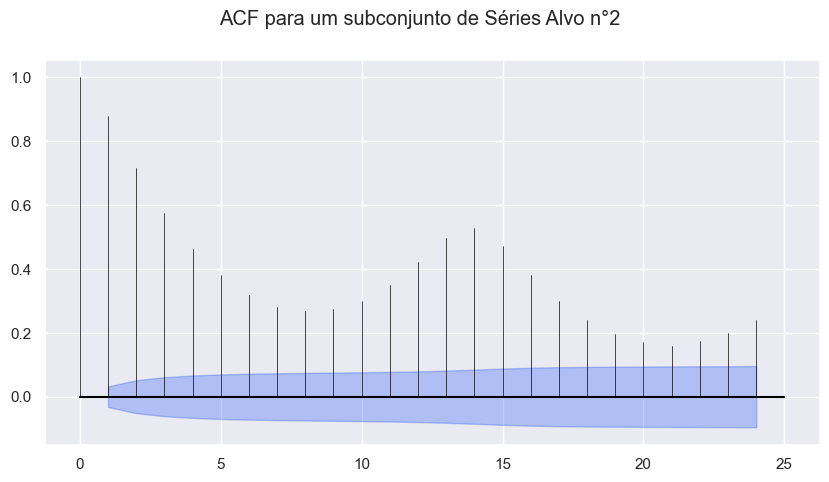

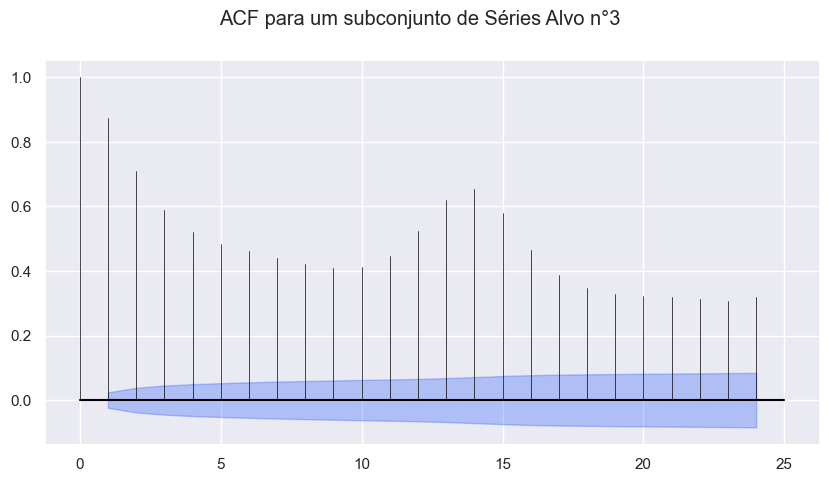

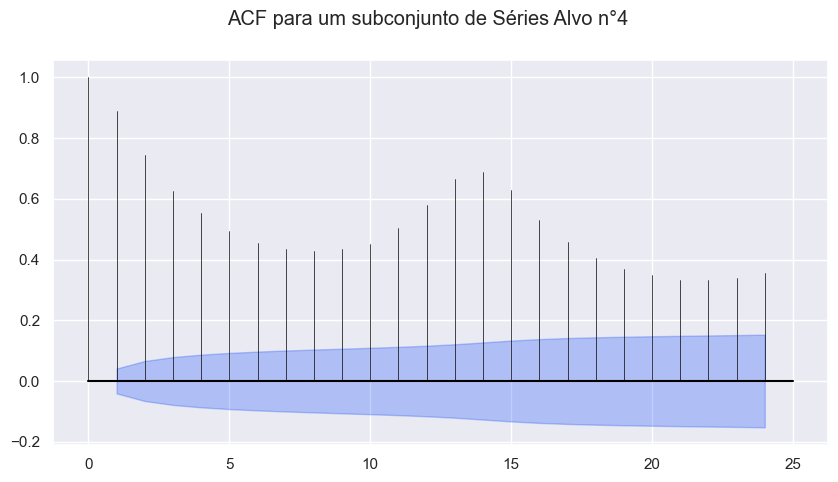

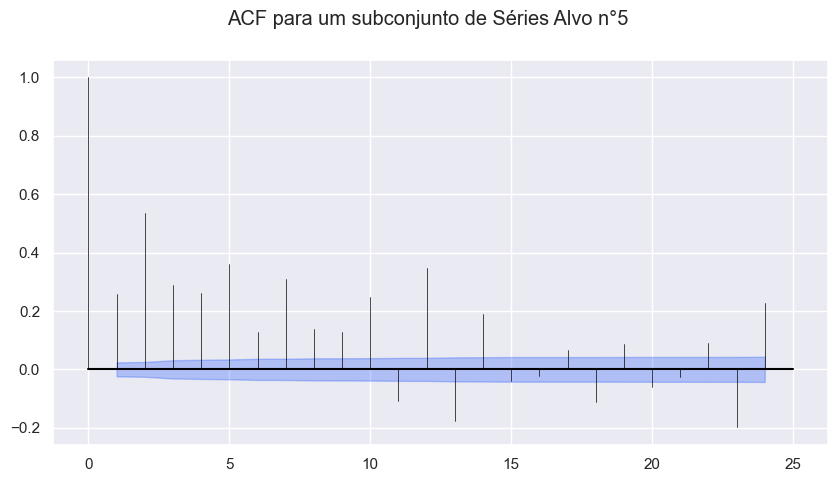

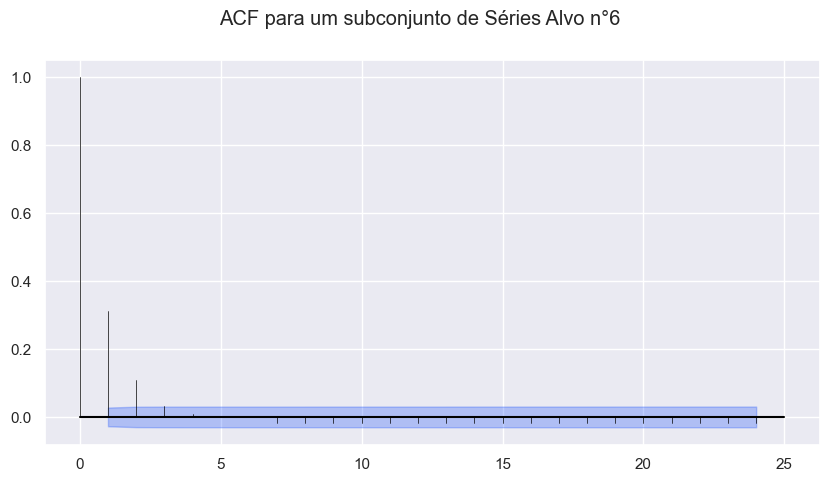

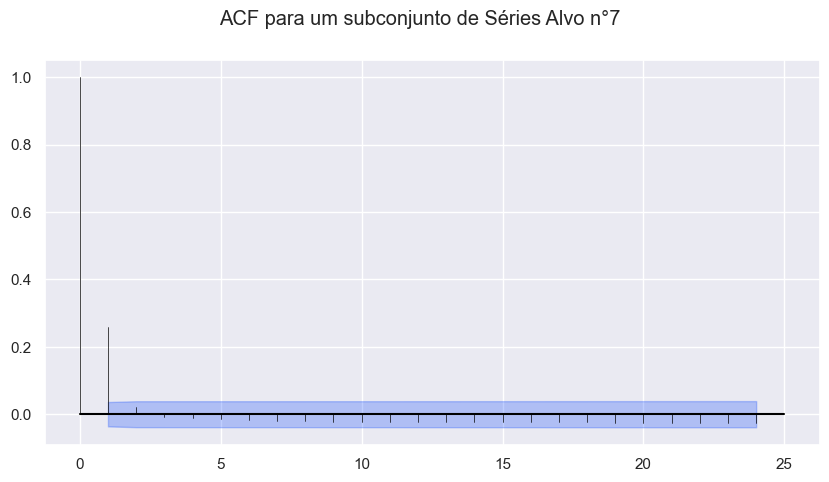

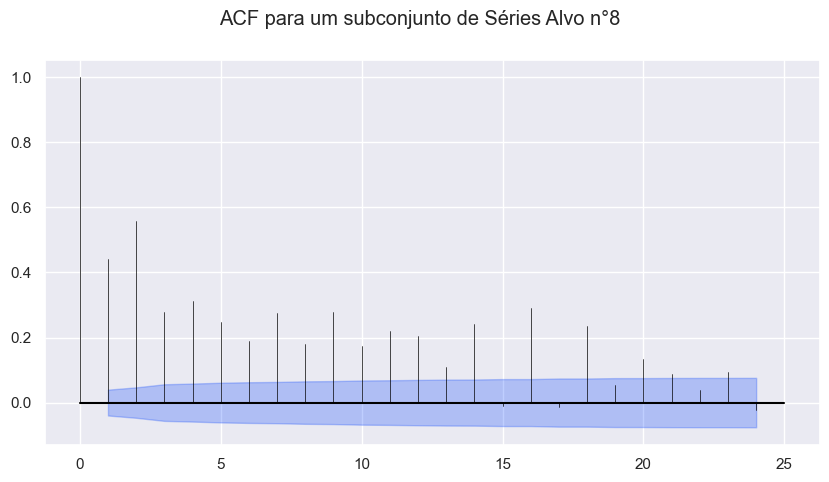

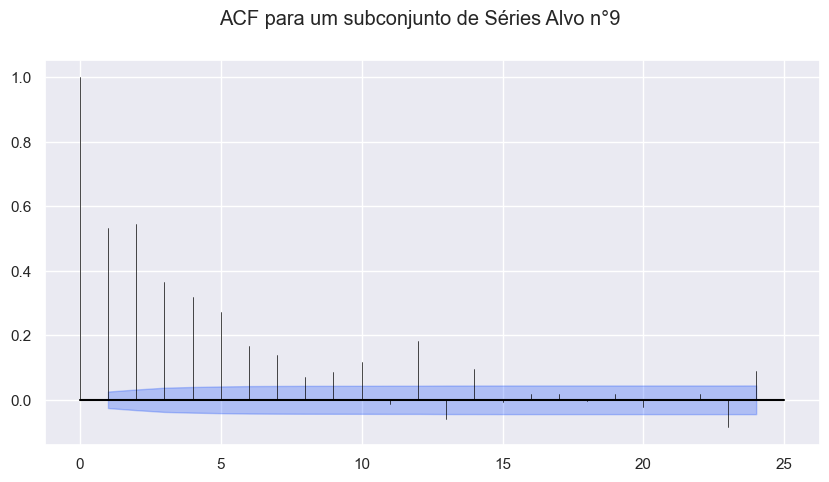

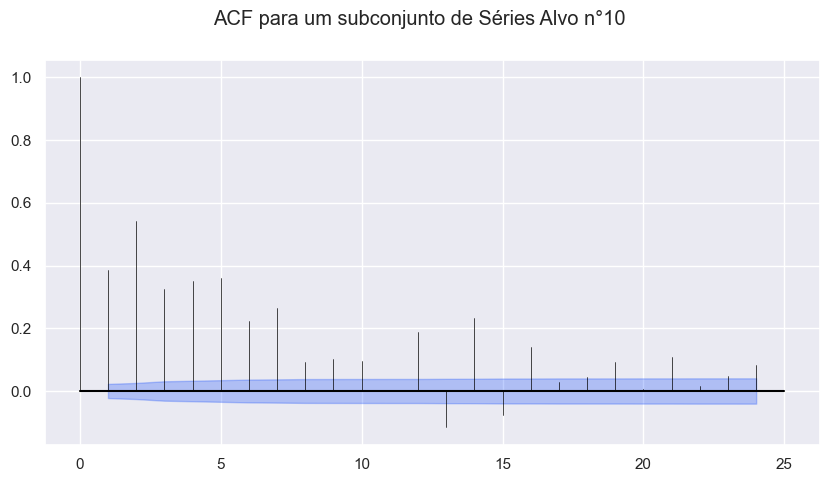

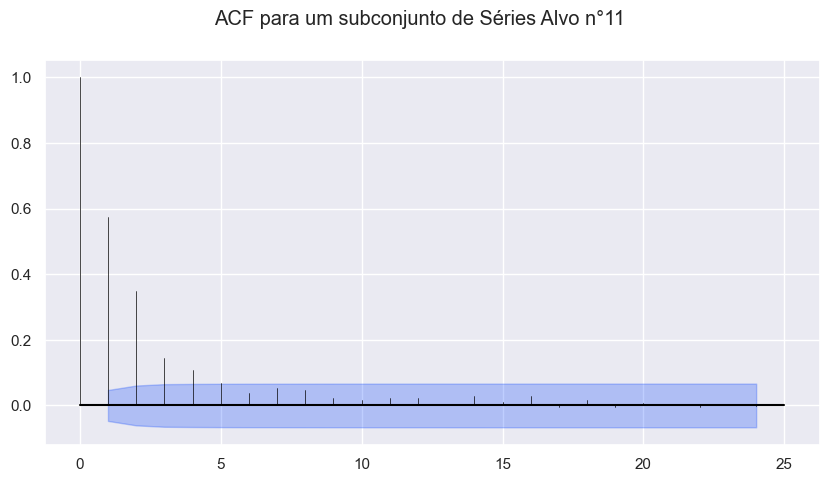

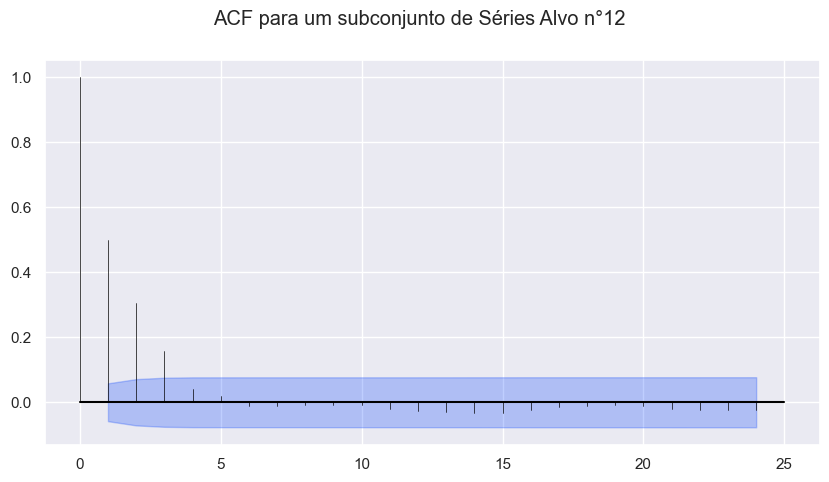

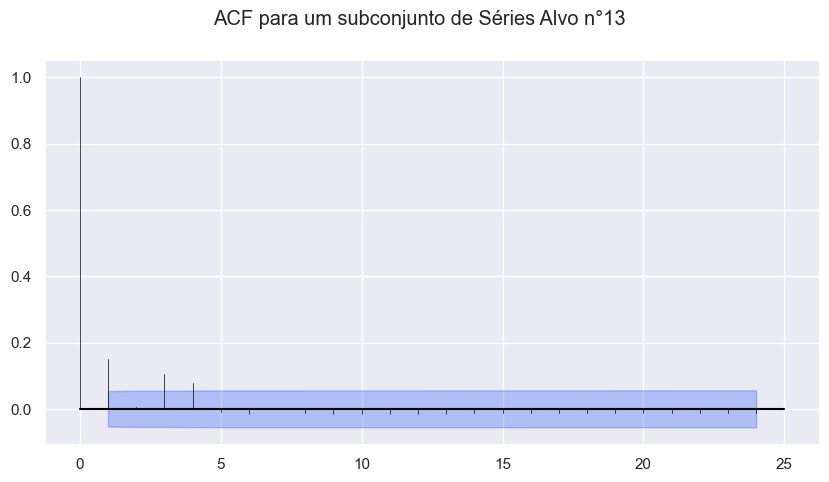

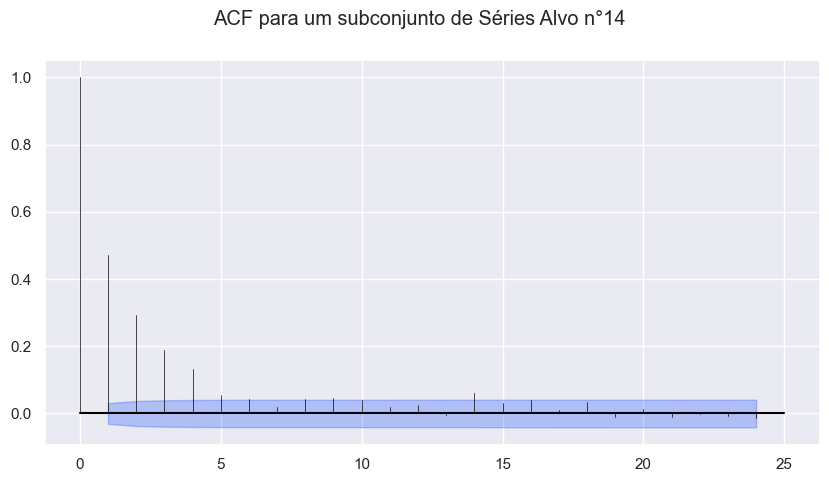

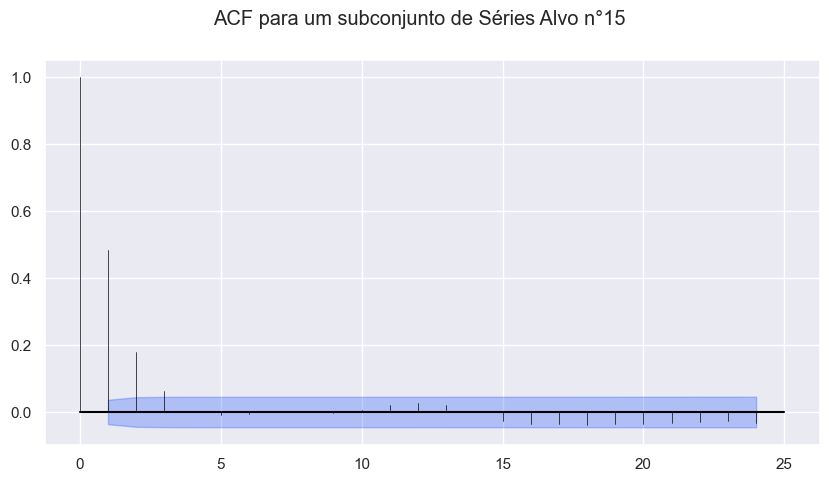

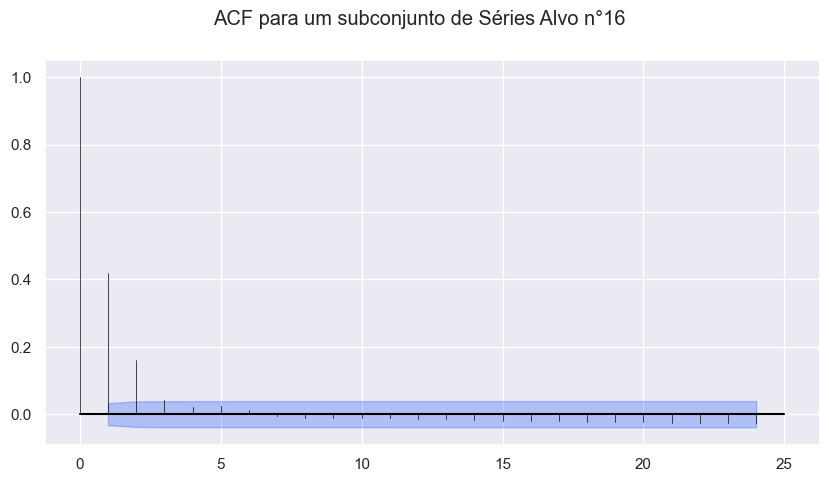

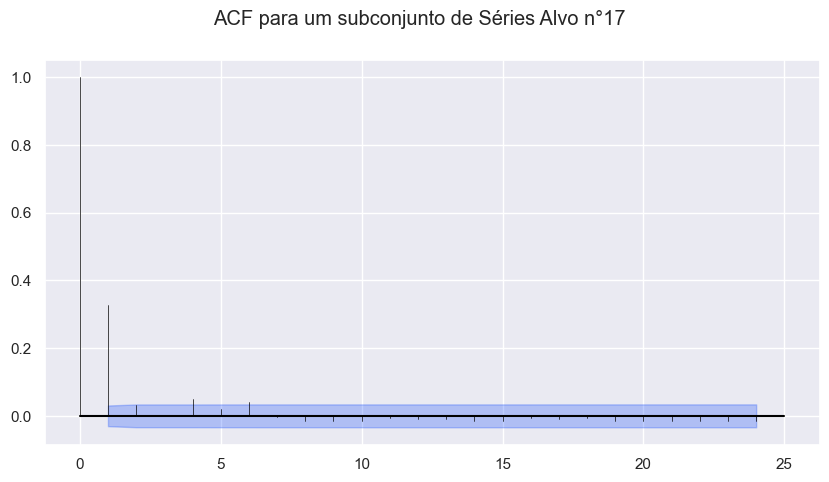

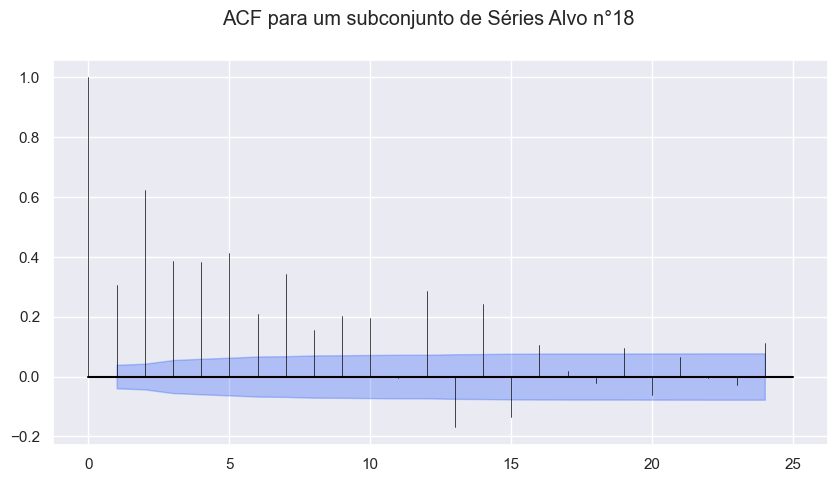

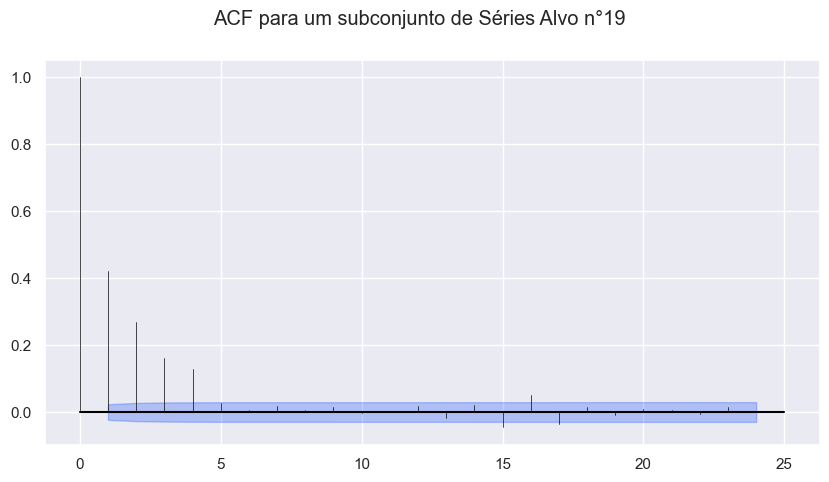

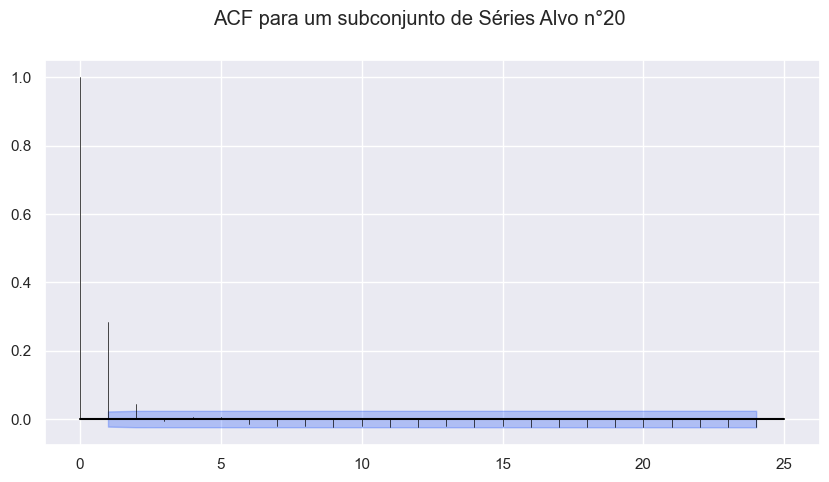

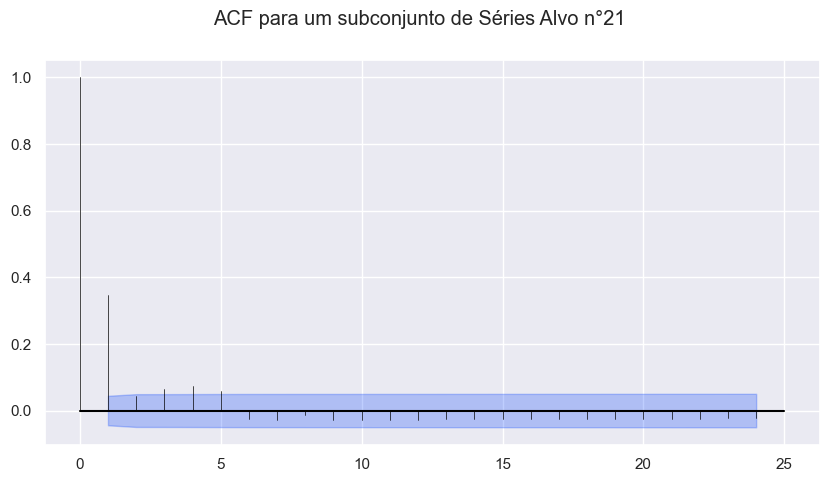

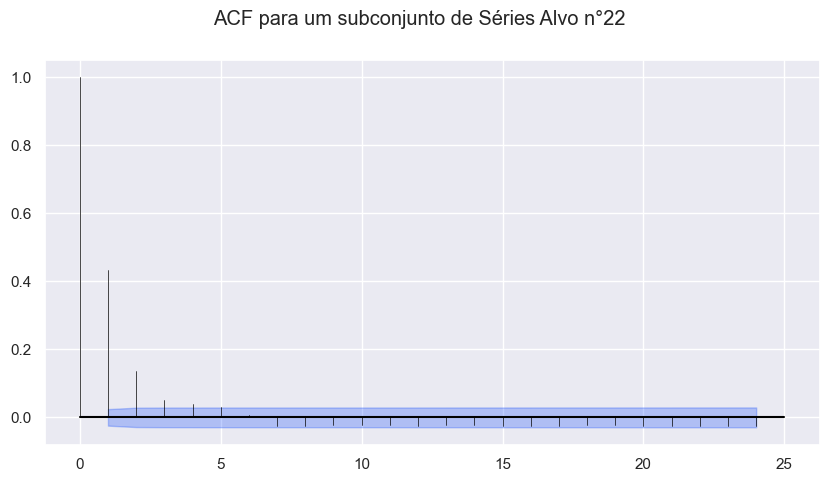

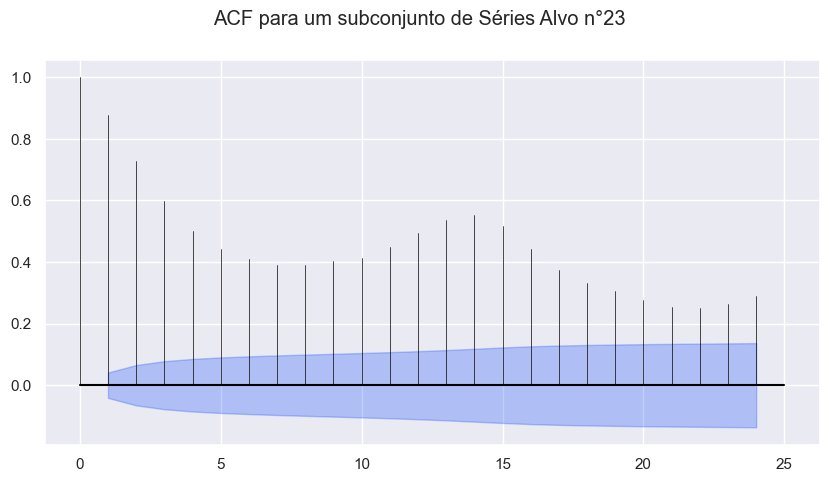

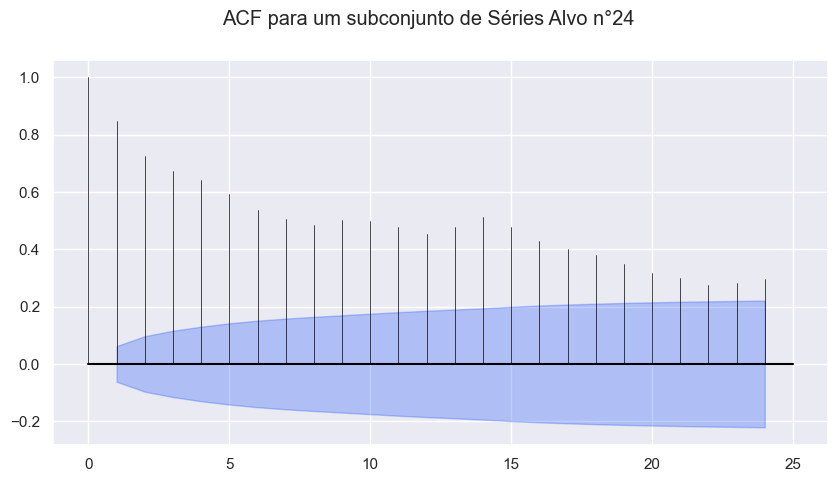

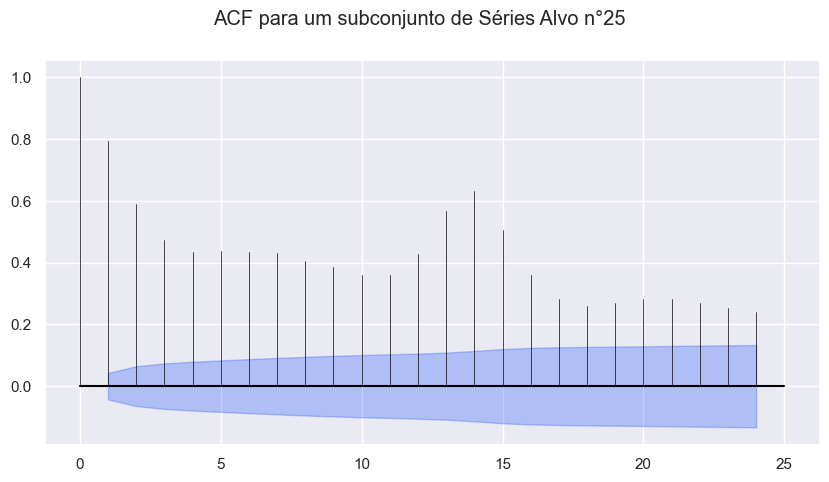

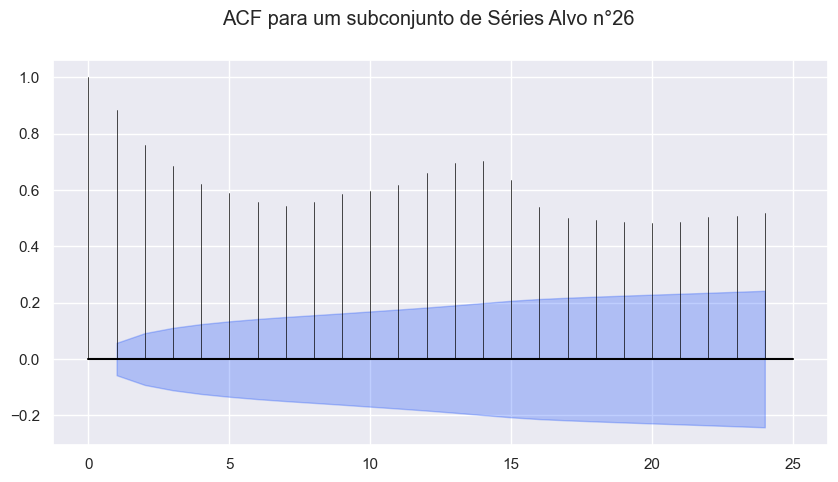

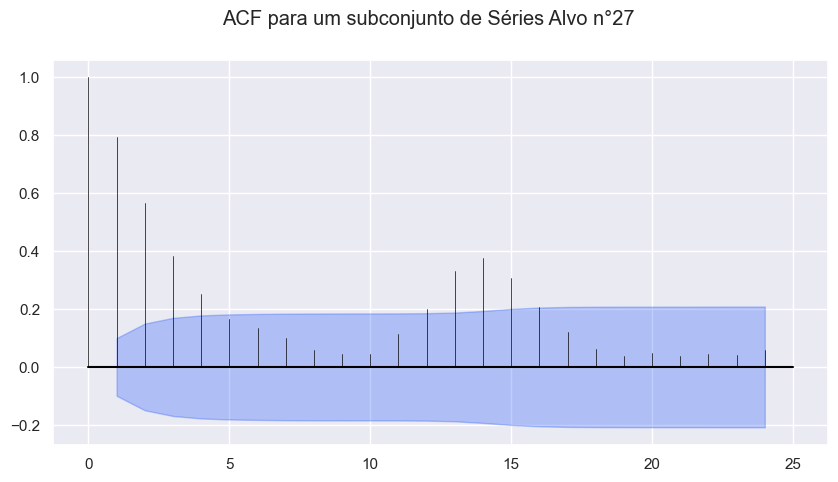

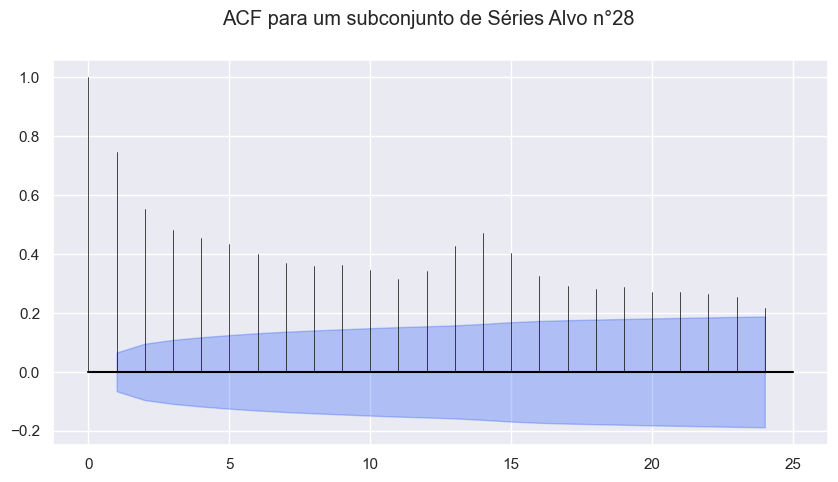

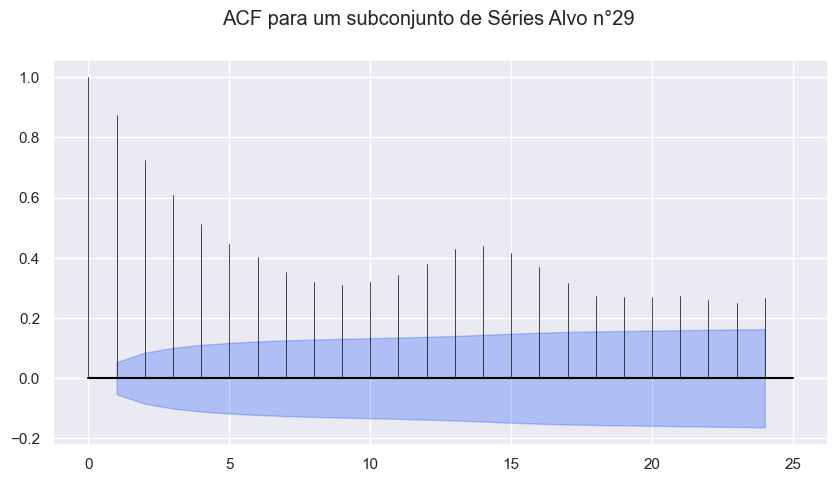

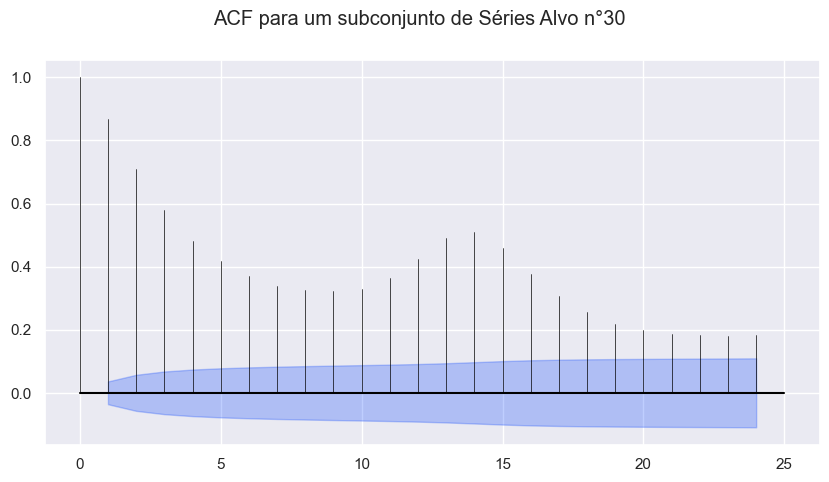

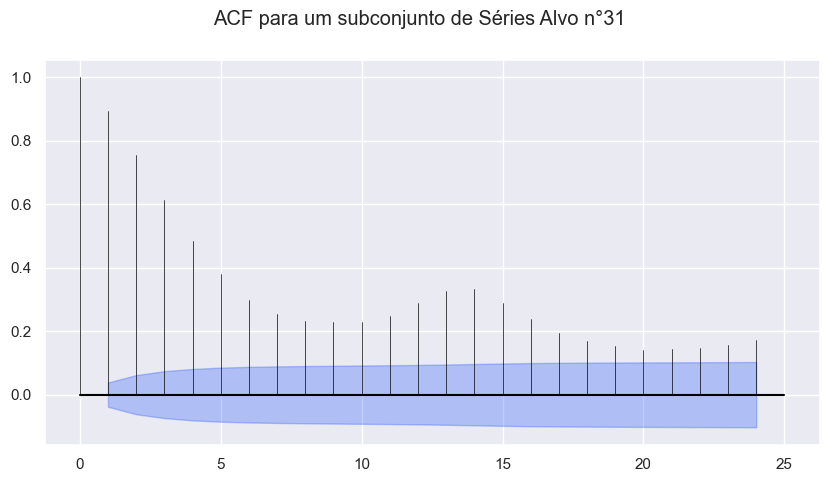

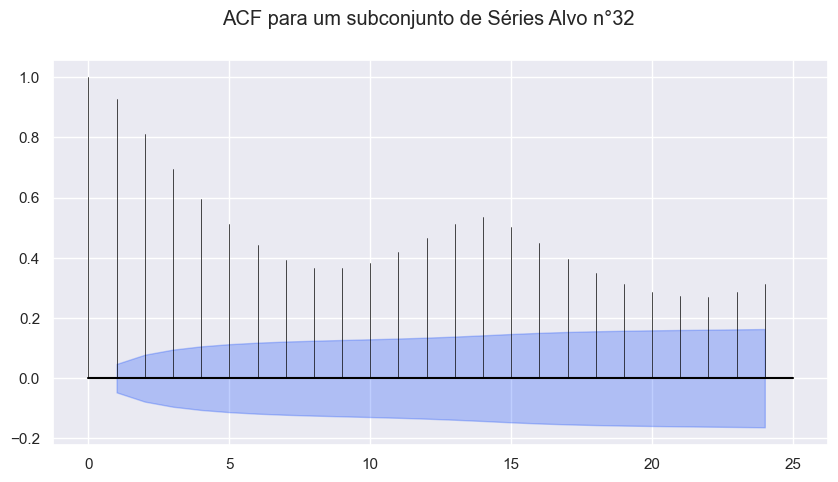

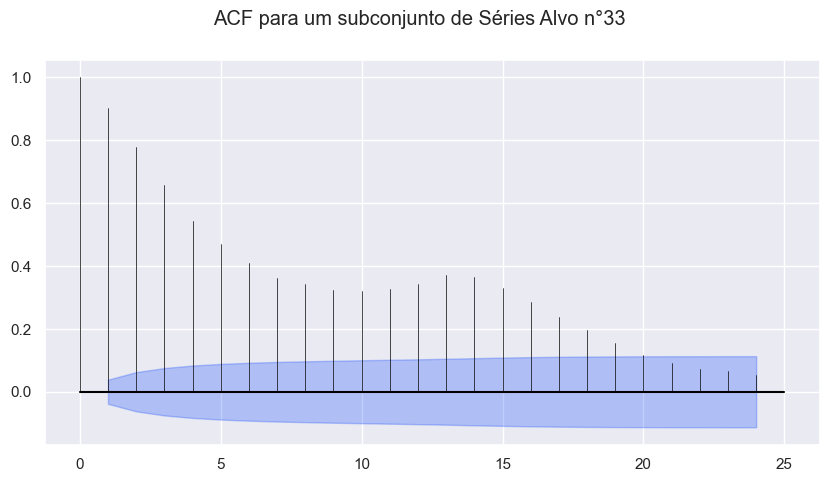

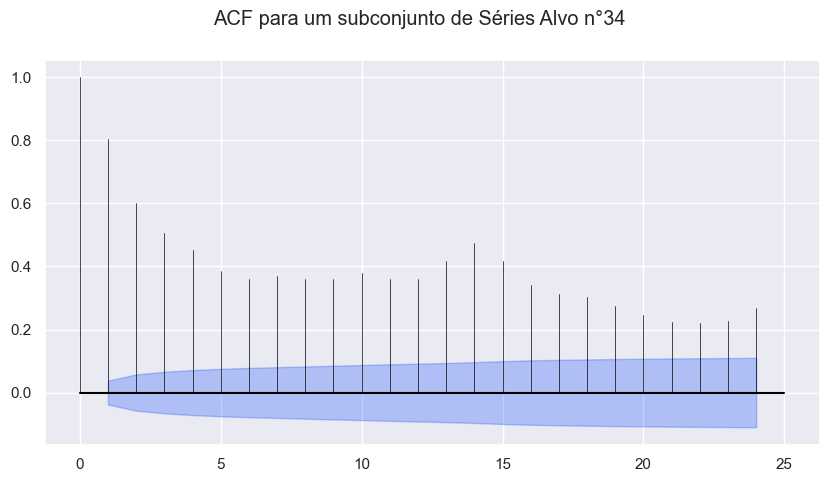

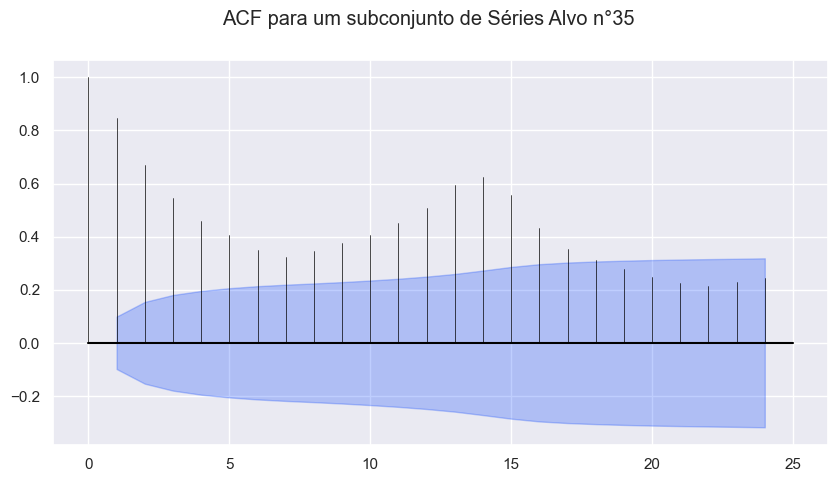

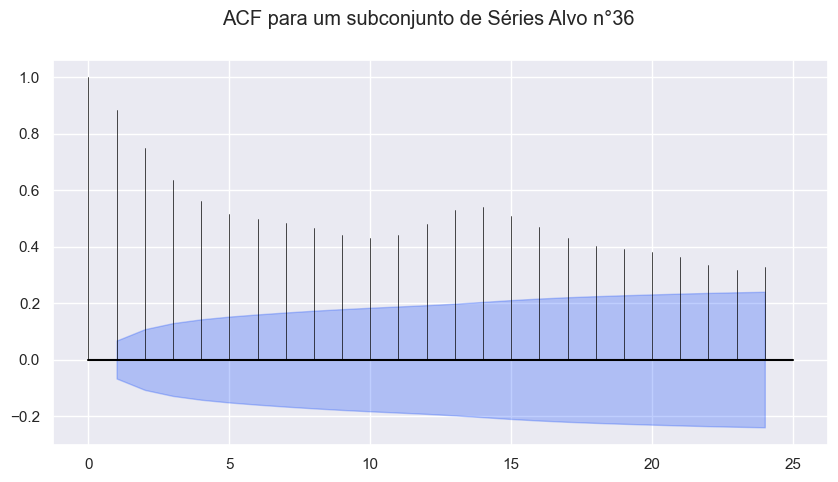

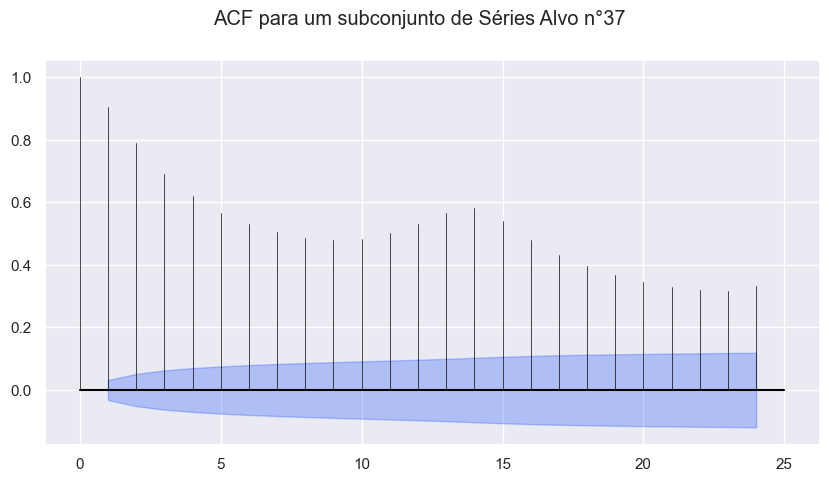

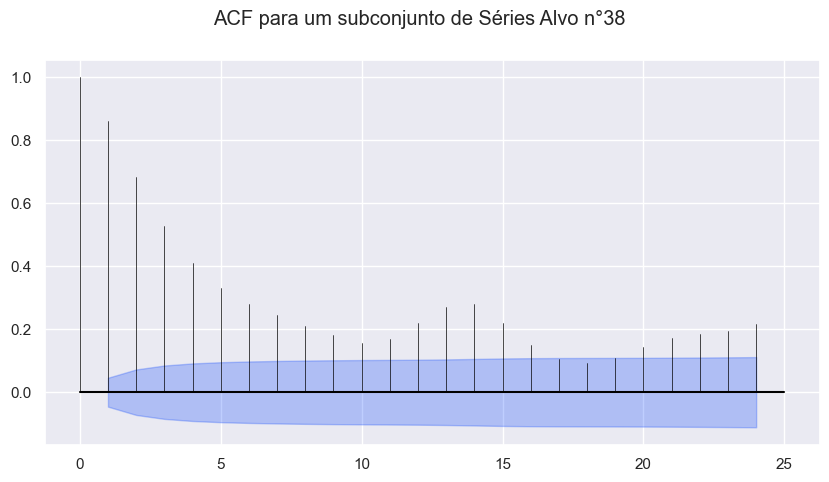

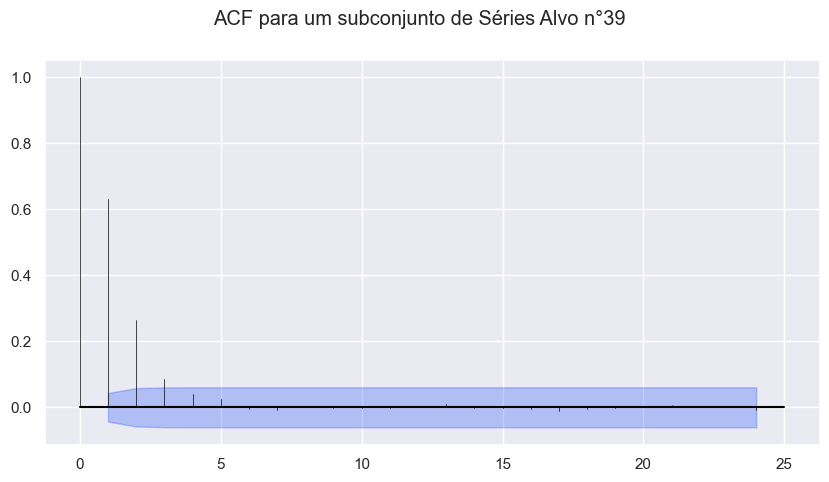

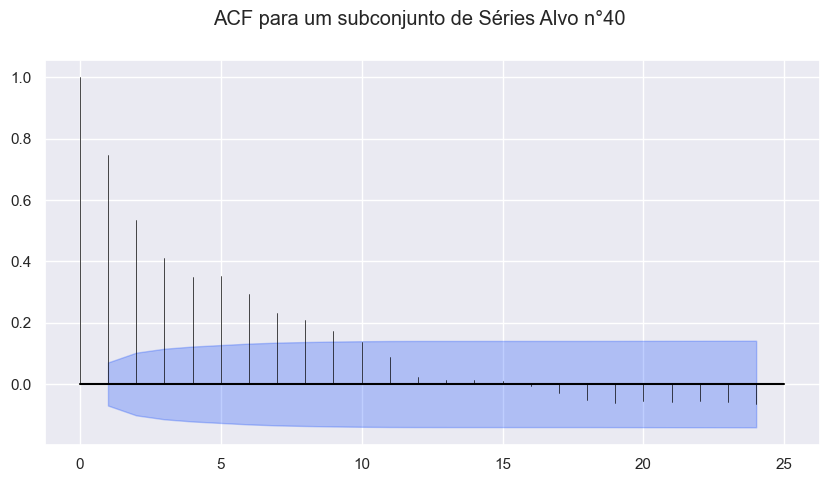

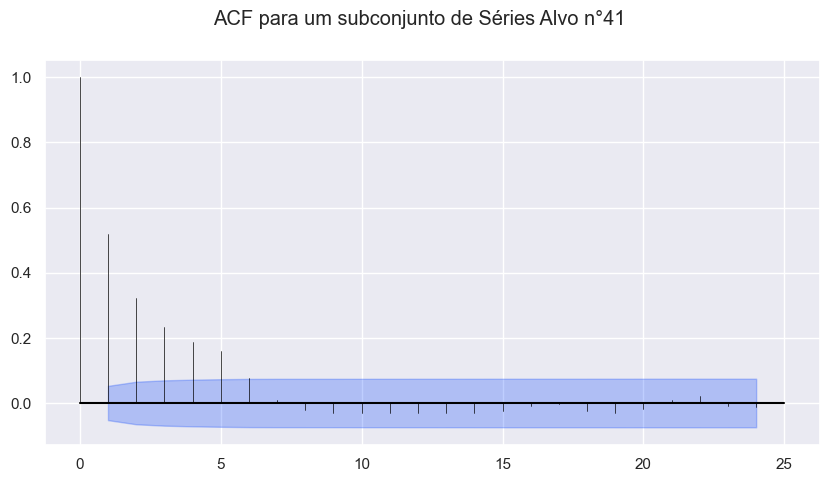

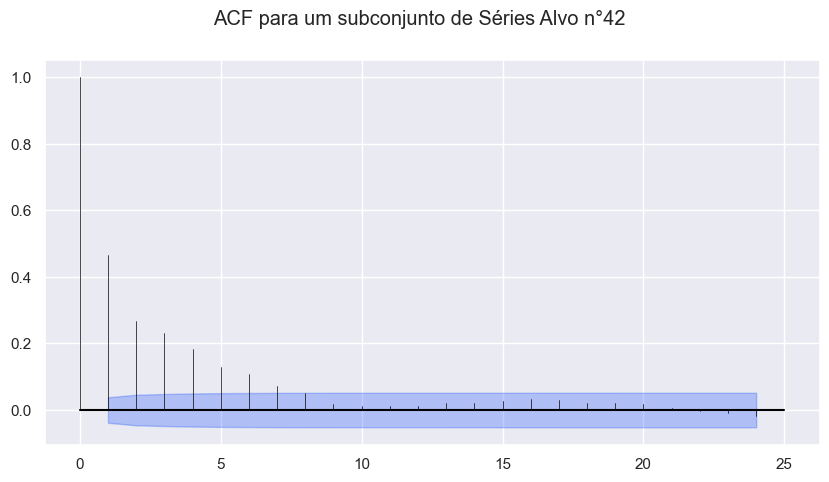

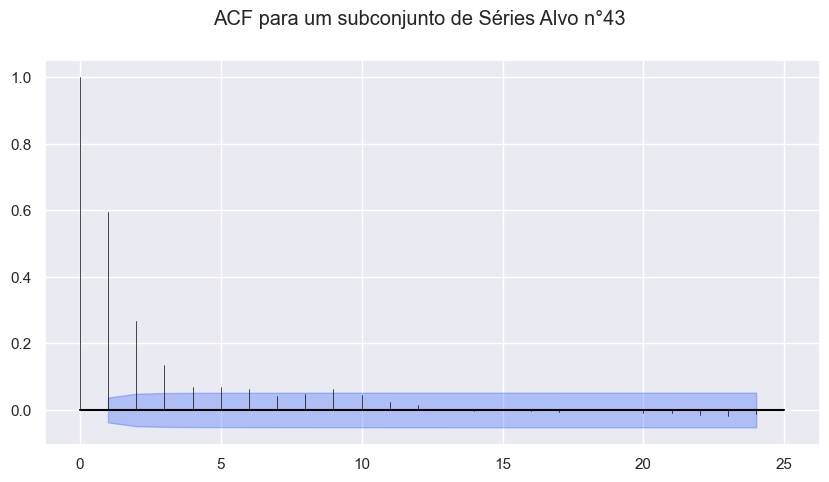

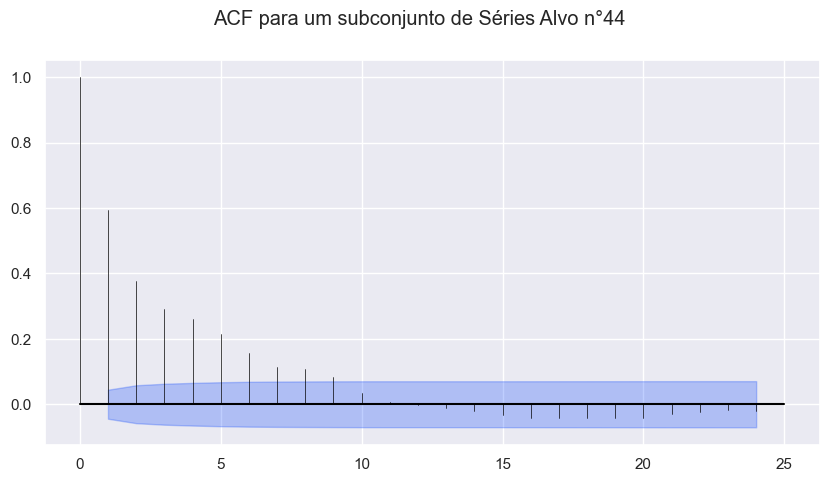

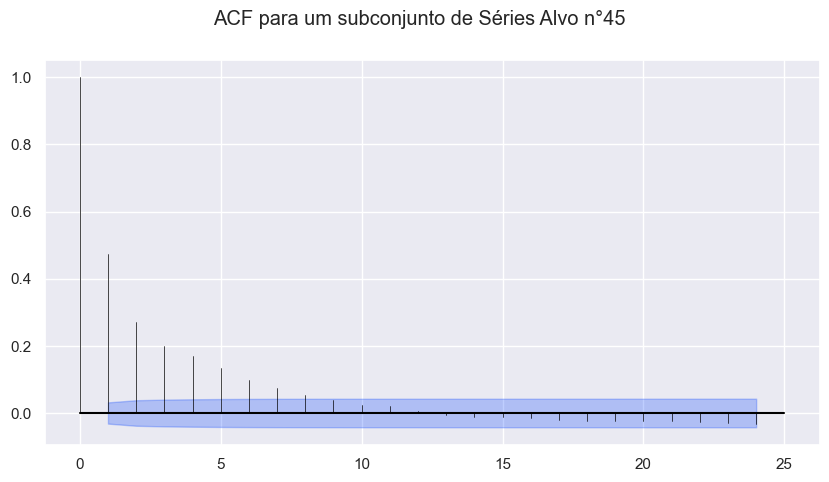

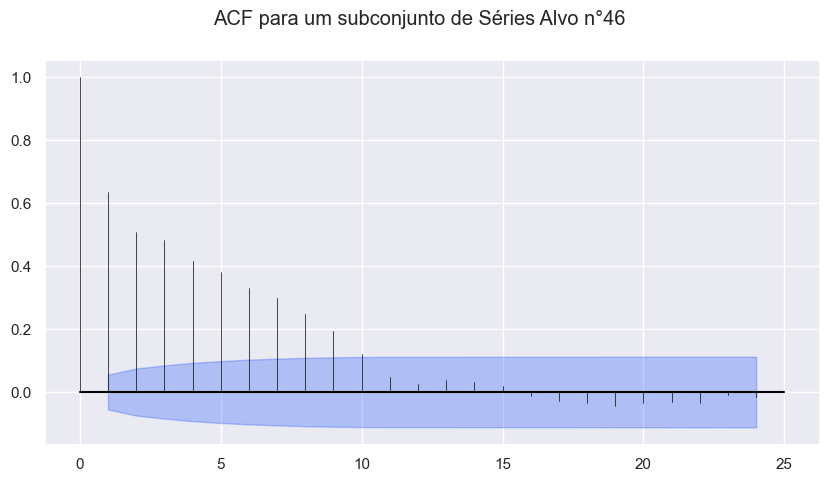

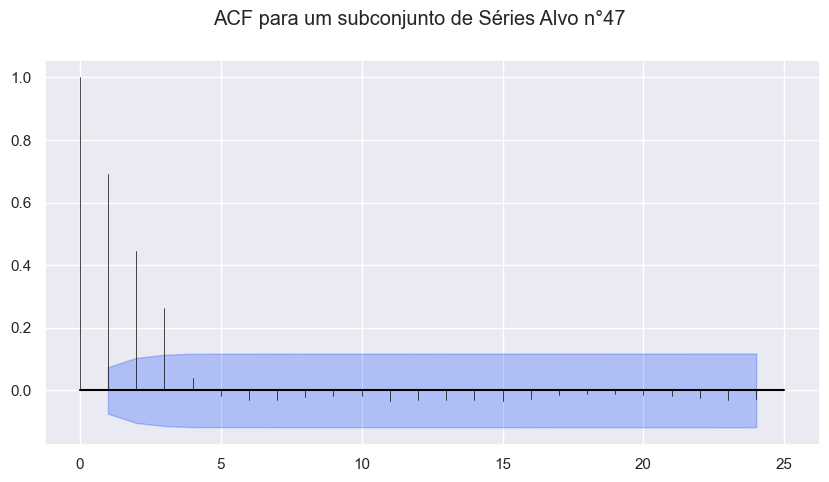

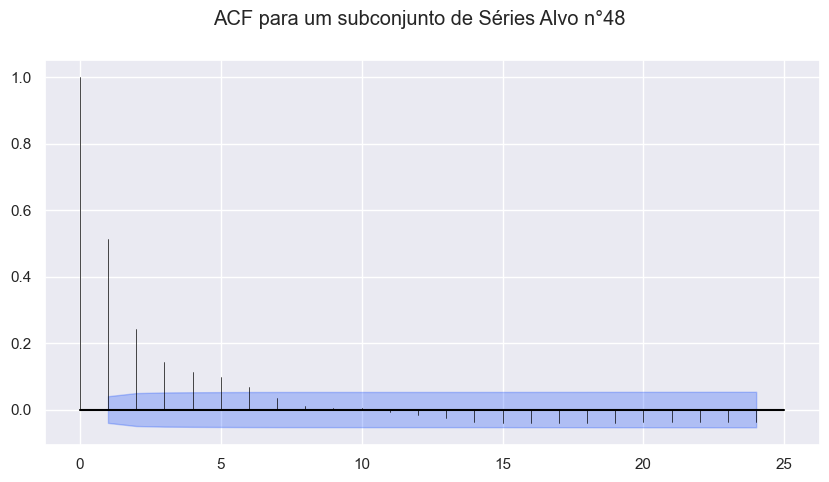

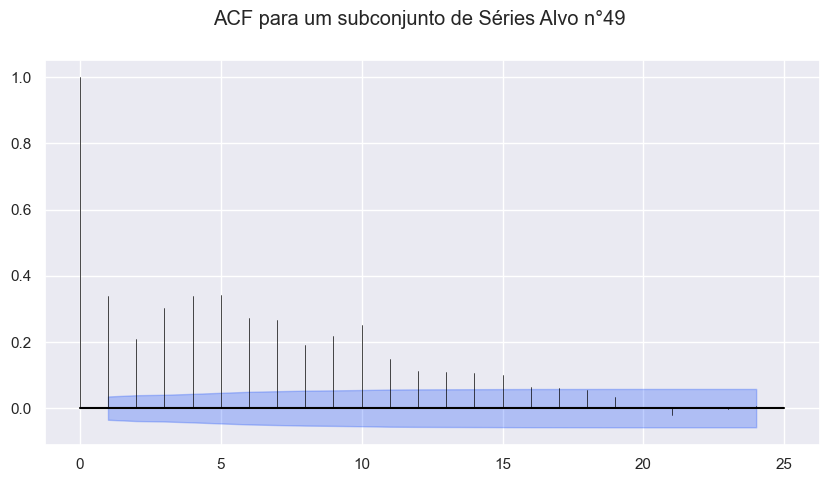

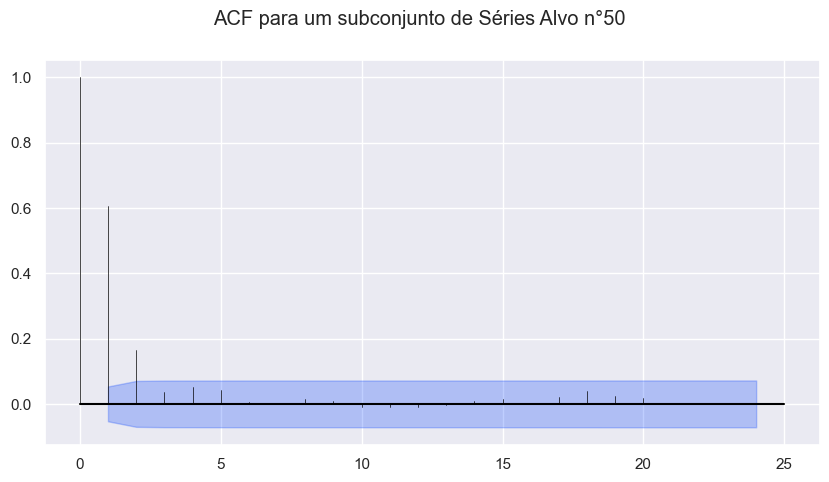

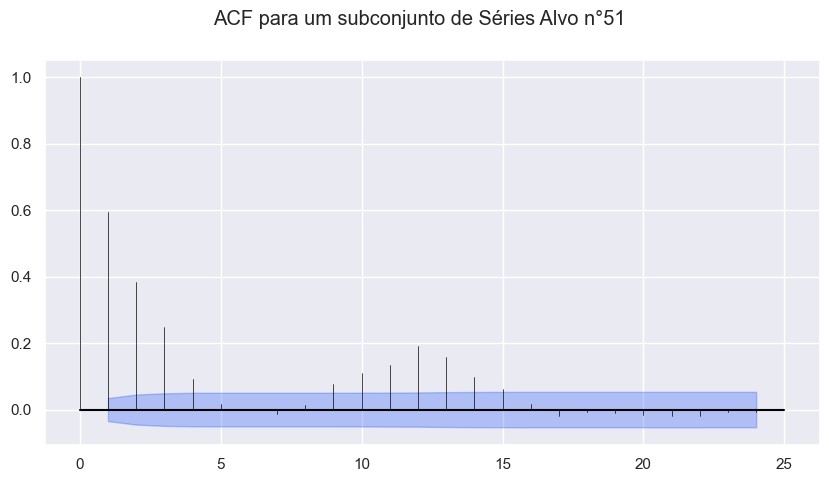

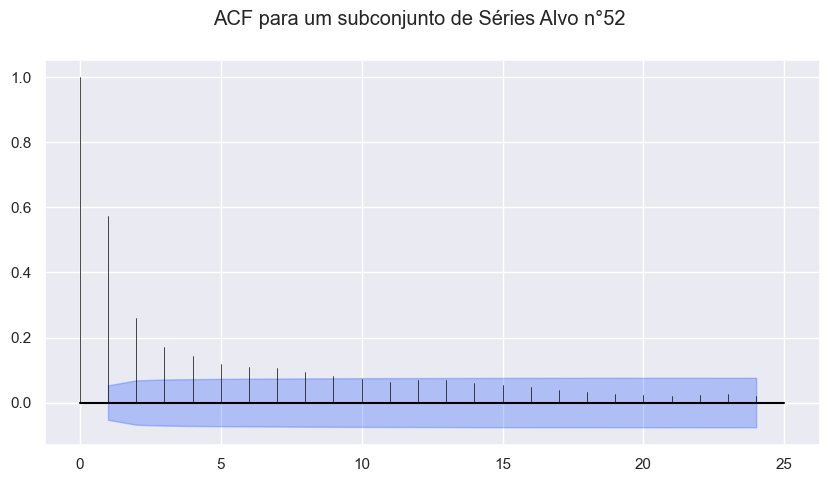

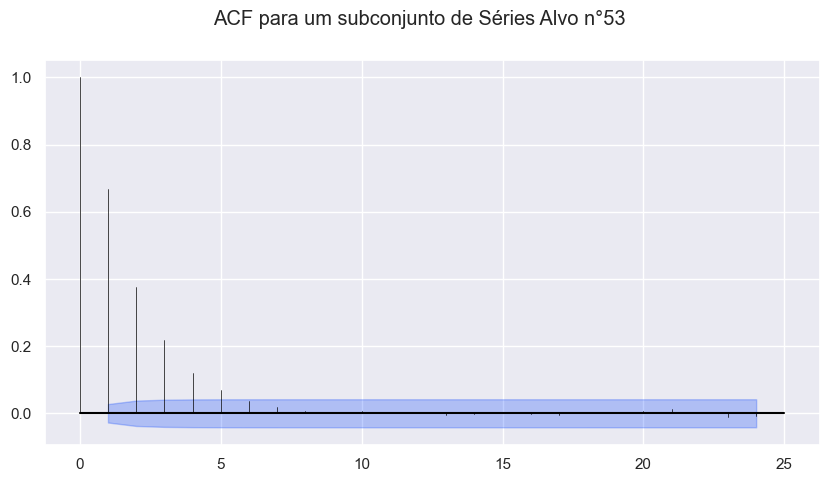

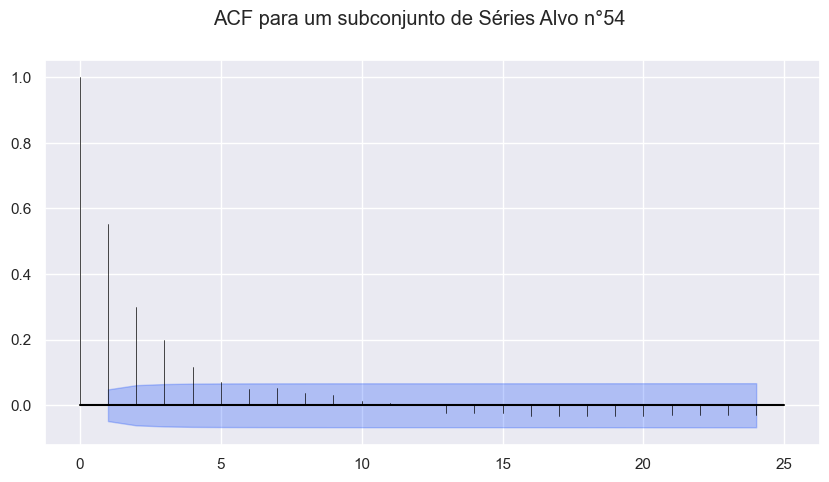

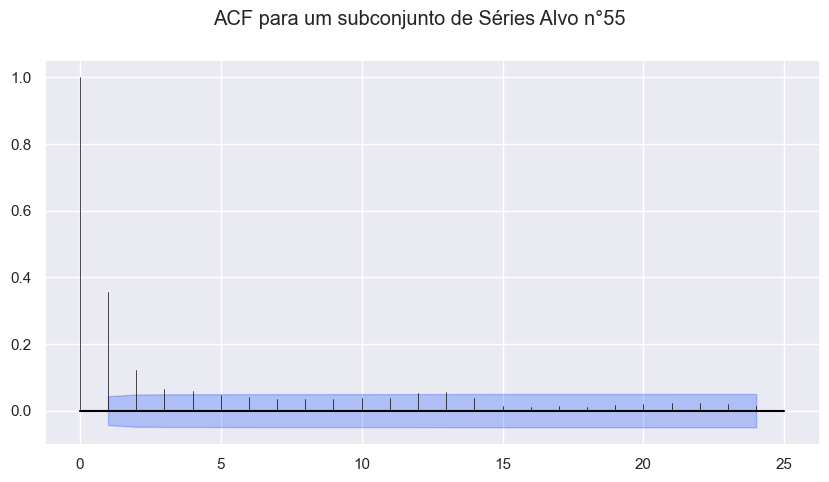

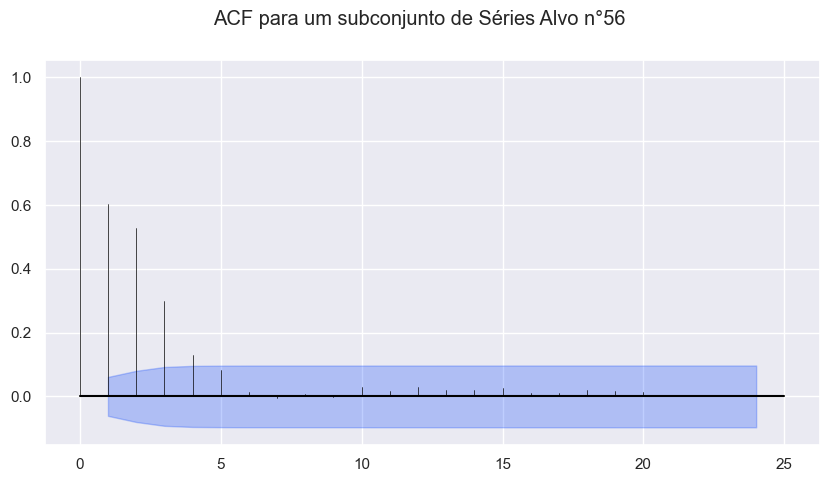

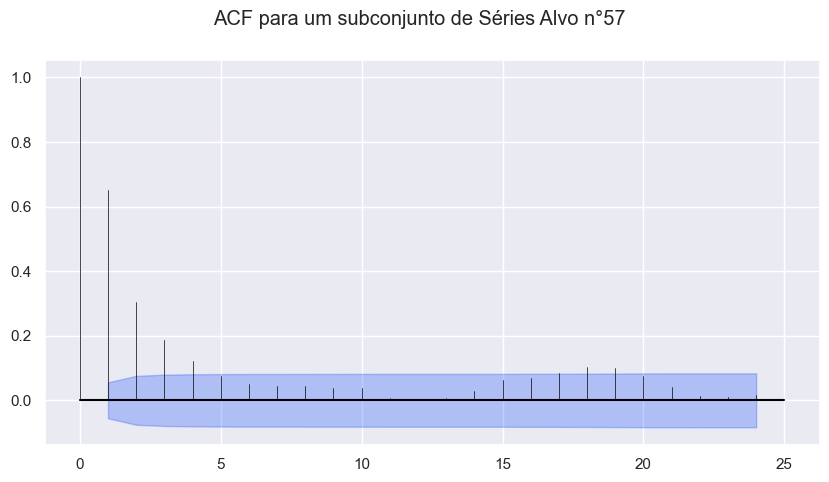

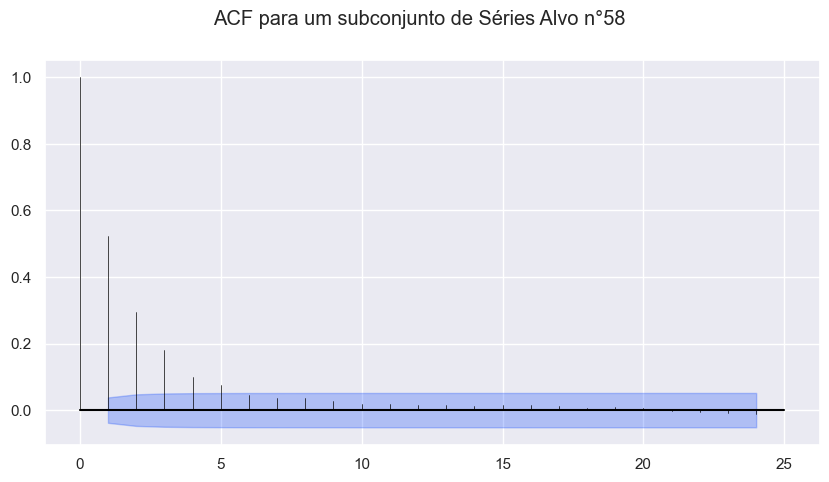

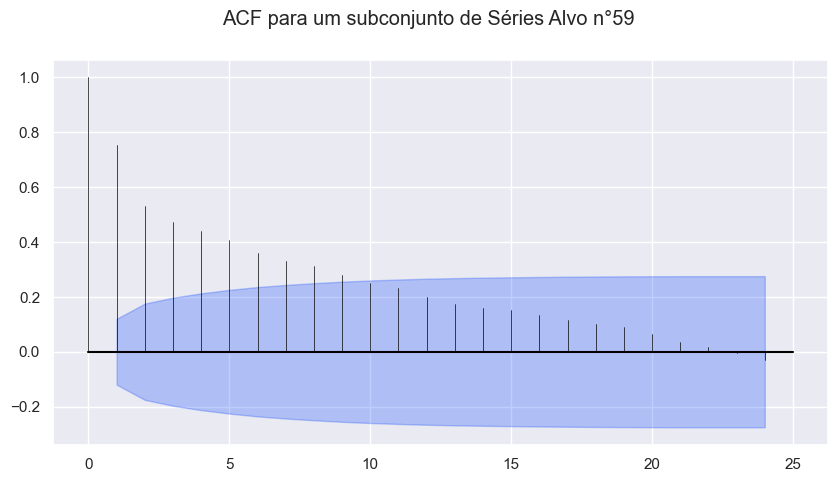

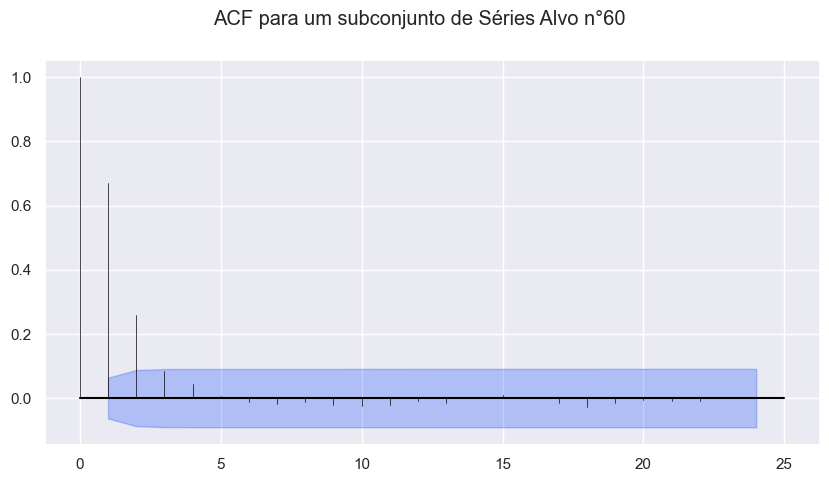

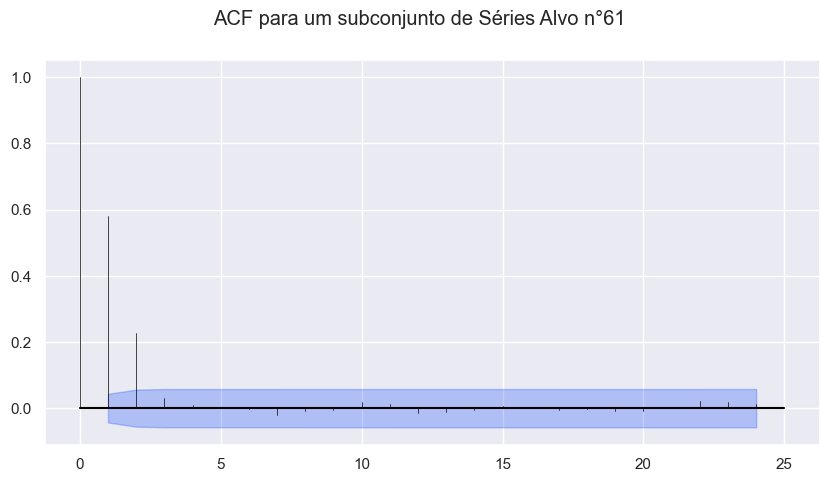

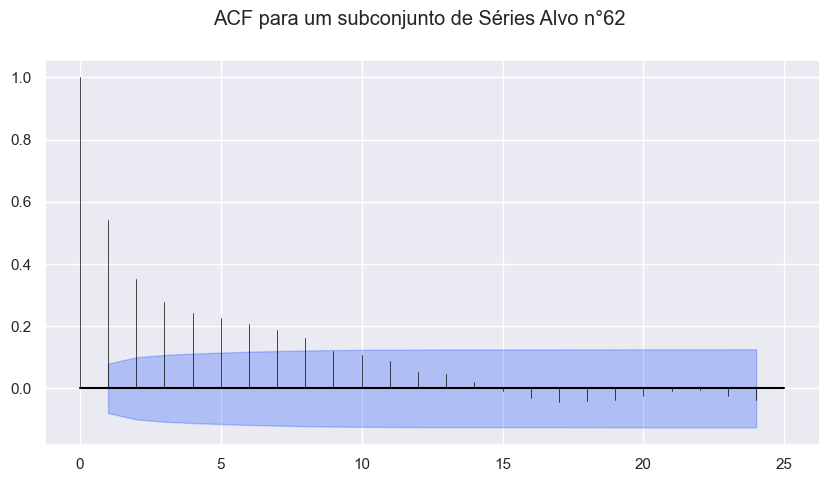

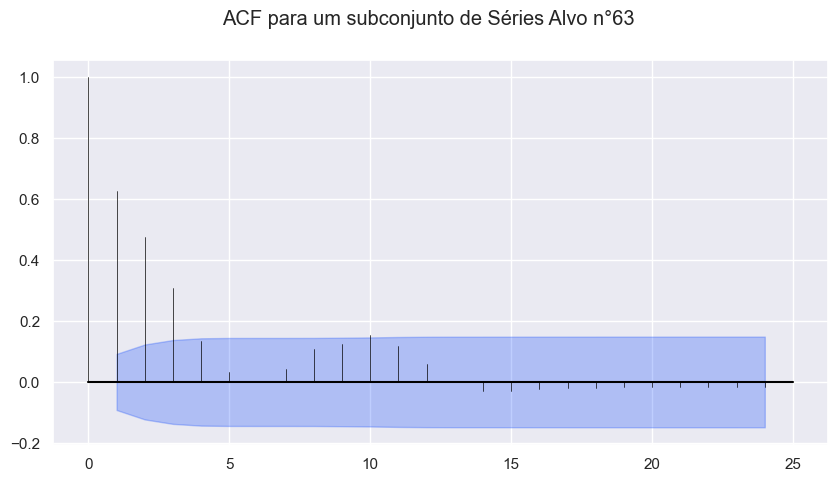

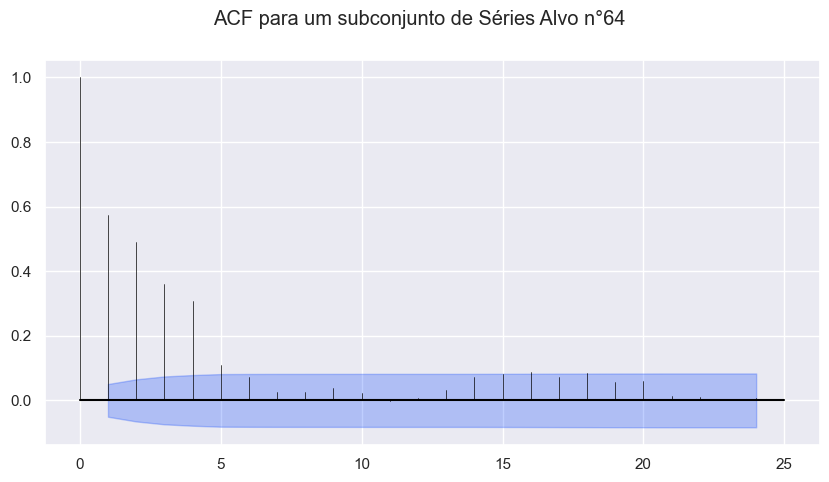

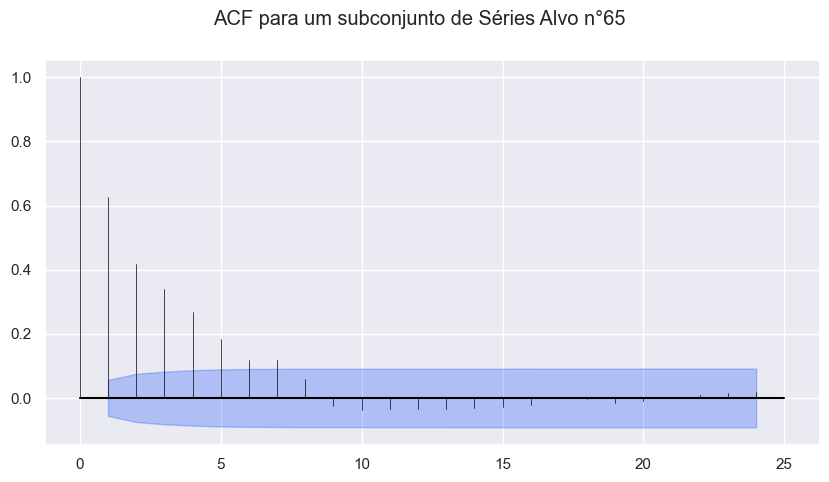

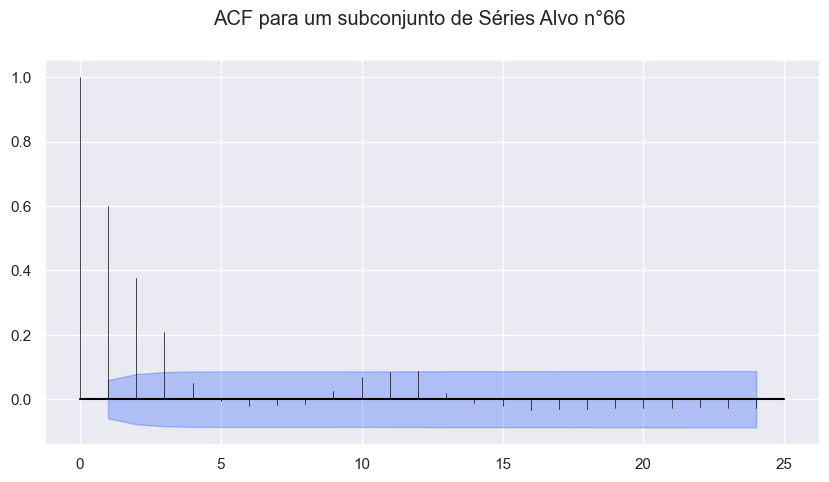

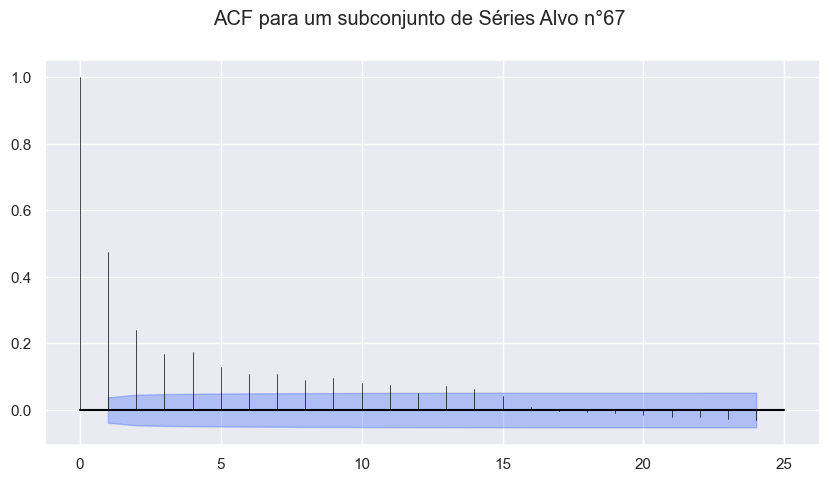

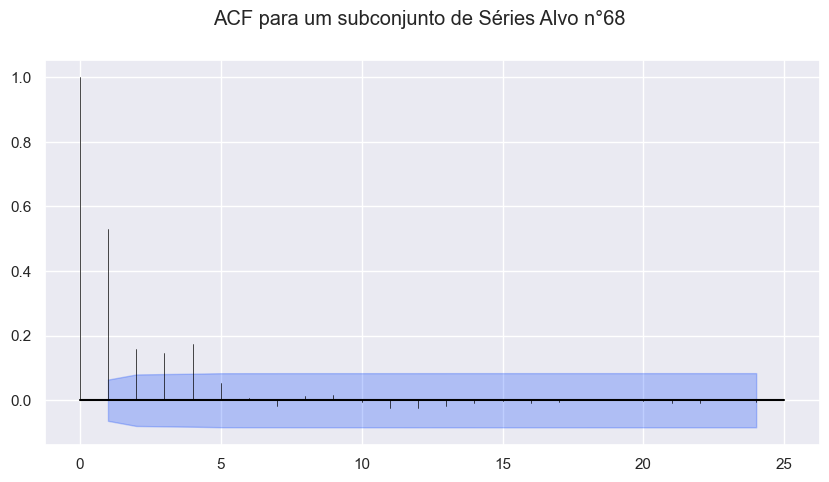

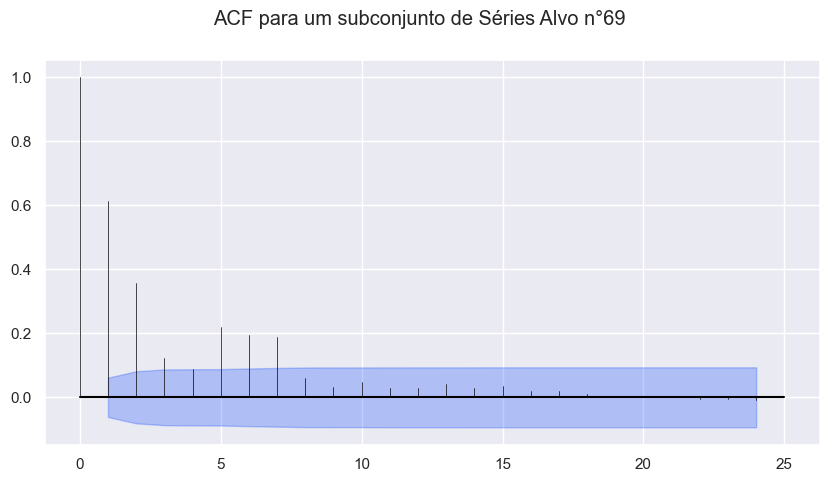

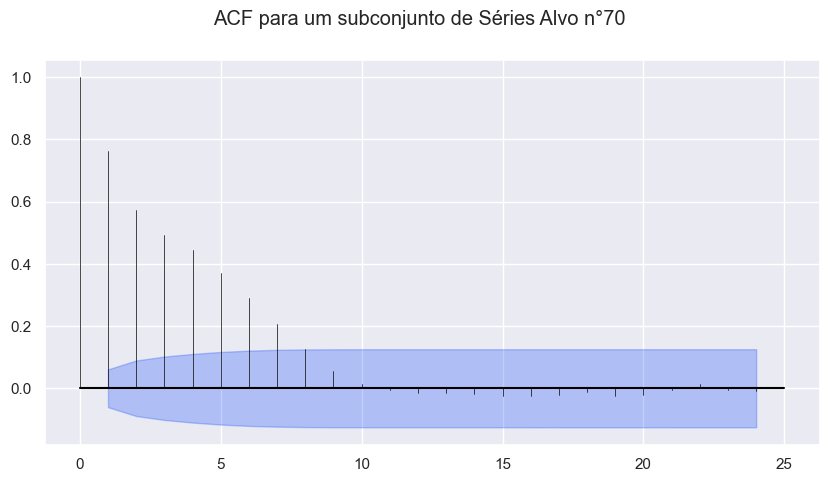

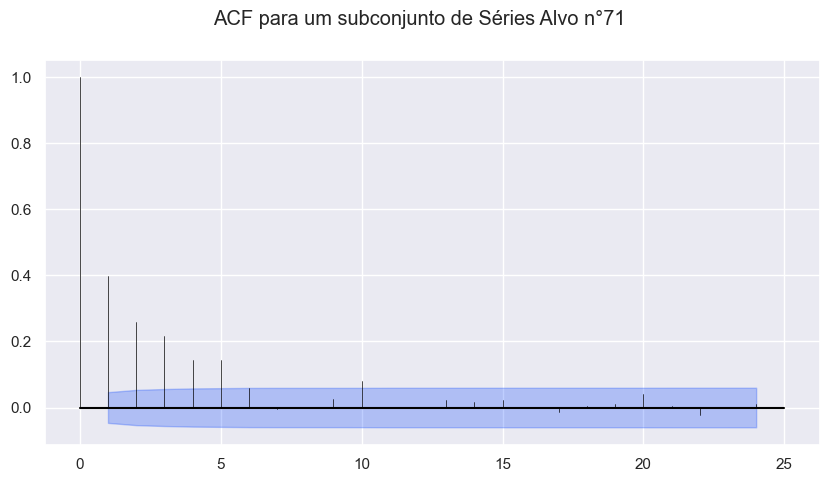

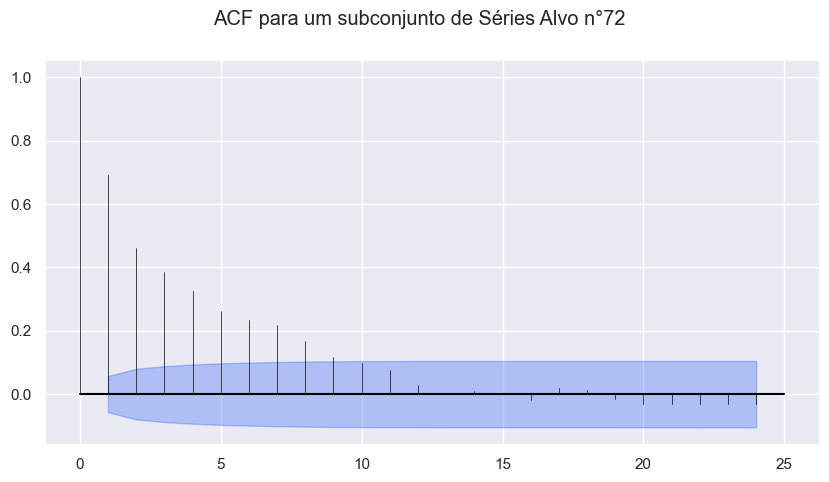

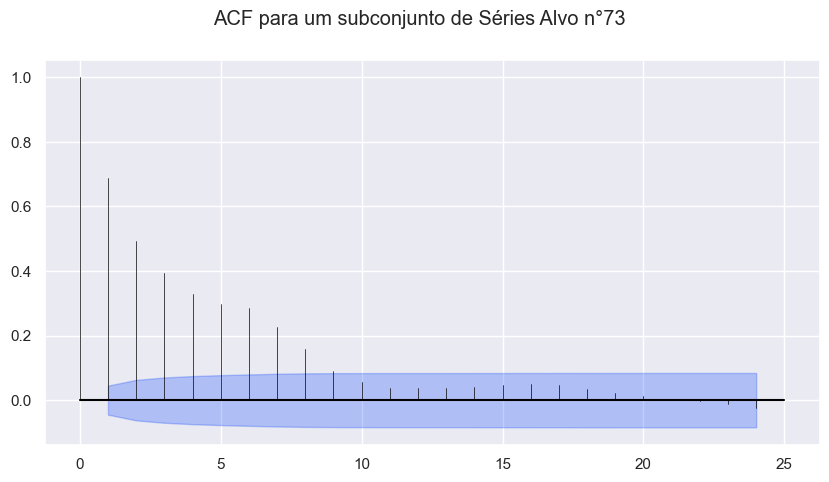

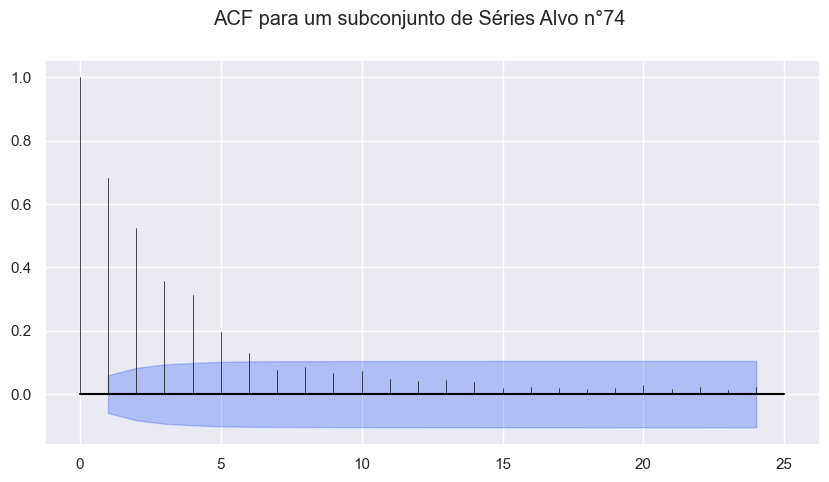

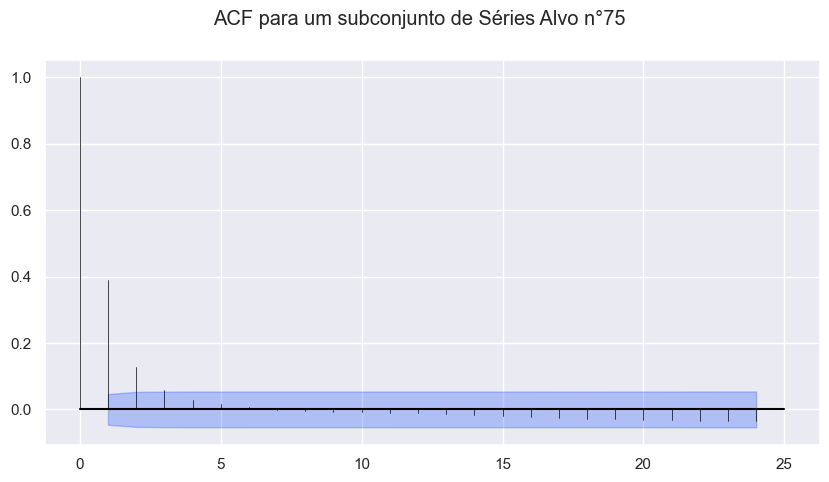

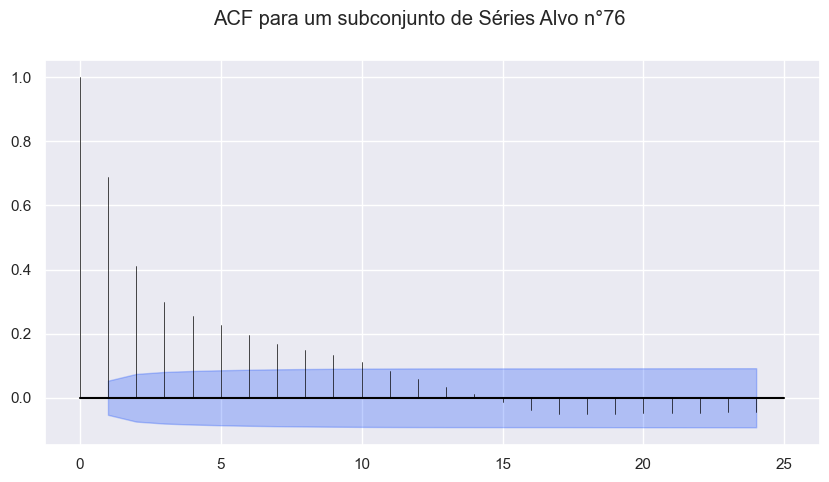

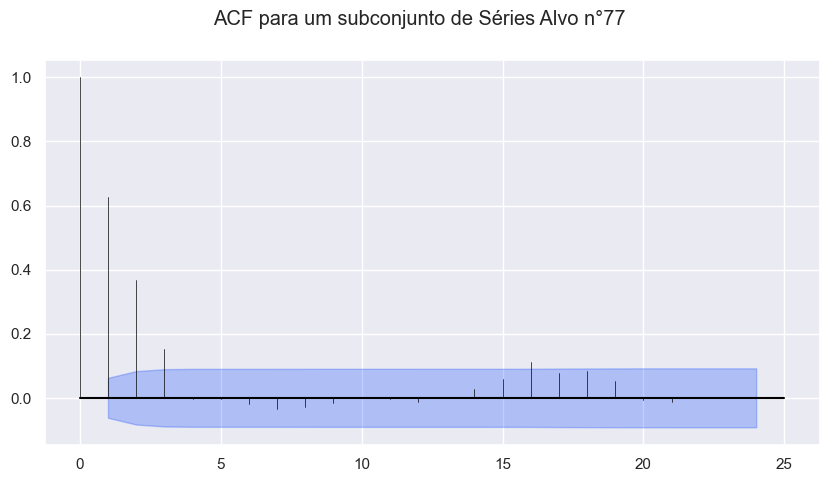

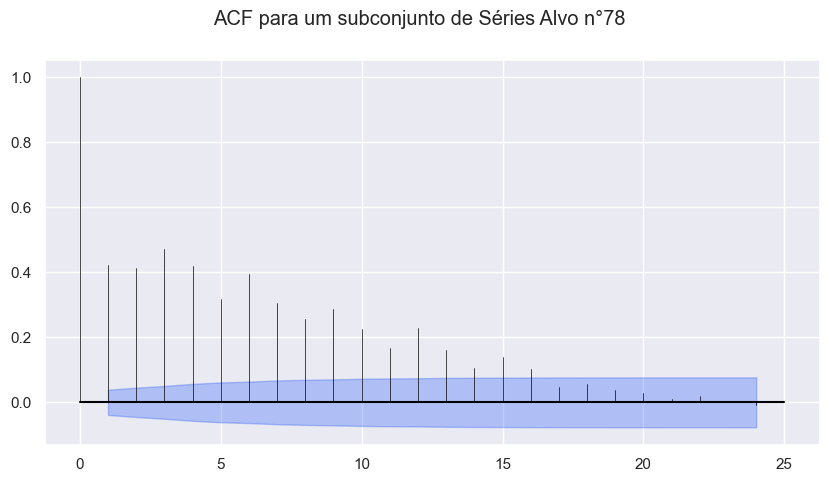

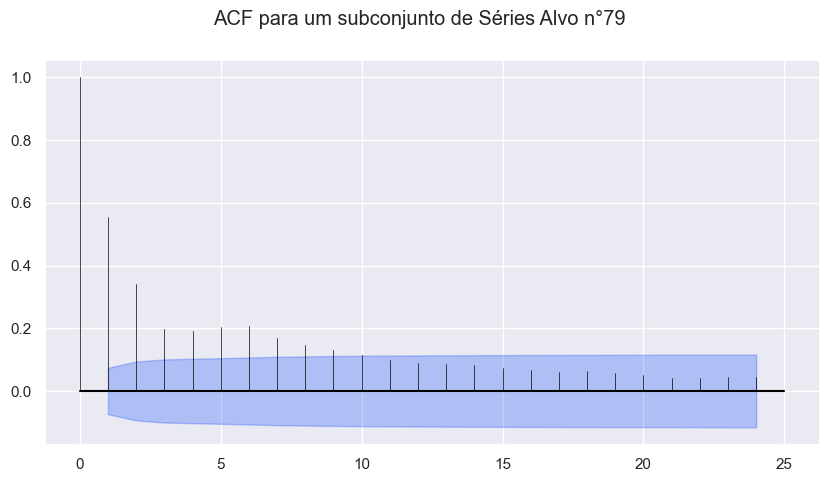

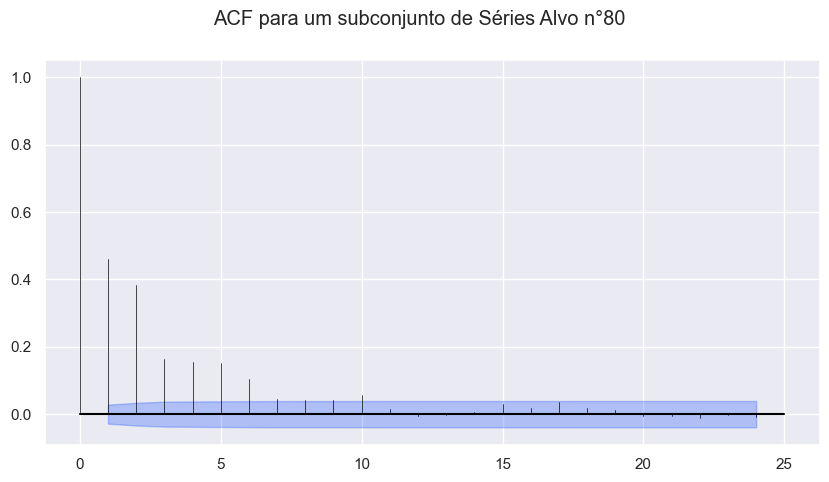

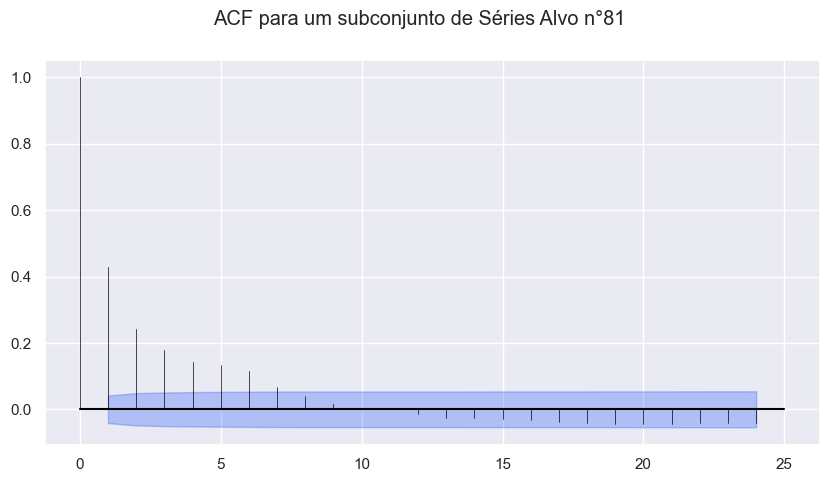

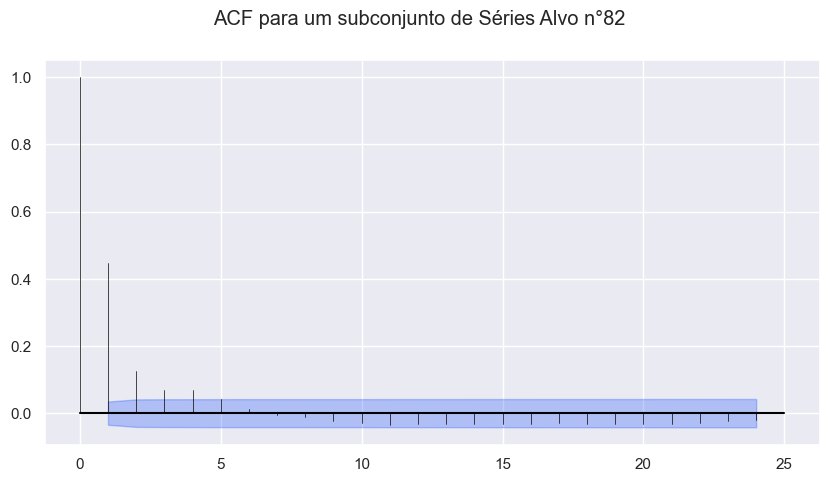

In [78]:
for idx, serie in enumerate(all_targets):
    plot_acf(serie, m=None, max_lag=24, alpha=0.05);
    plt.suptitle(f"ACF para um subconjunto de Séries Alvo n°{idx}")

## Partial Autocorrelation

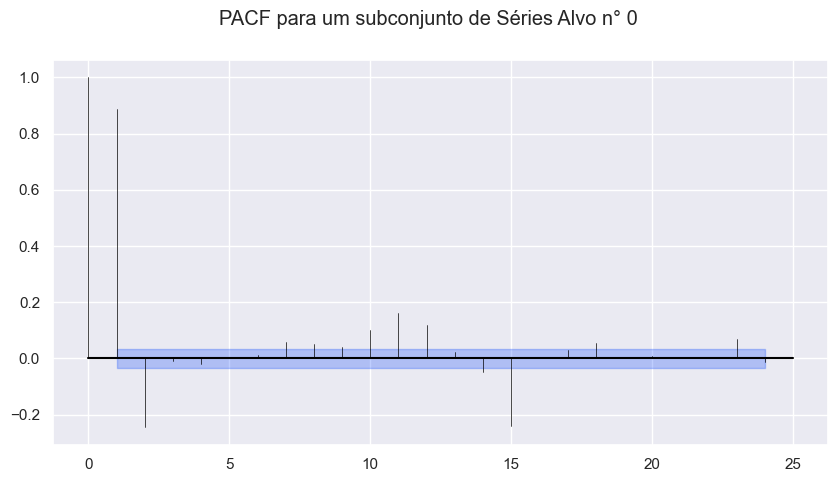

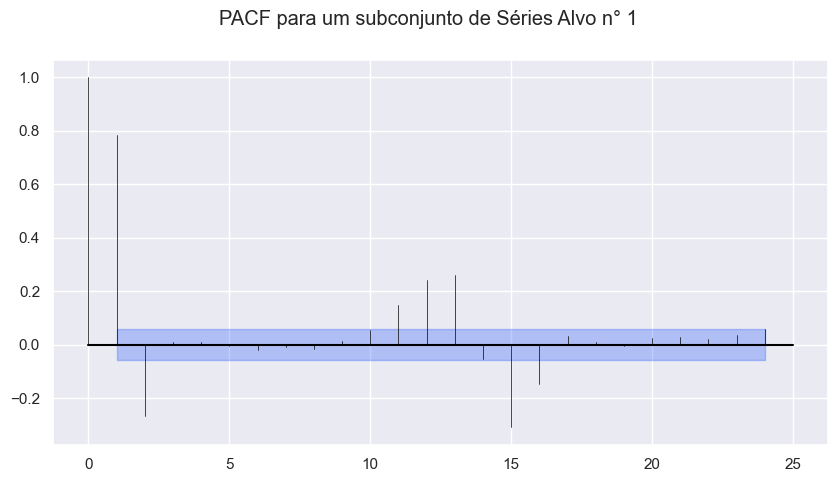

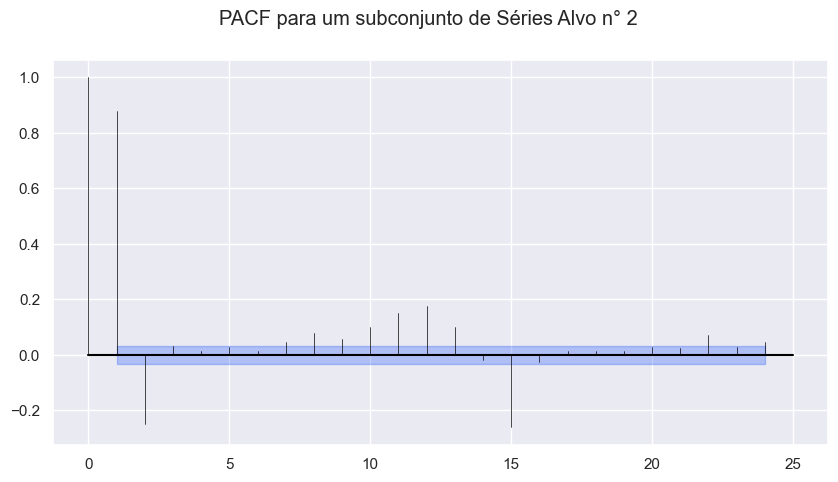

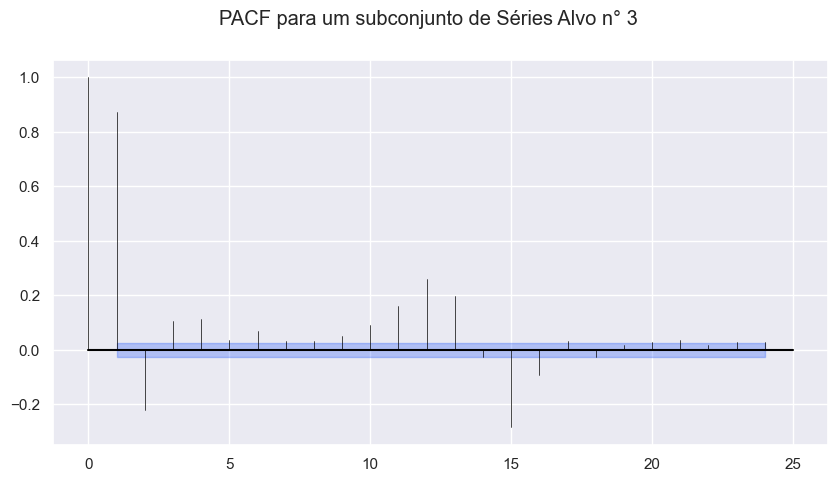

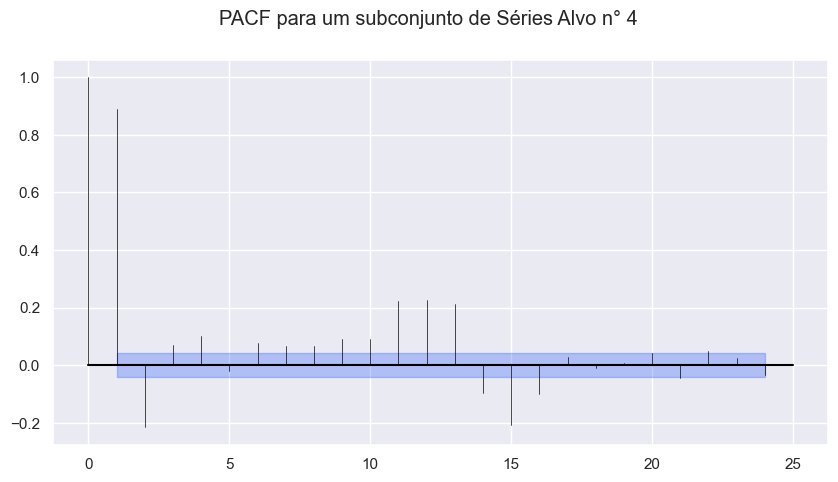

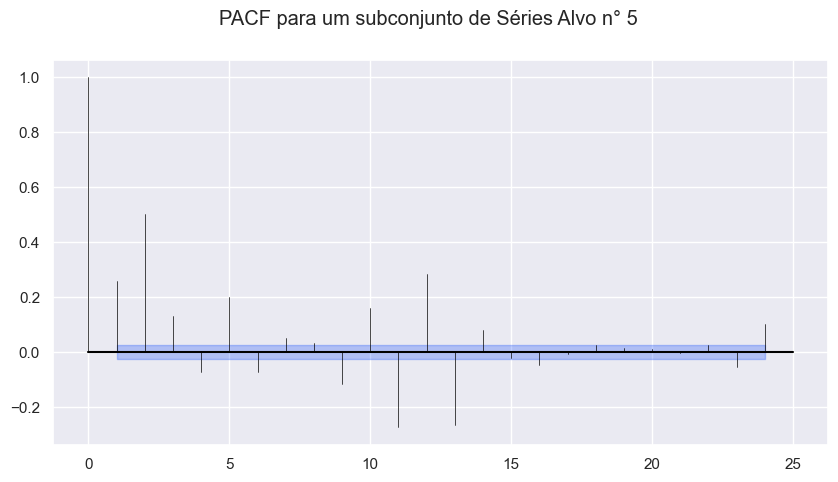

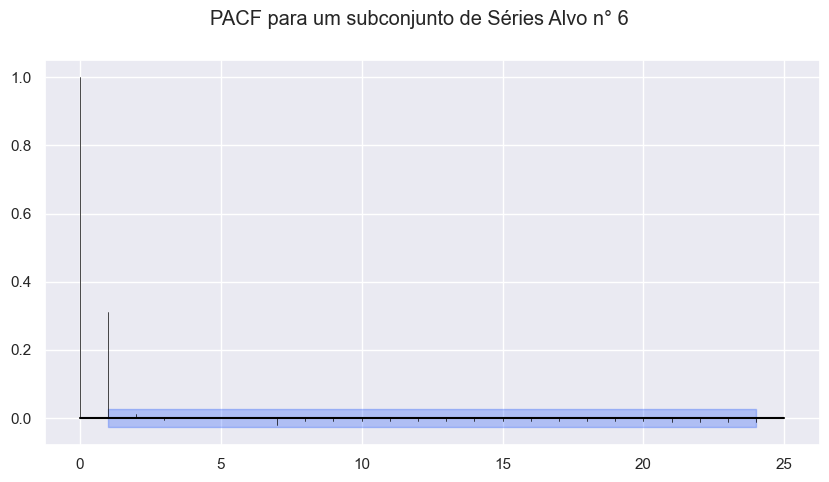

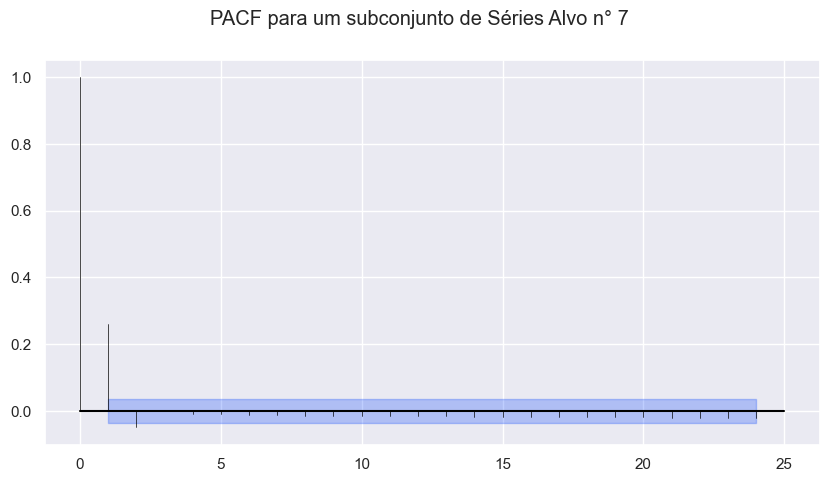

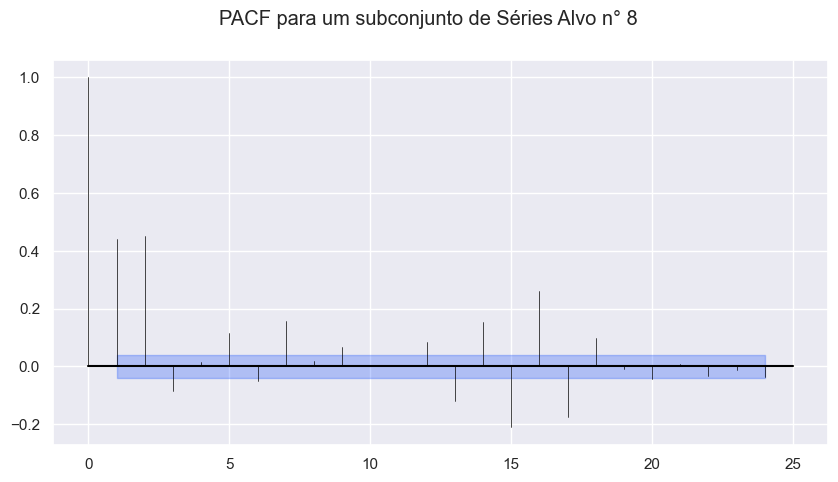

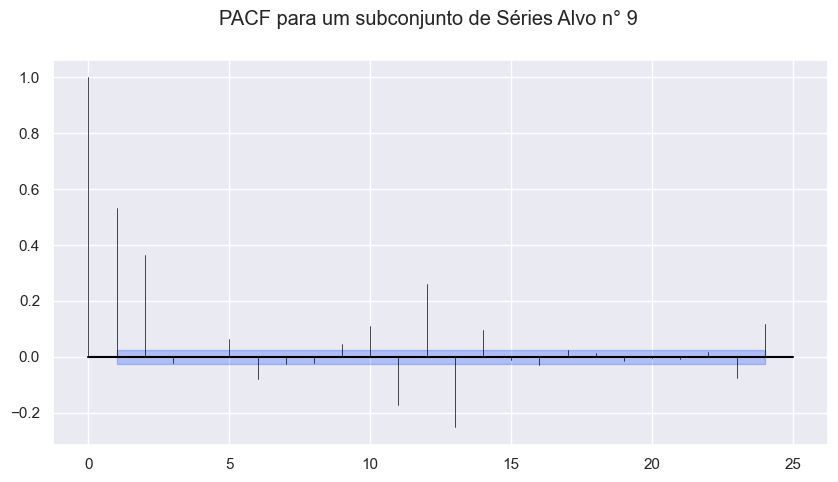

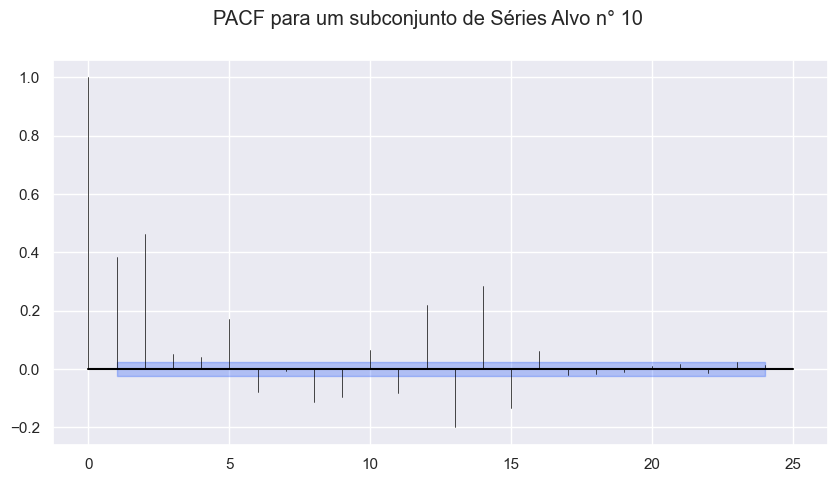

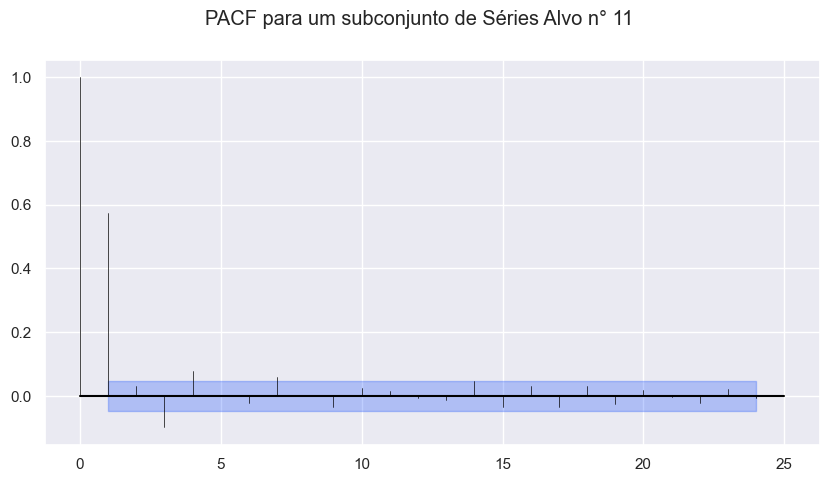

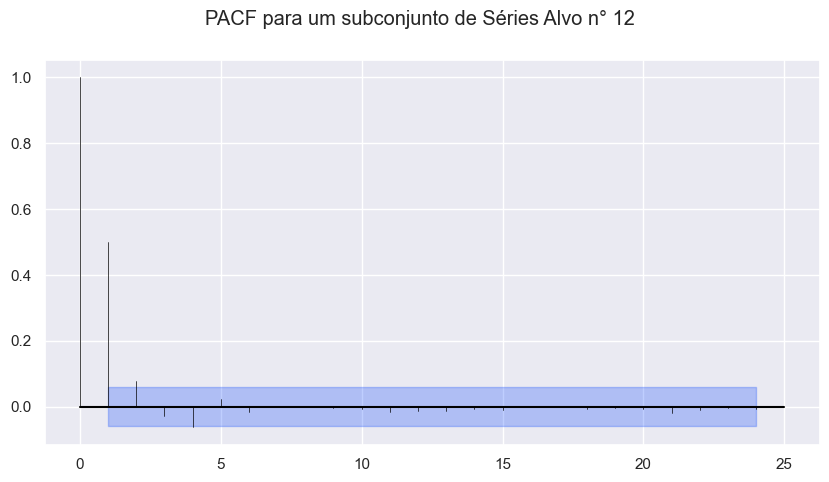

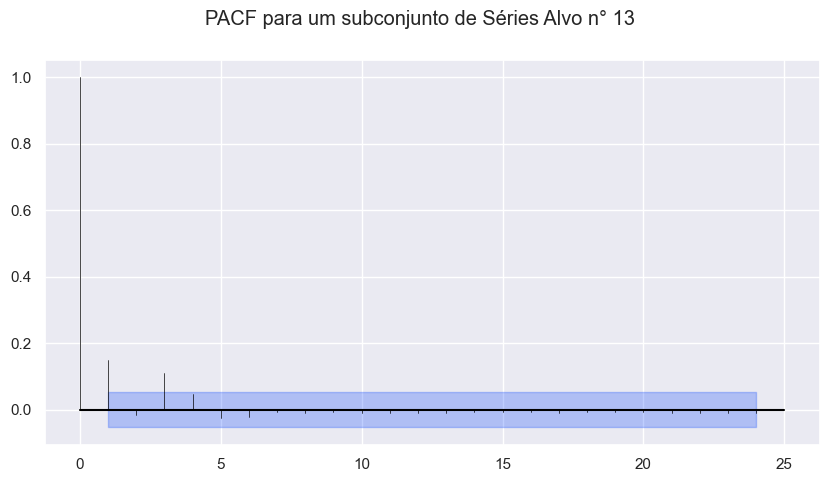

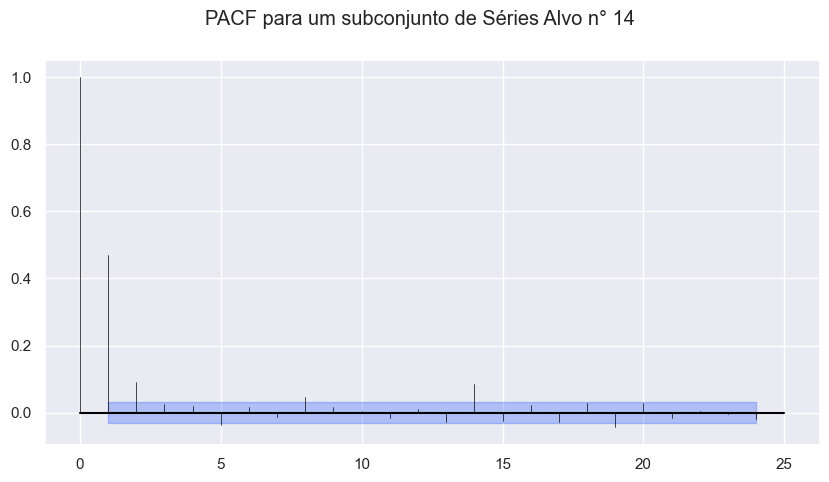

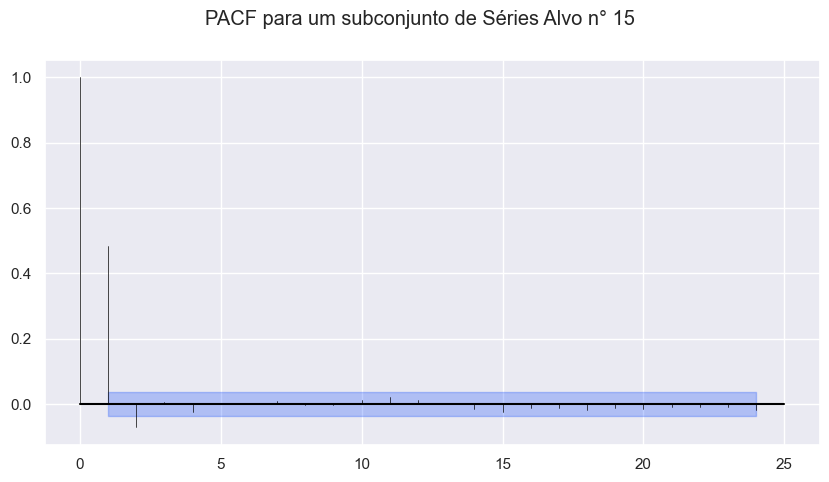

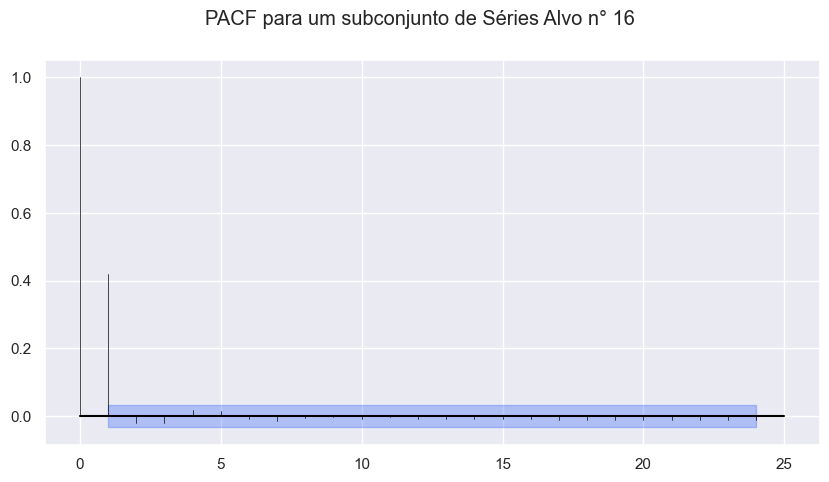

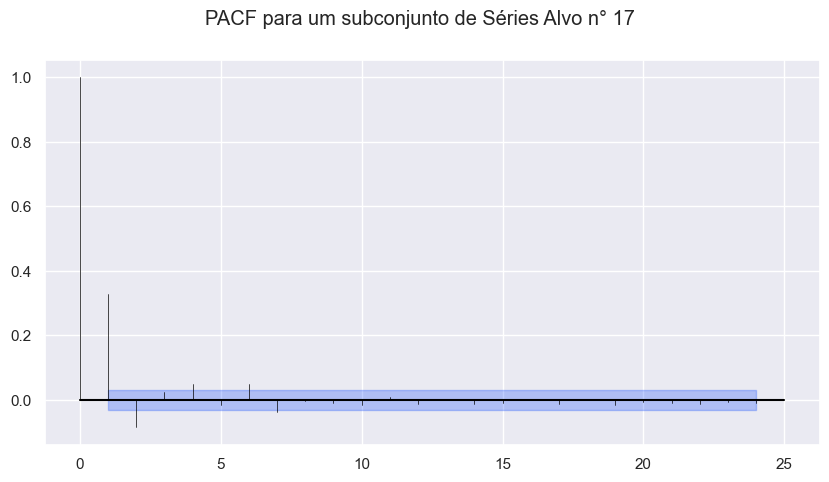

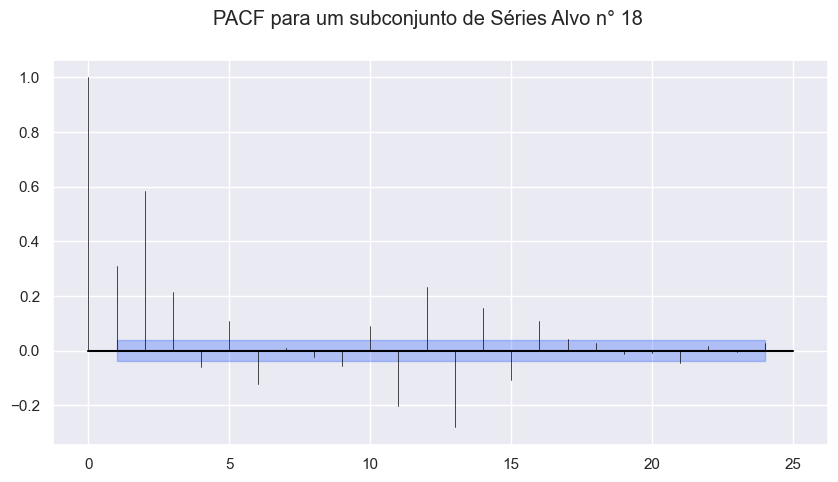

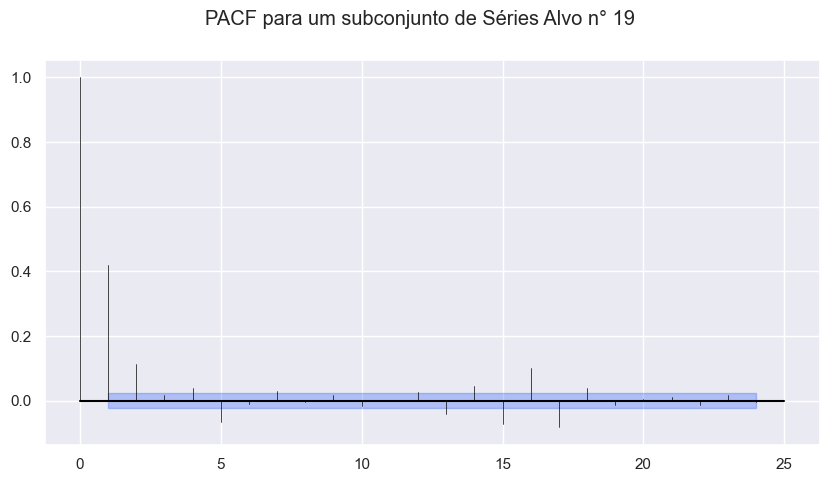

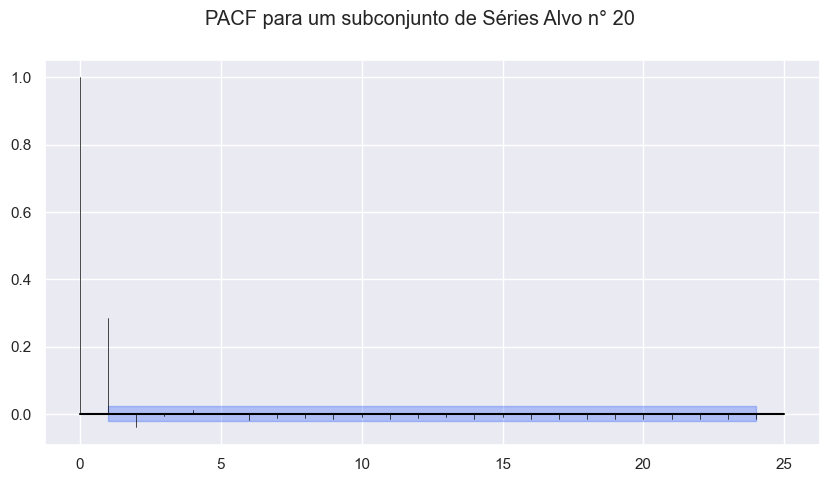

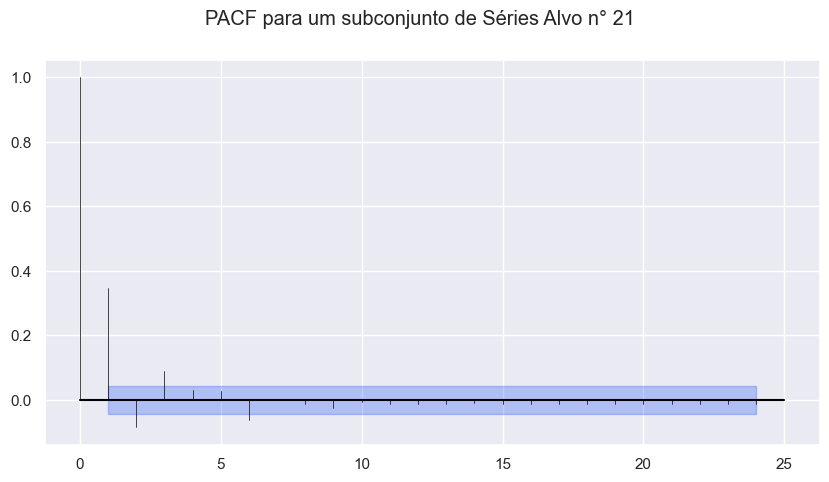

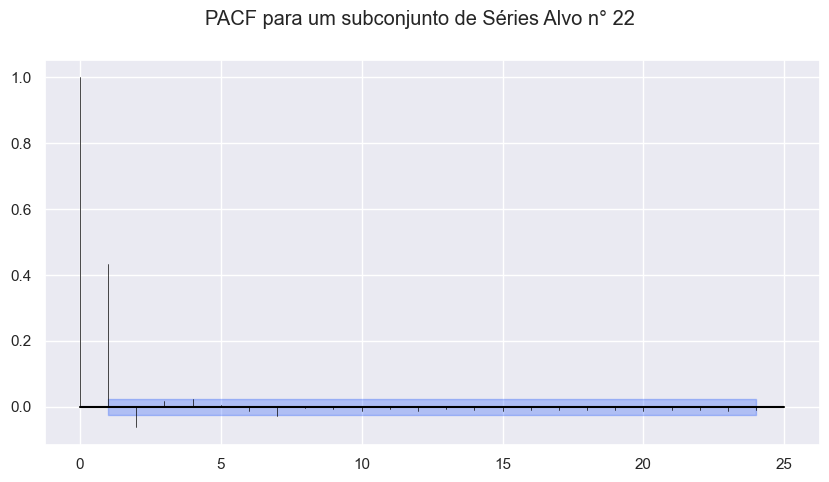

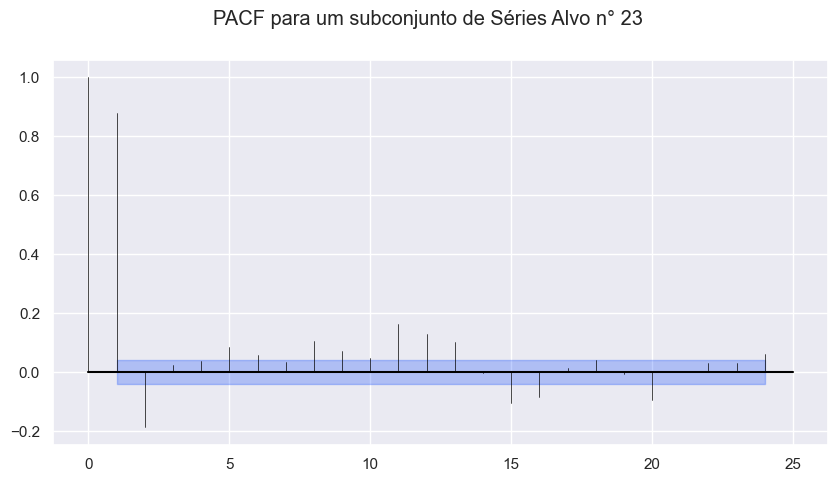

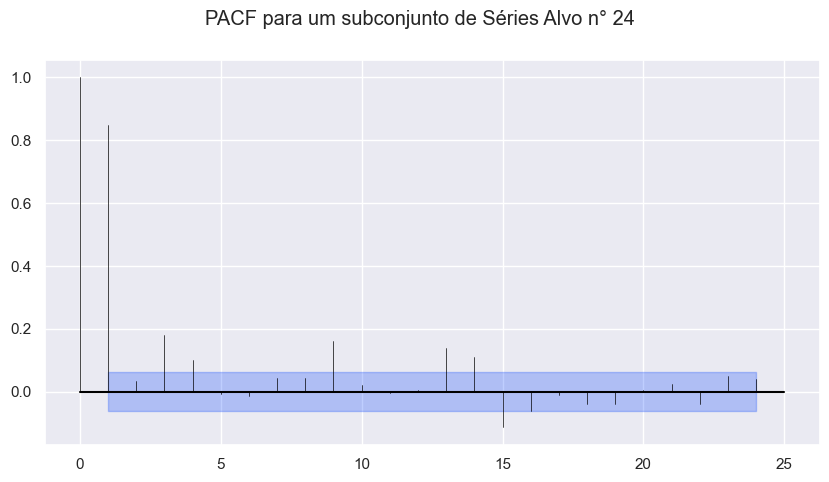

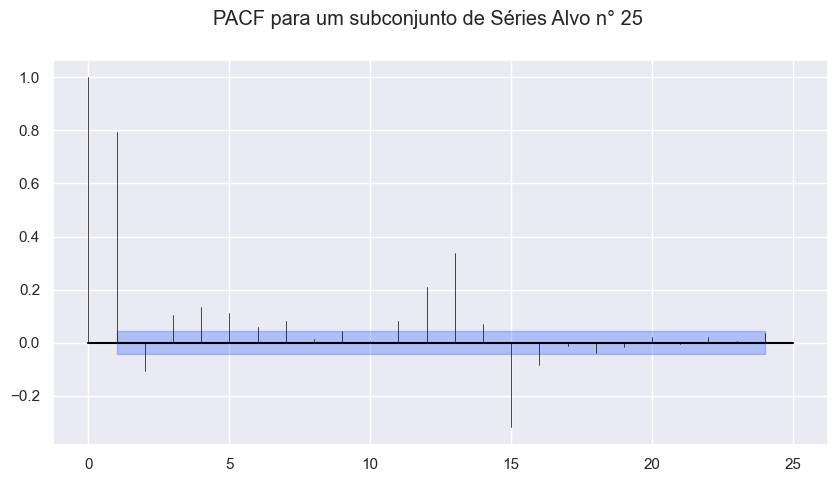

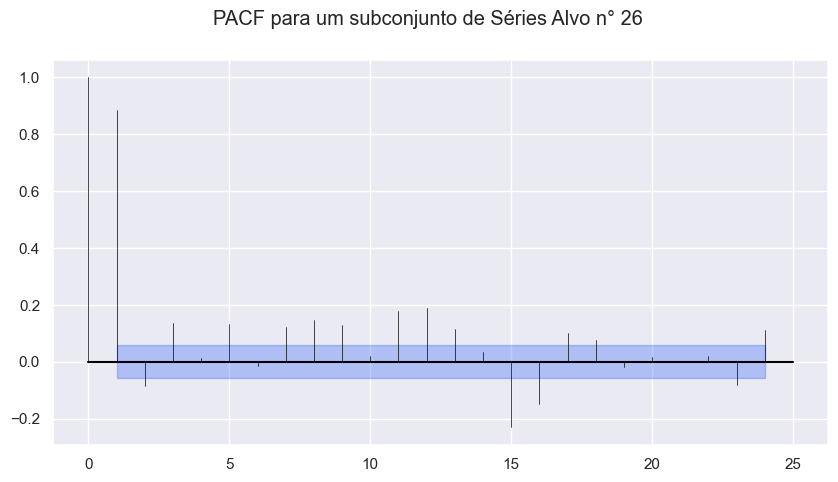

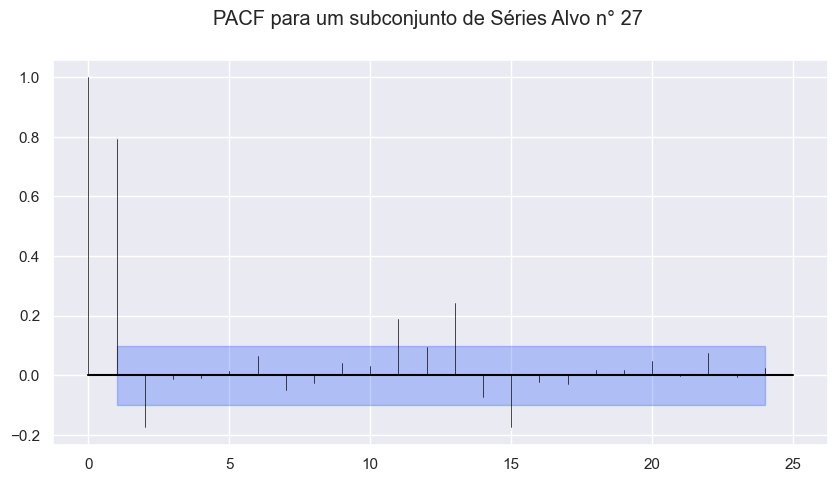

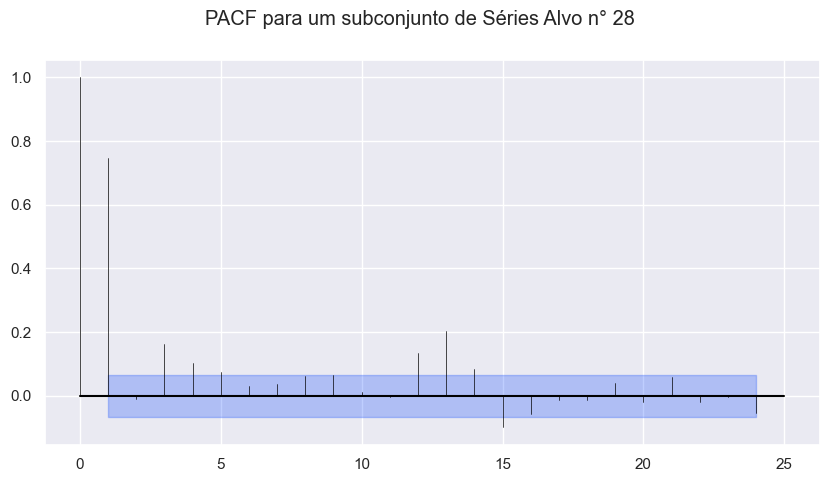

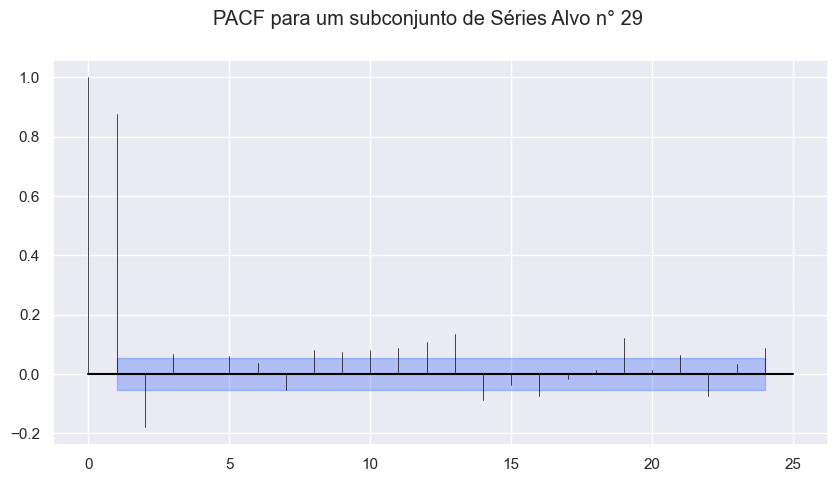

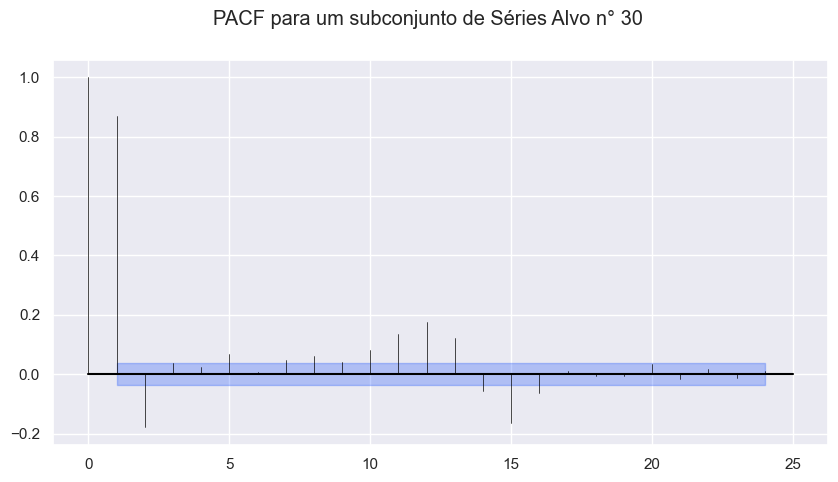

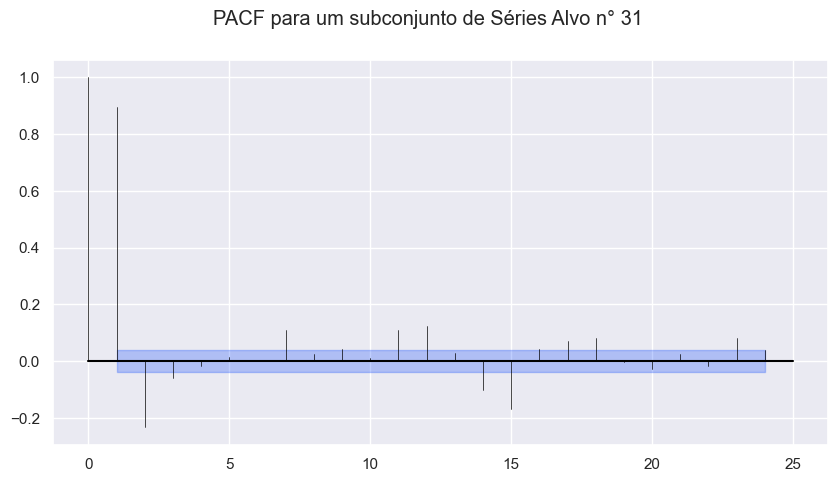

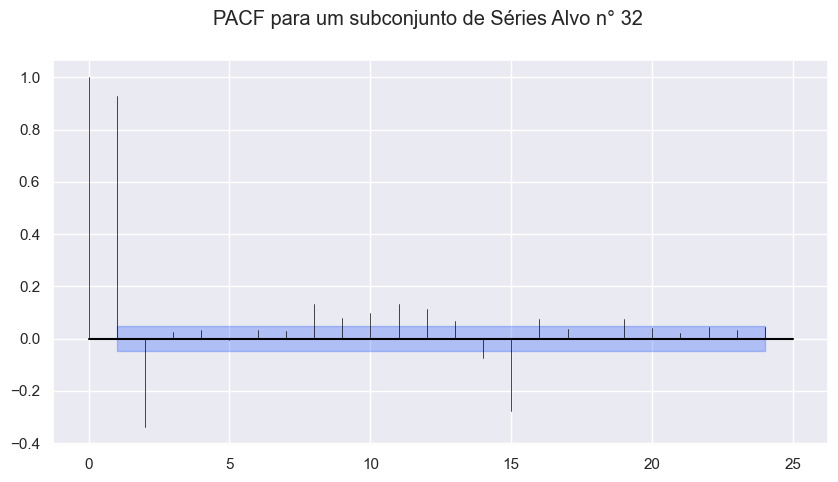

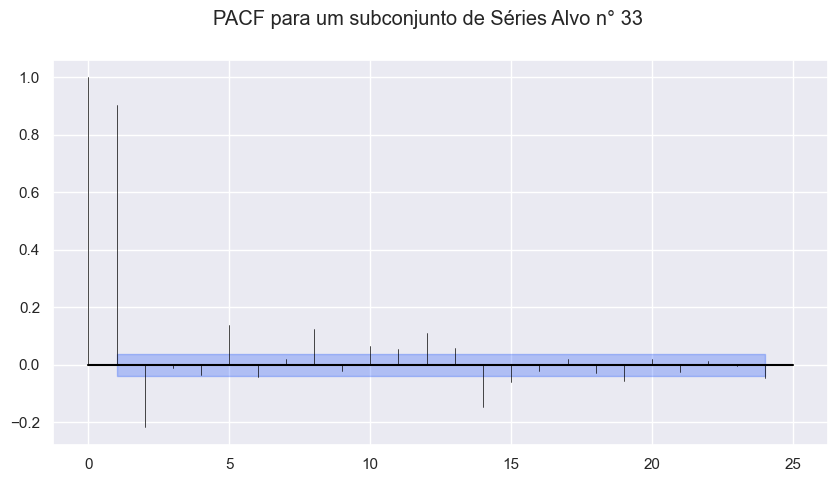

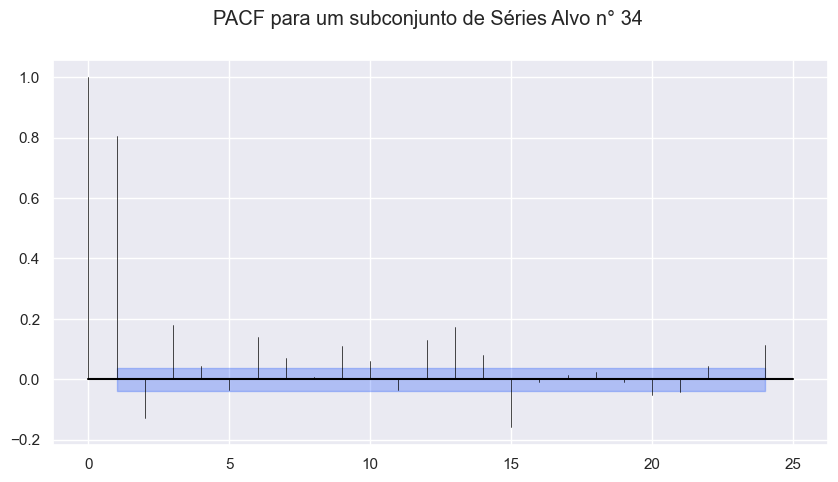

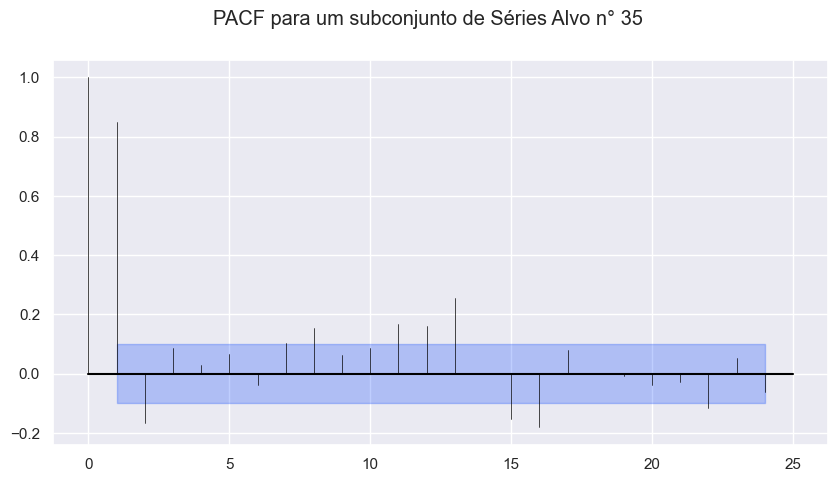

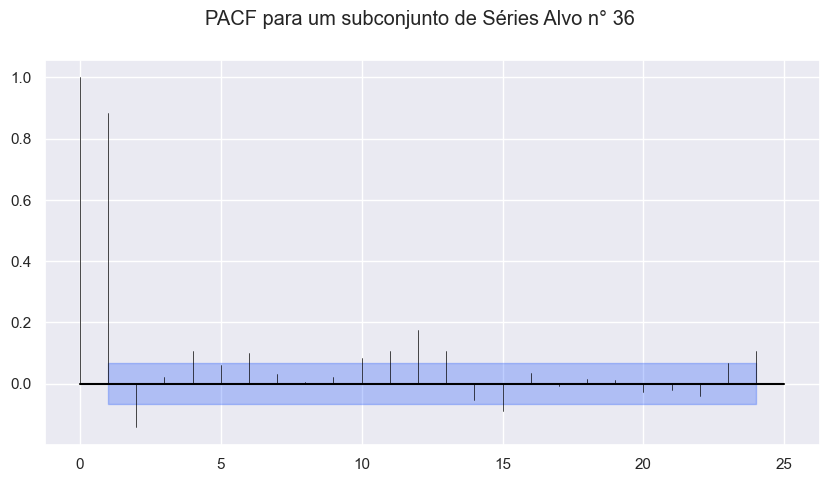

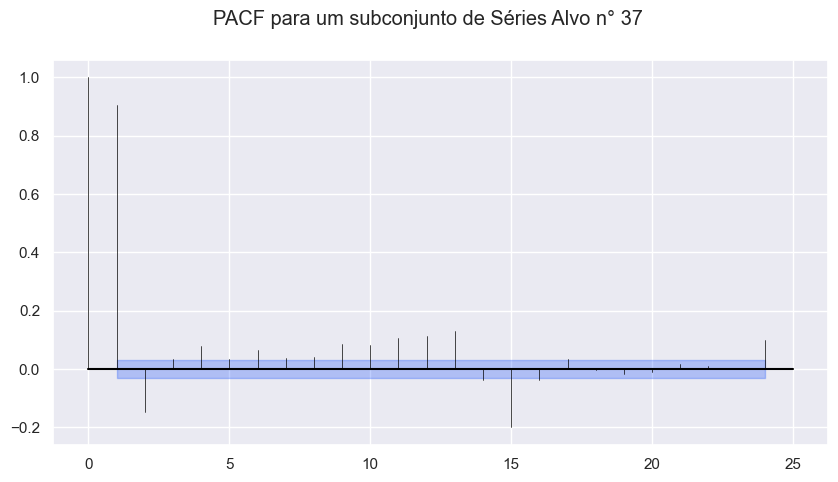

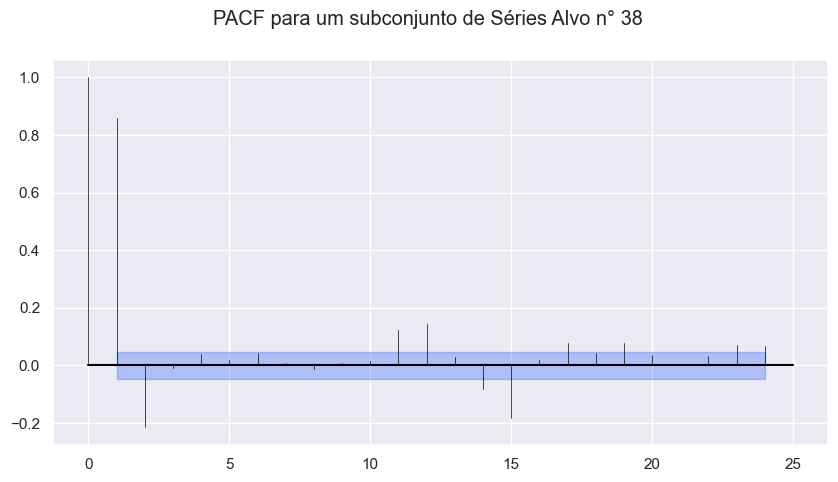

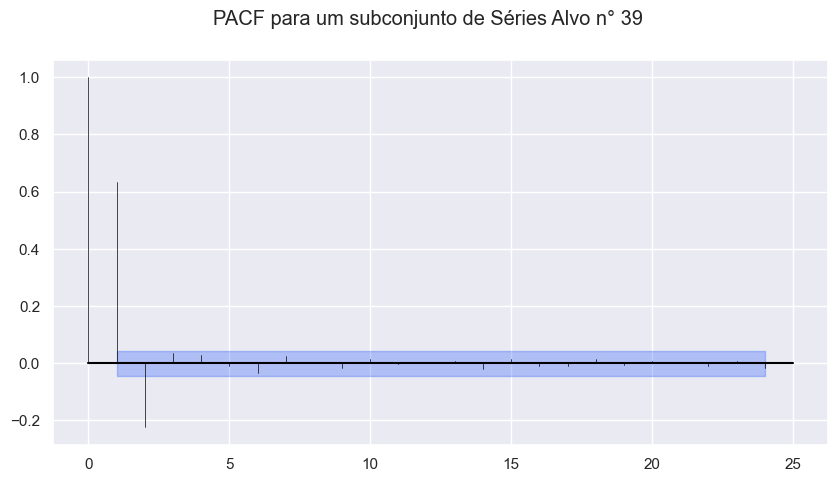

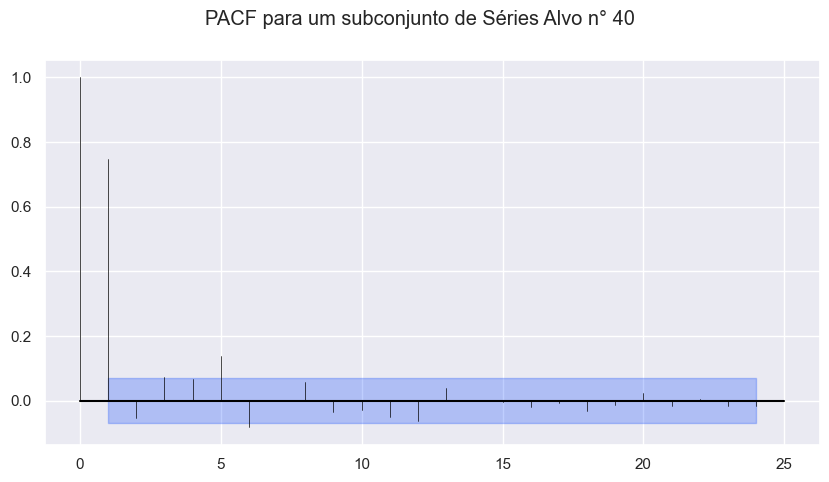

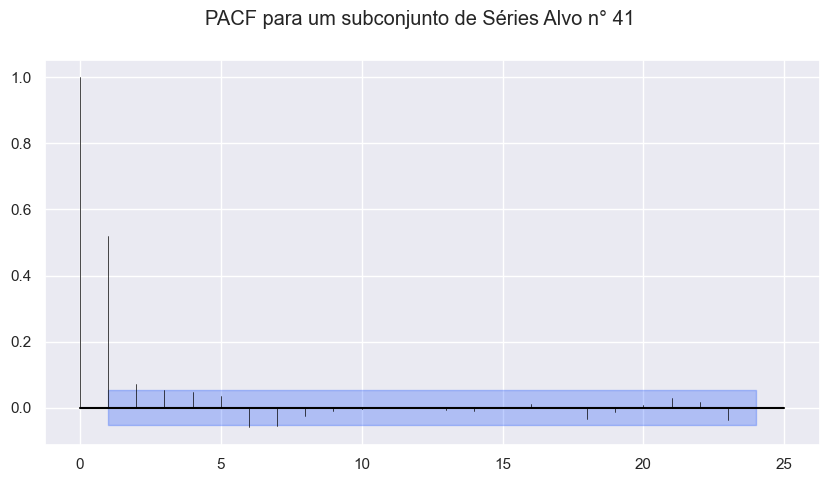

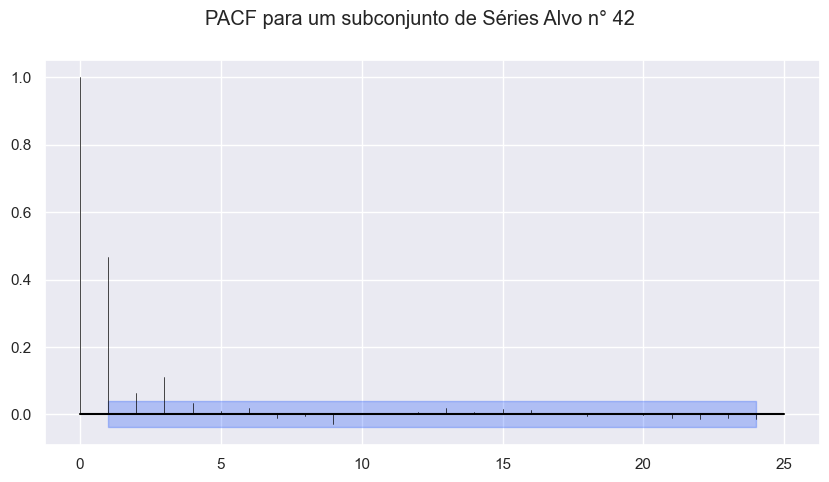

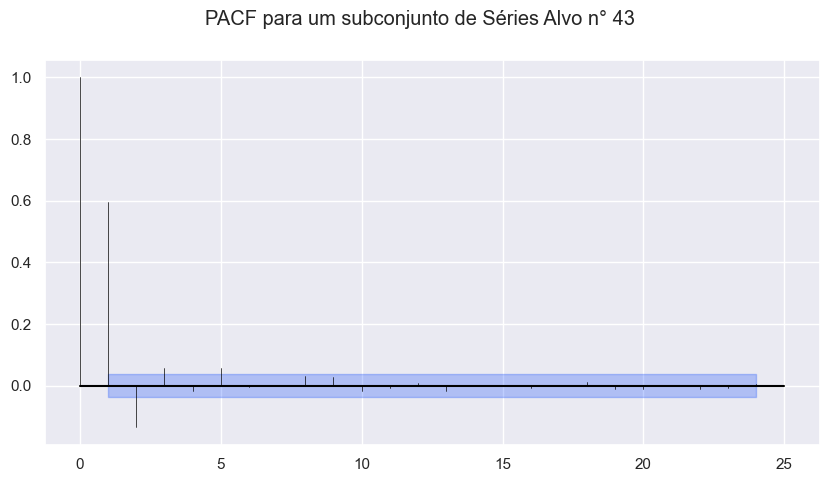

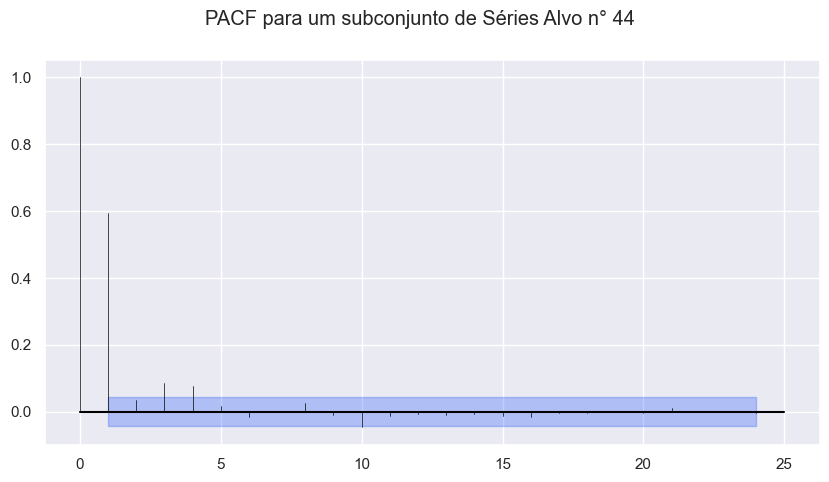

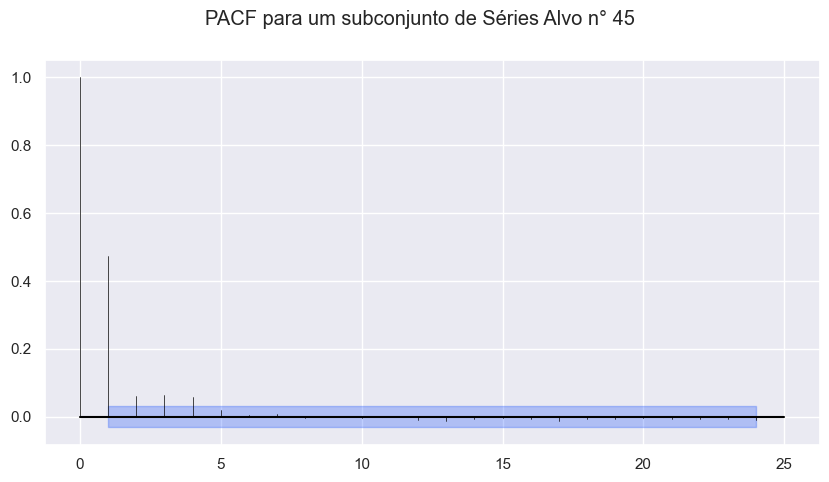

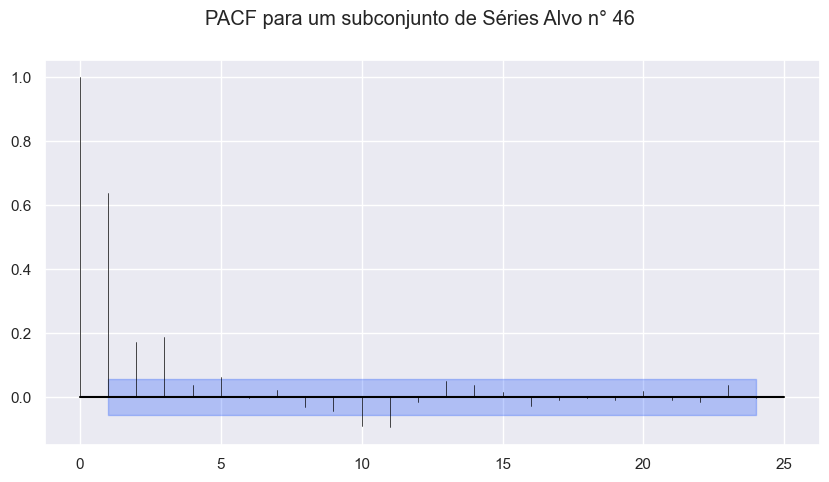

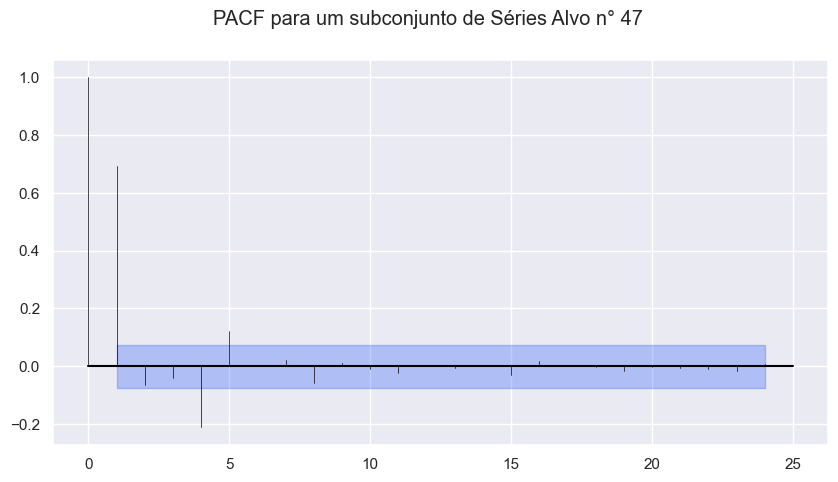

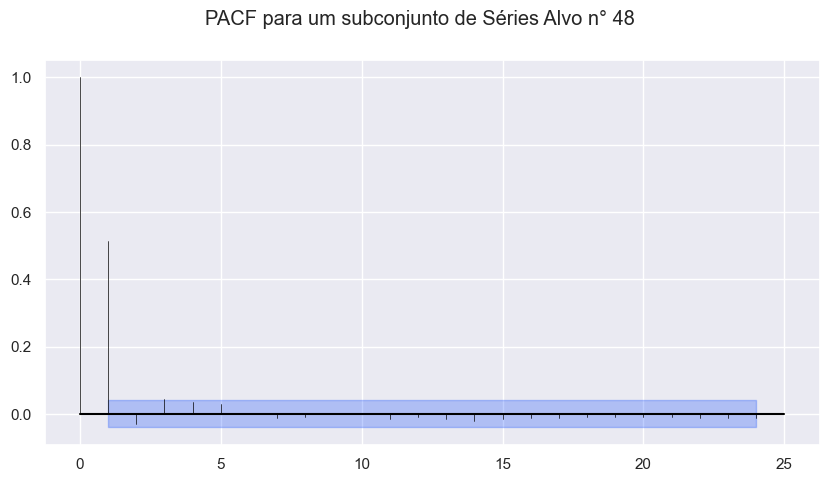

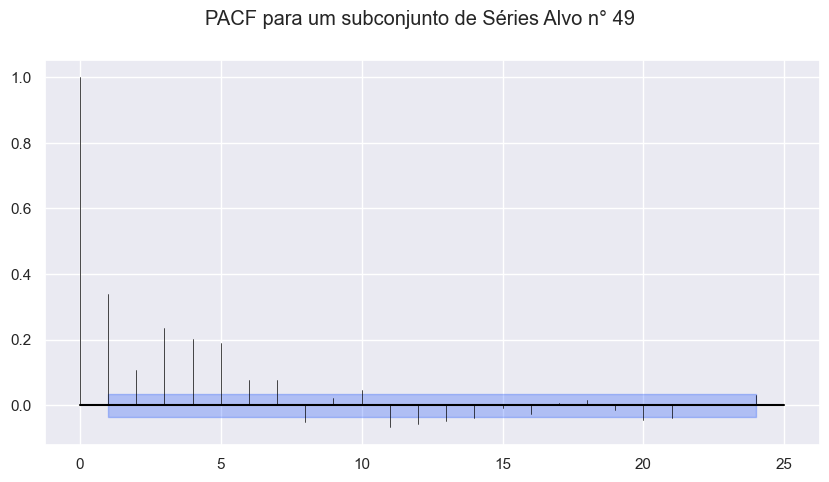

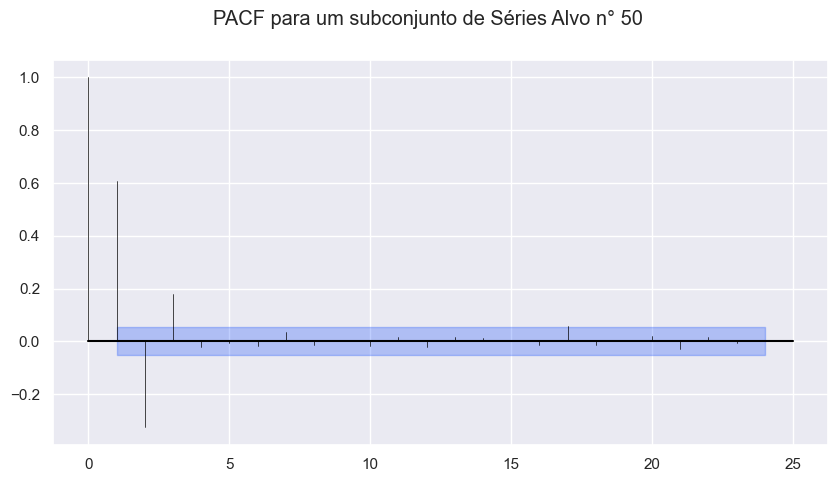

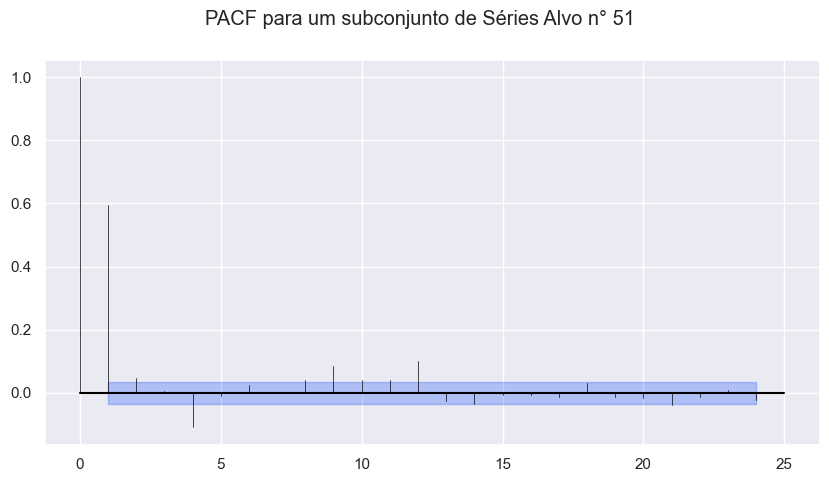

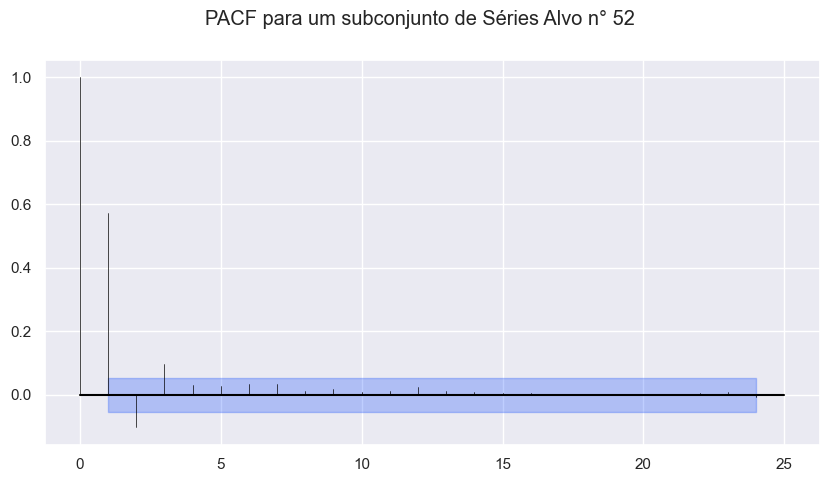

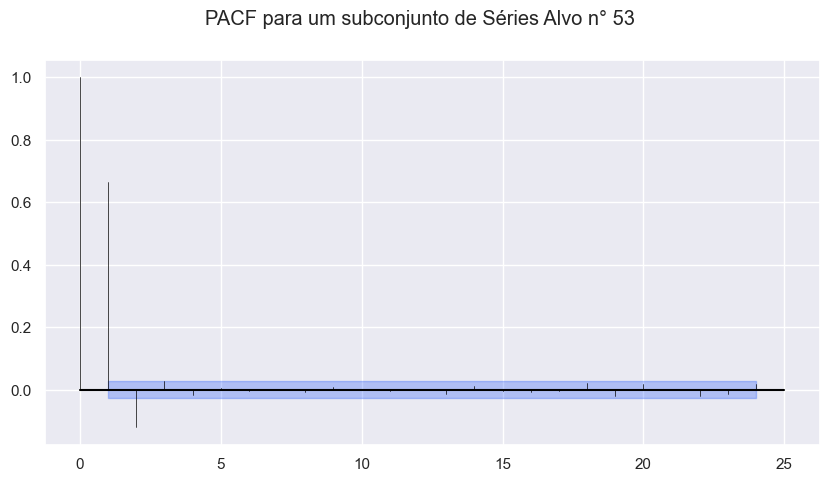

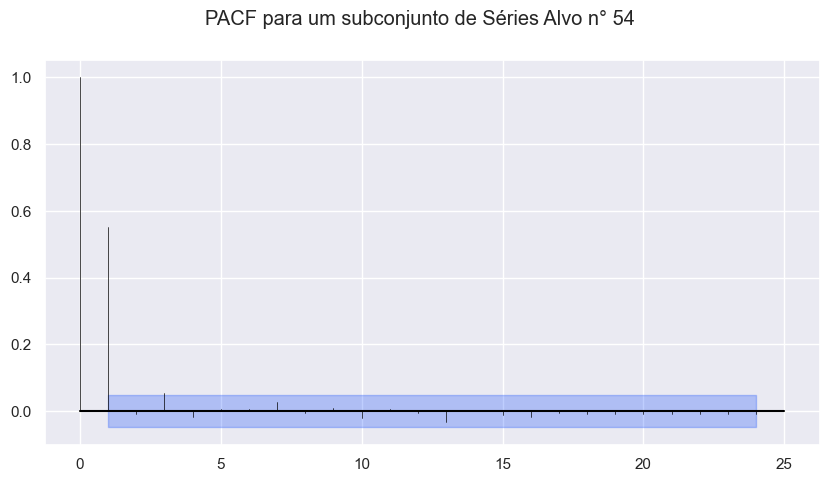

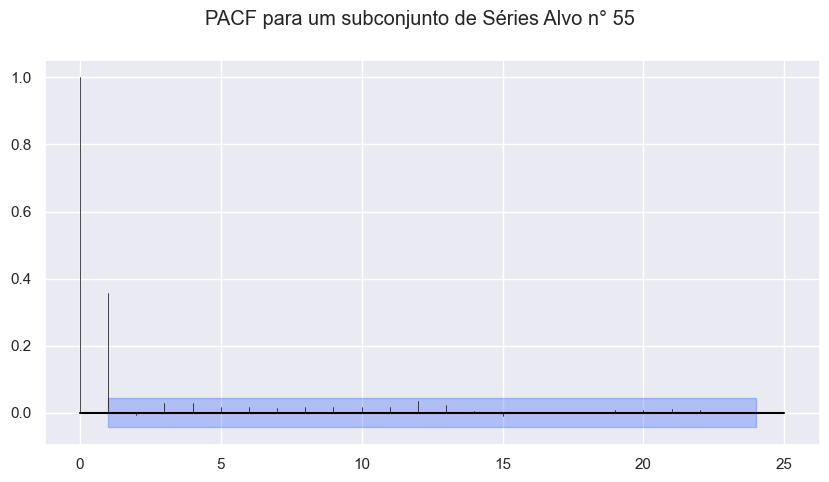

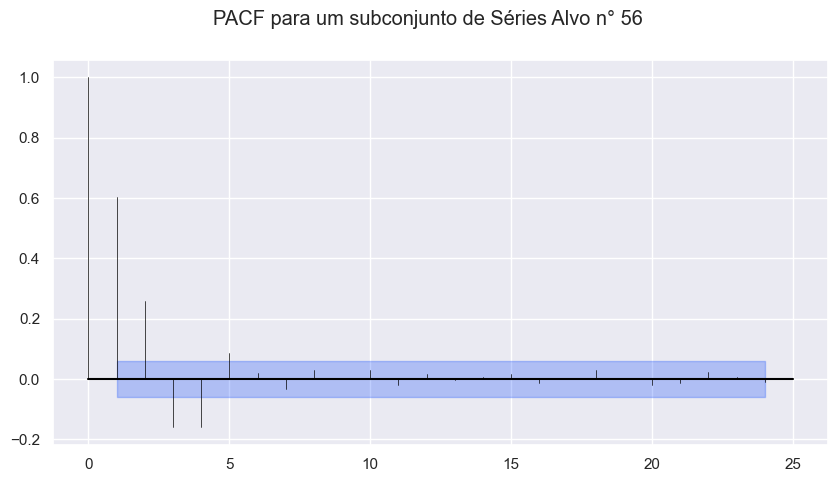

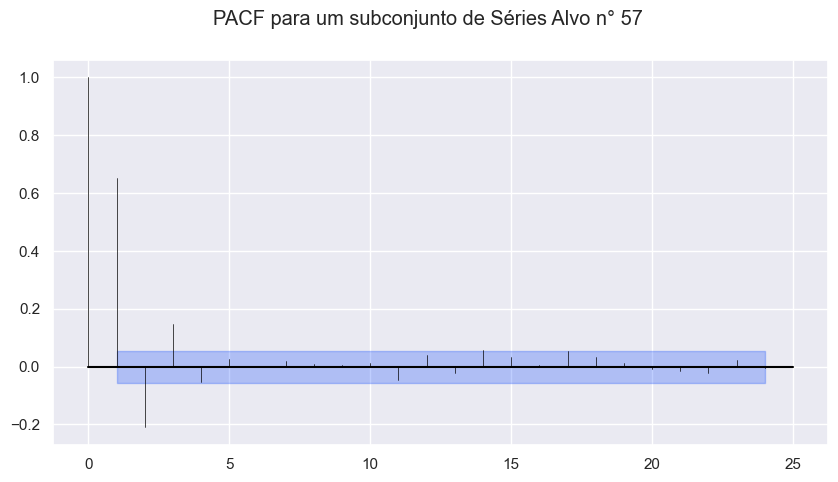

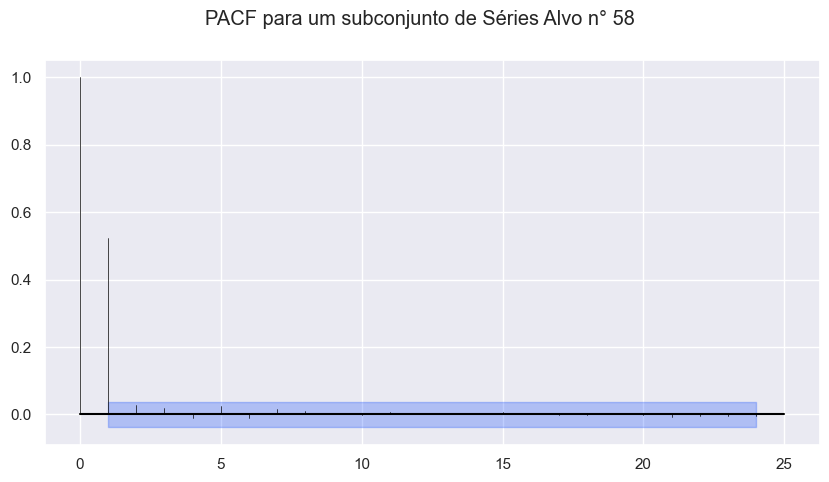

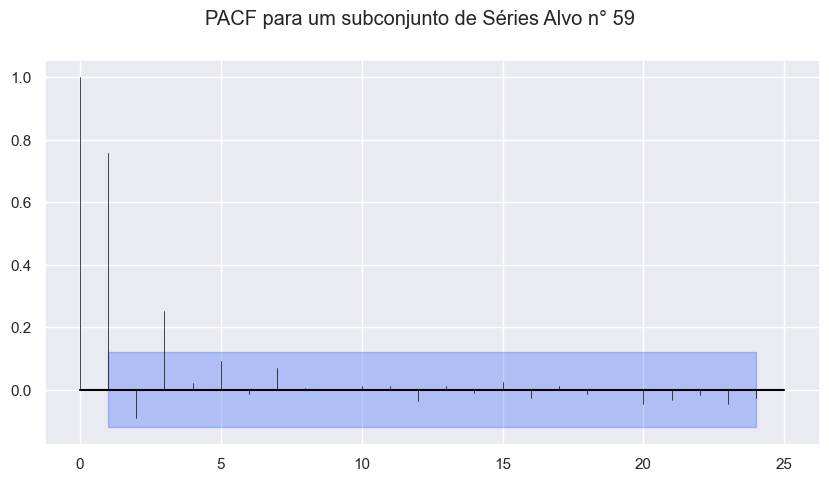

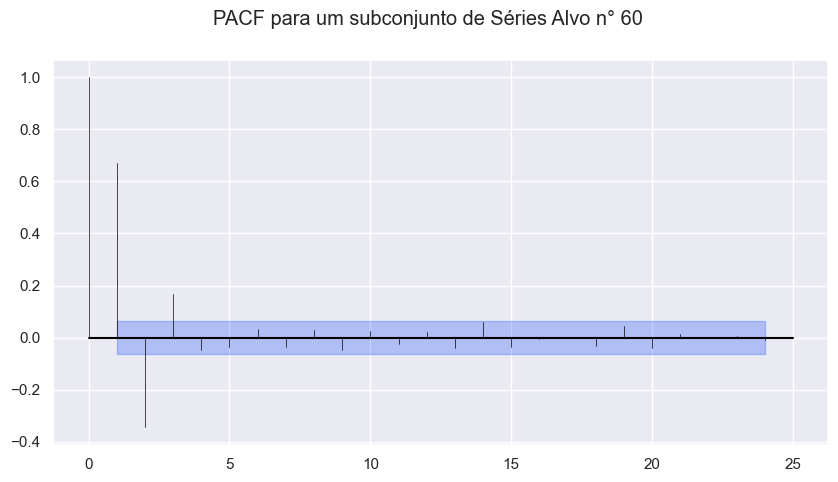

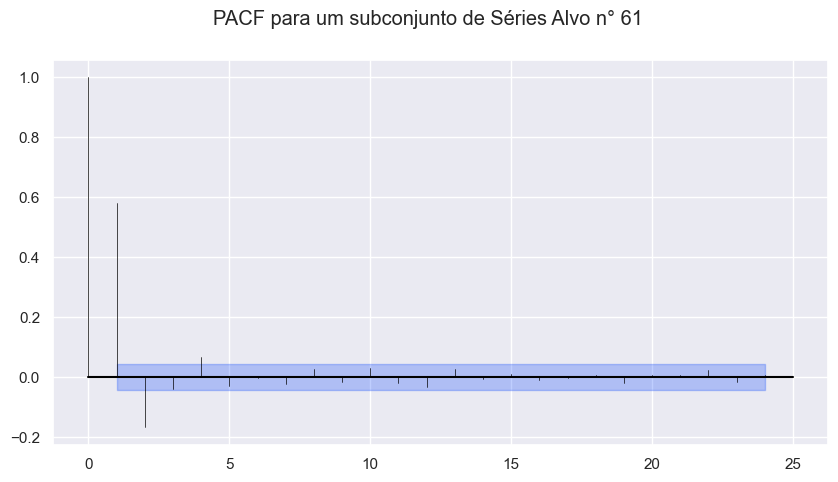

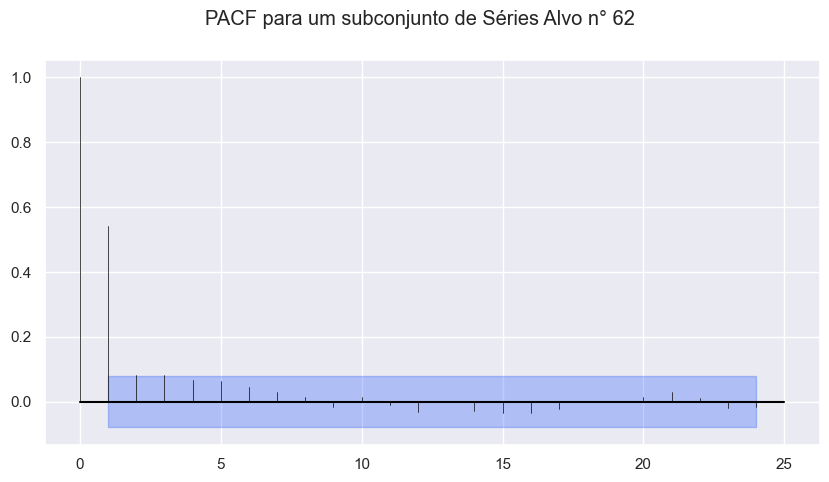

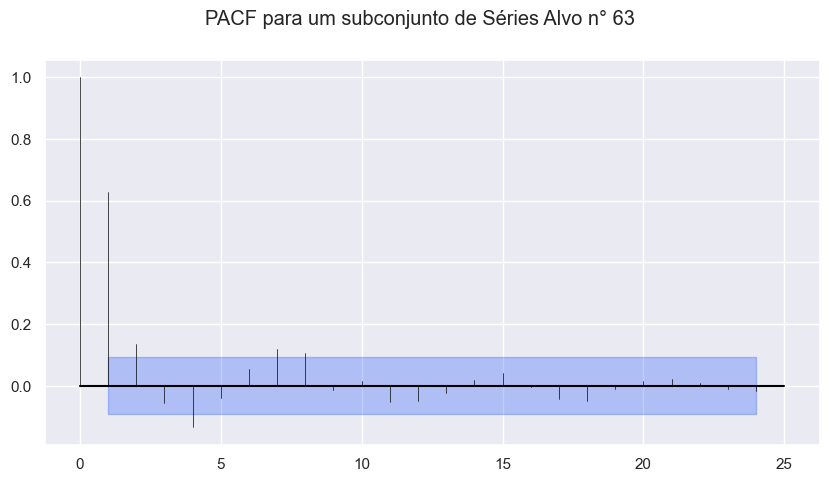

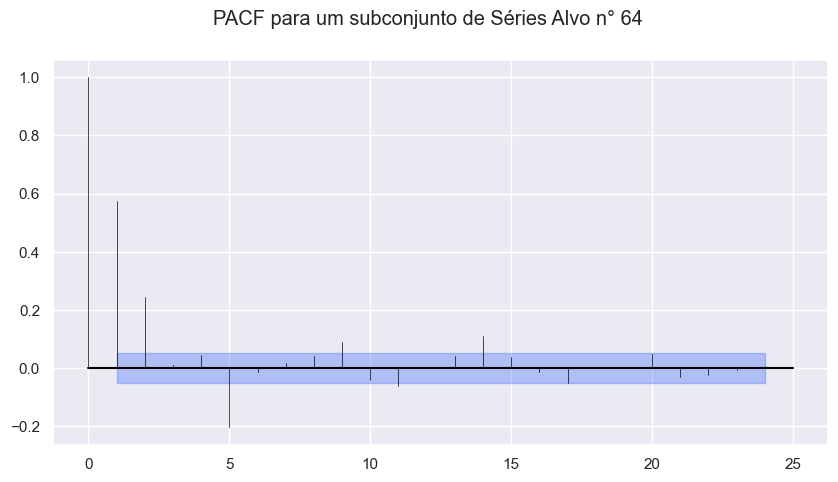

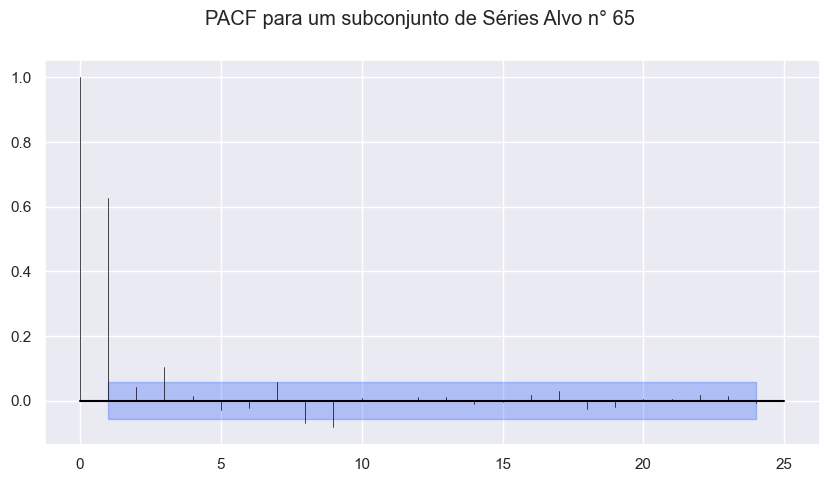

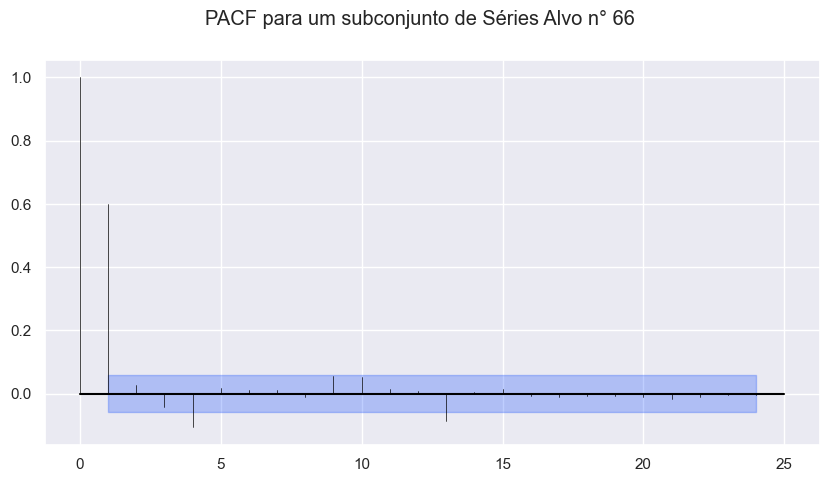

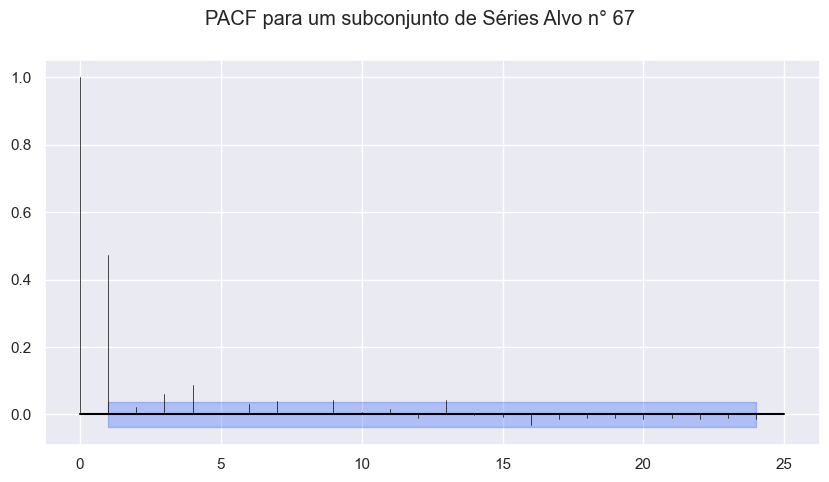

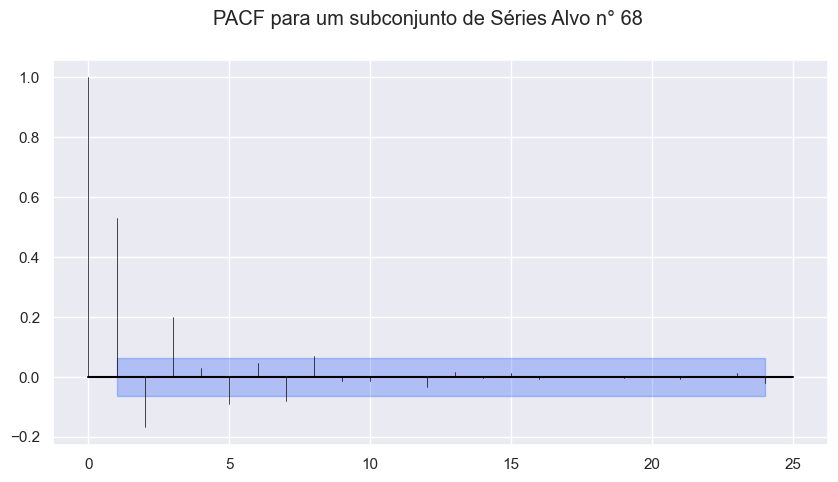

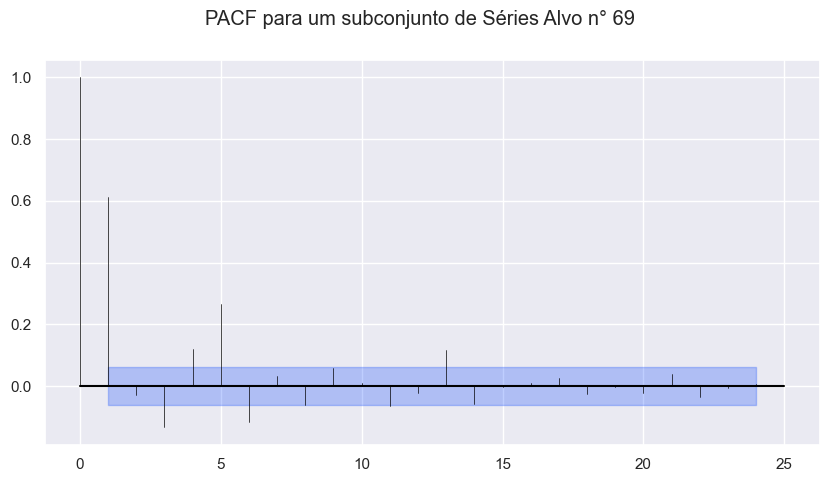

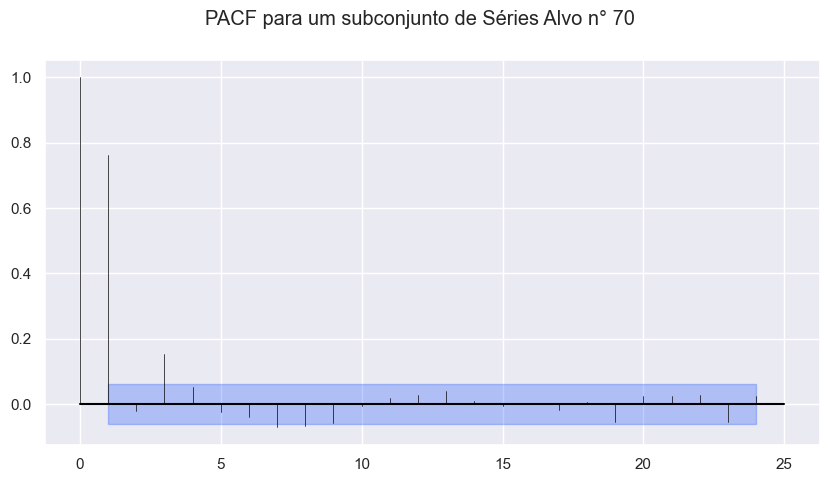

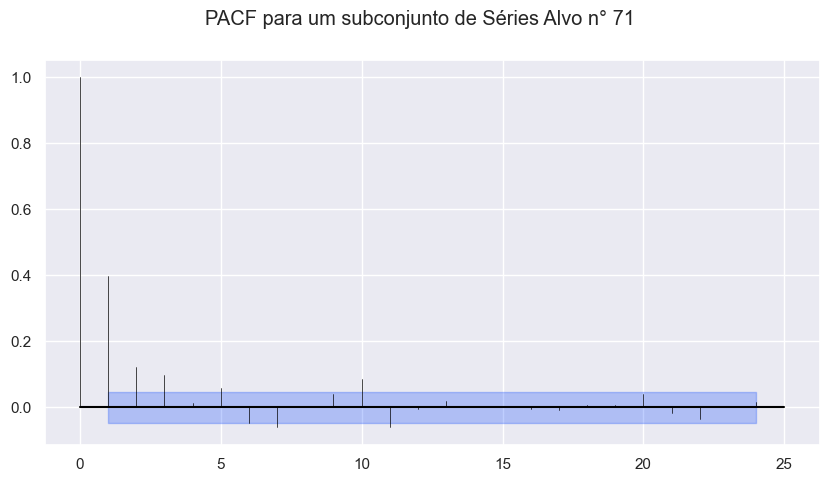

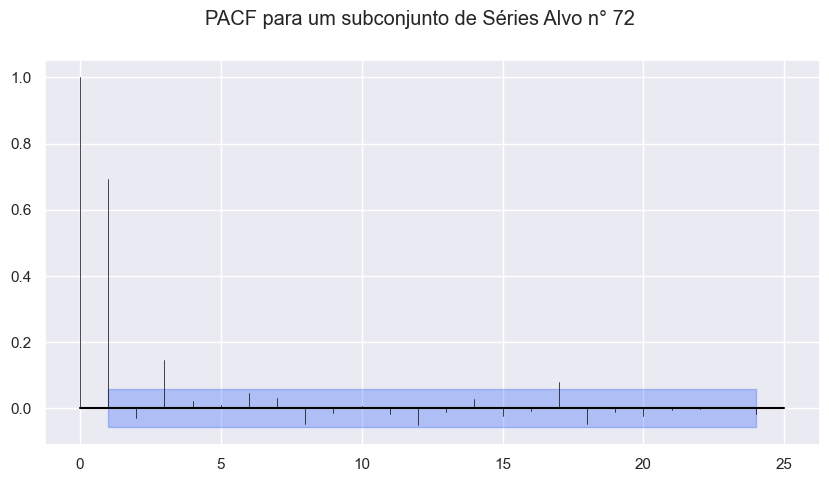

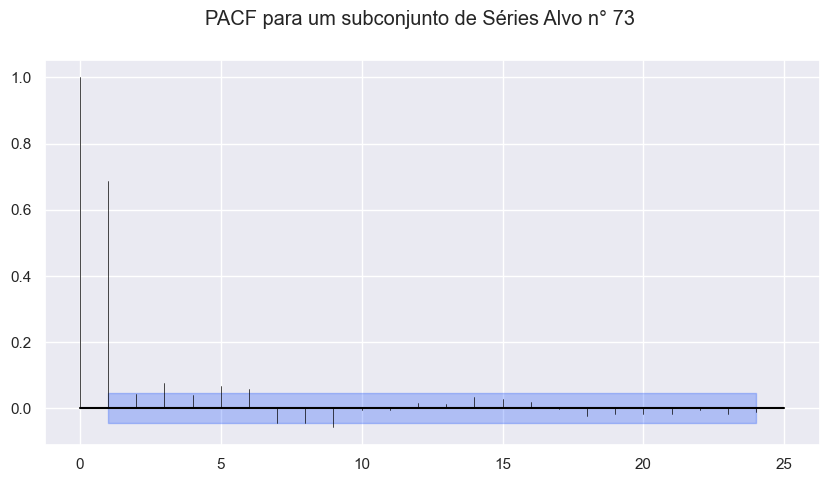

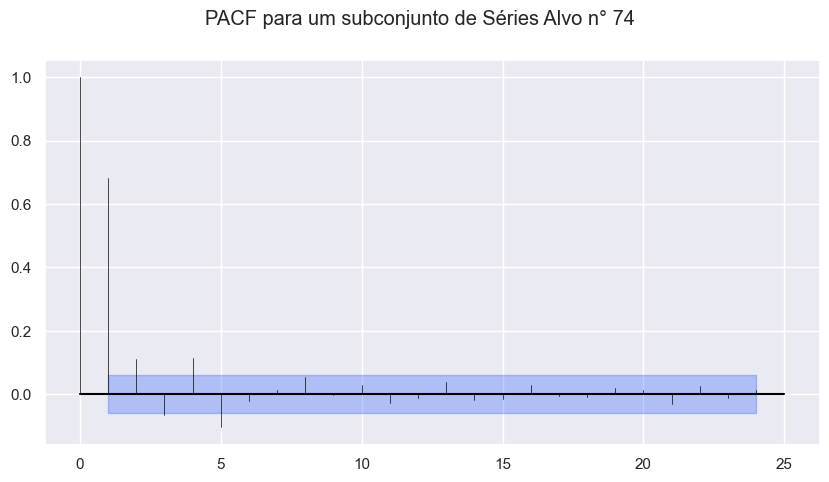

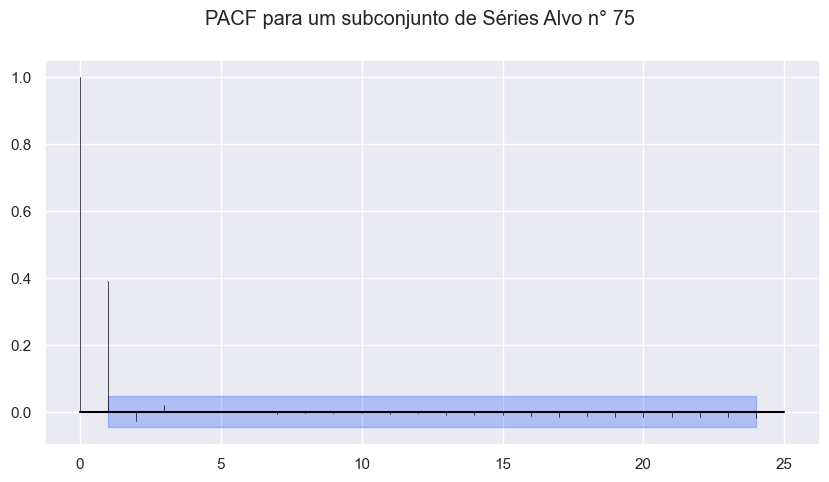

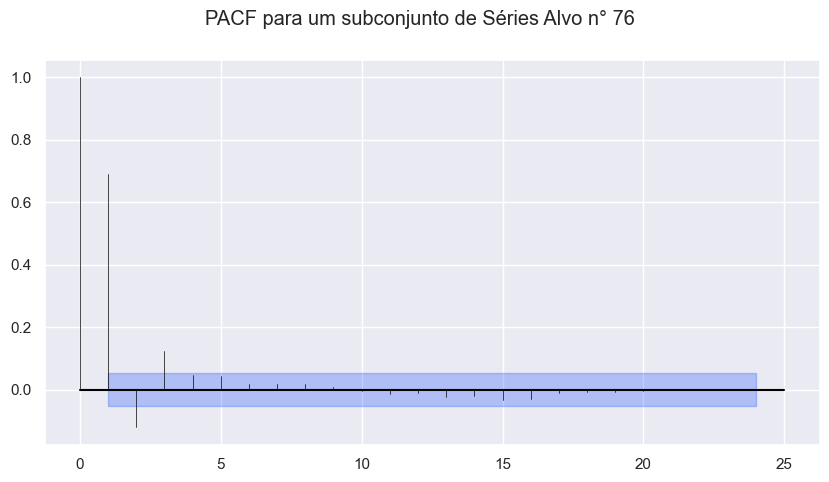

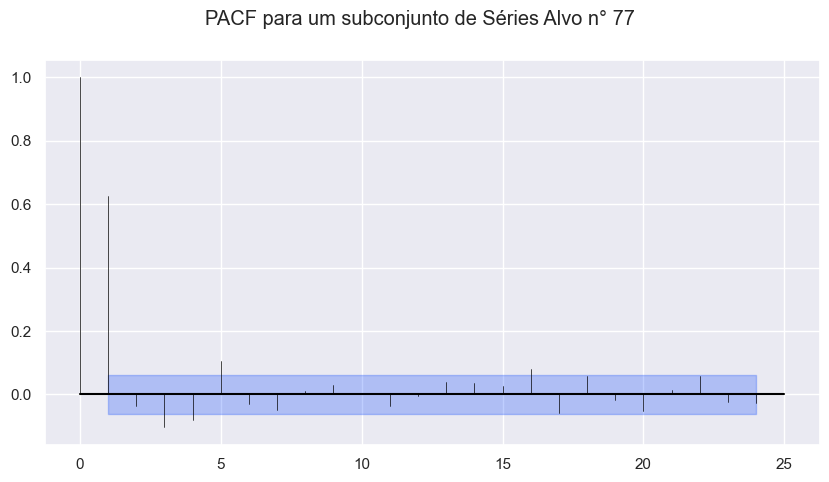

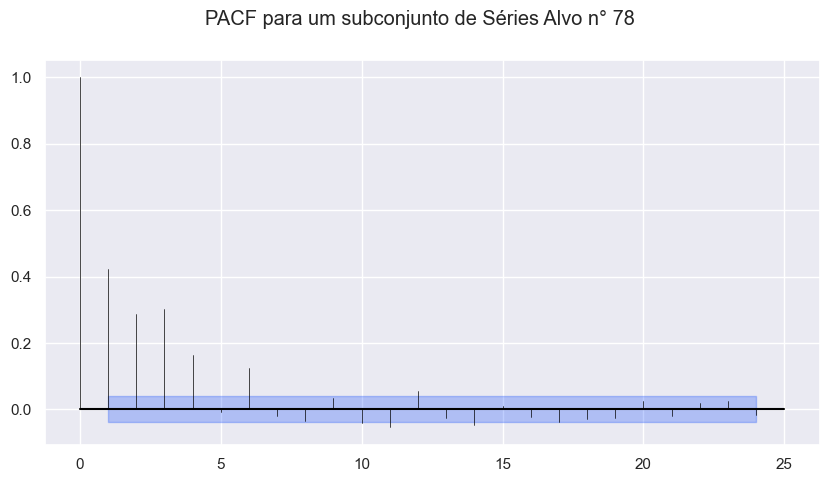

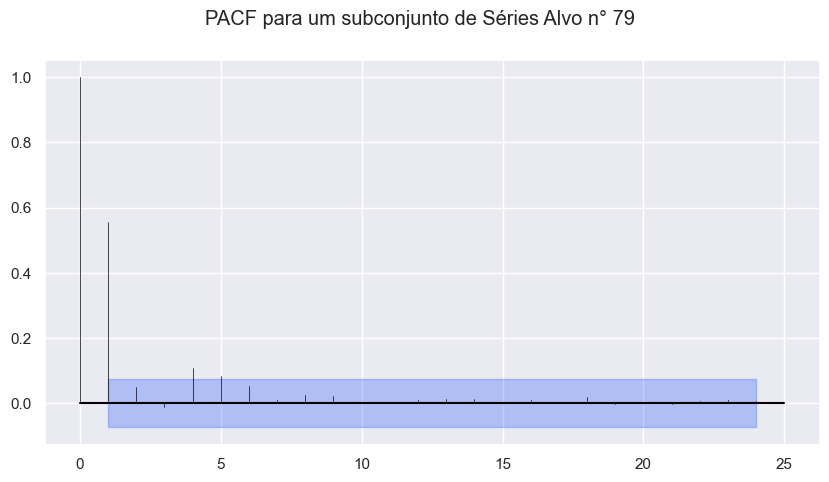

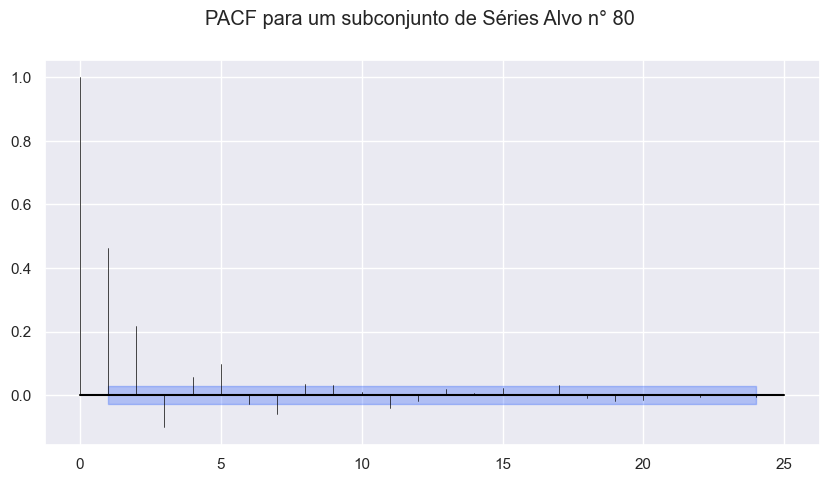

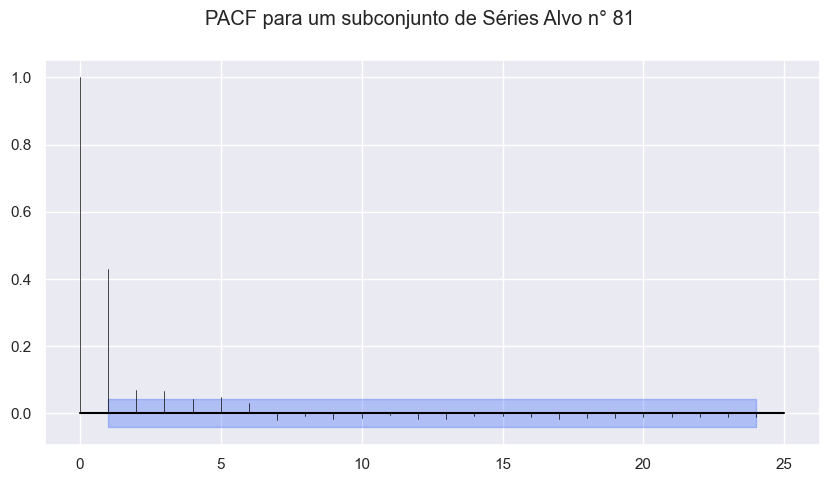

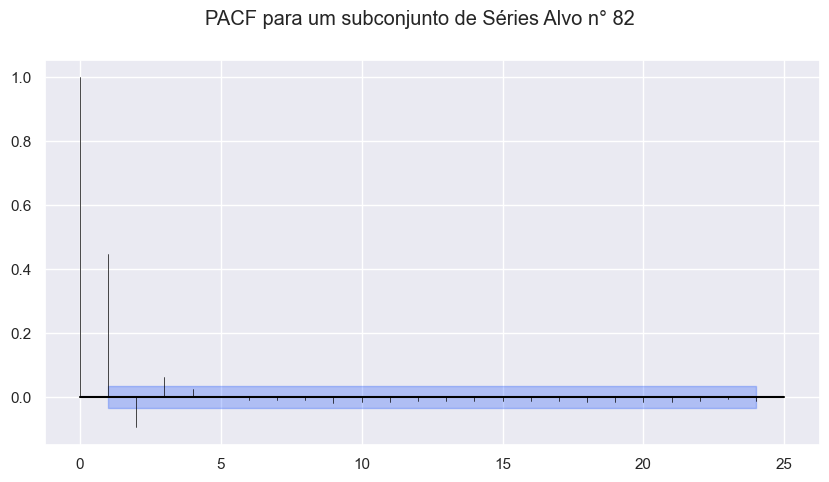

In [83]:
for idx, serie in enumerate(all_targets):
    plot_pacf(serie, m=None, max_lag=24, alpha=0.05);
    plt.suptitle(f"PACF para um subconjunto de Séries Alvo n° {idx}")

## Cross Correlation Function (CCF)

In [82]:
# Supondo que all_targets_raw[0] e all_past_covariates_raw[0]['RSRP'] sejam TimeSeries
# plot_ccf(all_targets_raw[0], all_past_covariates_raw[0]['RSRP'], max_lag=20, mode='correlation')
# plt.show()

# for idx, serie in enumerate(all_targets):
#     plot_ccf(serie, ,m=None, max_lag=24, alpha=0.05);
#     plt.suptitle(f"CCF para um subconjunto de Séries Alvo n° {idx}")

## FFT (Fast Fourier Transform)

Transforma o sinal para o domínio da frequência e ajuda a encontrar ciclos dominantes.

In [30]:
# Série em array
# for serie in processed_series:
#     detect_periodicity_fft(serie)

## Decomposição da Série Temporal

In [31]:
# for serie in processed_series:
#     stl = STL(serie.pd_series(), period=60)  # usa o período estimado
#     result = stl.fit()
#     result.plot();

# Treinando modelo

In [32]:
# Just checking
processed_series[0].pd_dataframe().isna().sum()

component
DL_bitrate    0
dtype: int64

In [33]:
series = processed_series[0]
train, test = train_test_split(
    series, test_size=0.1, axis=1
)

<Axes: xlabel='time'>

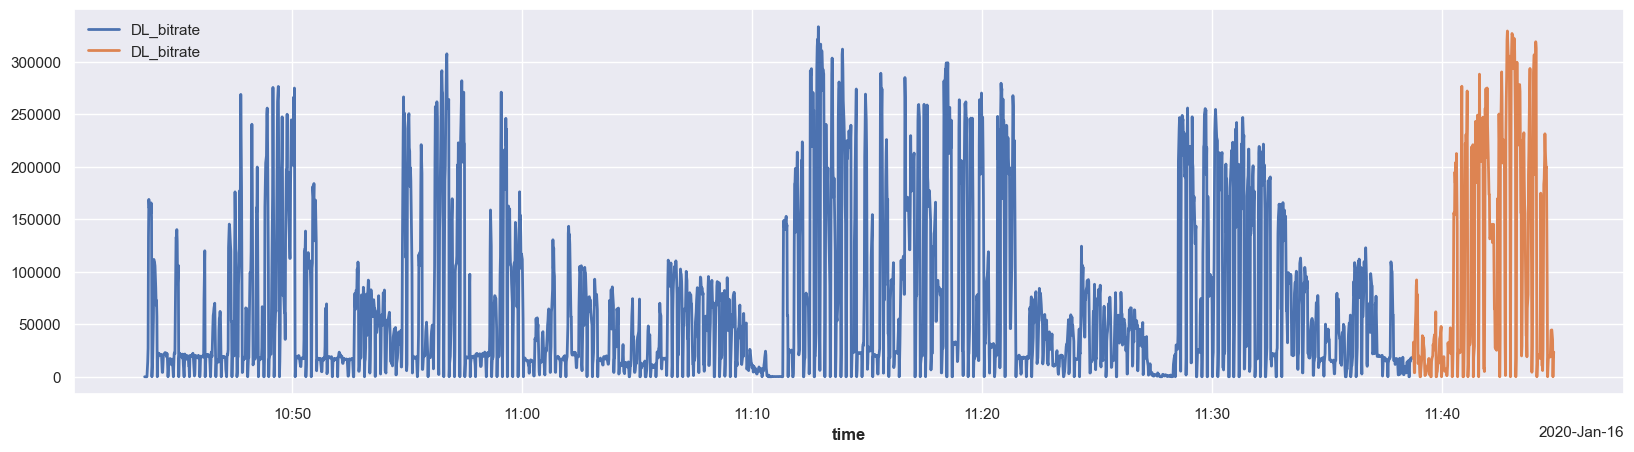

In [34]:
train.plot()
test.plot()

## Naive

In [35]:
series = processed_series[0]

historical forecasts:   0%|          | 0/146 [00:00<?, ?it/s]

MAE: 61842.93607305937
RMSE: 93284.25602525494


<Axes: xlabel='time'>

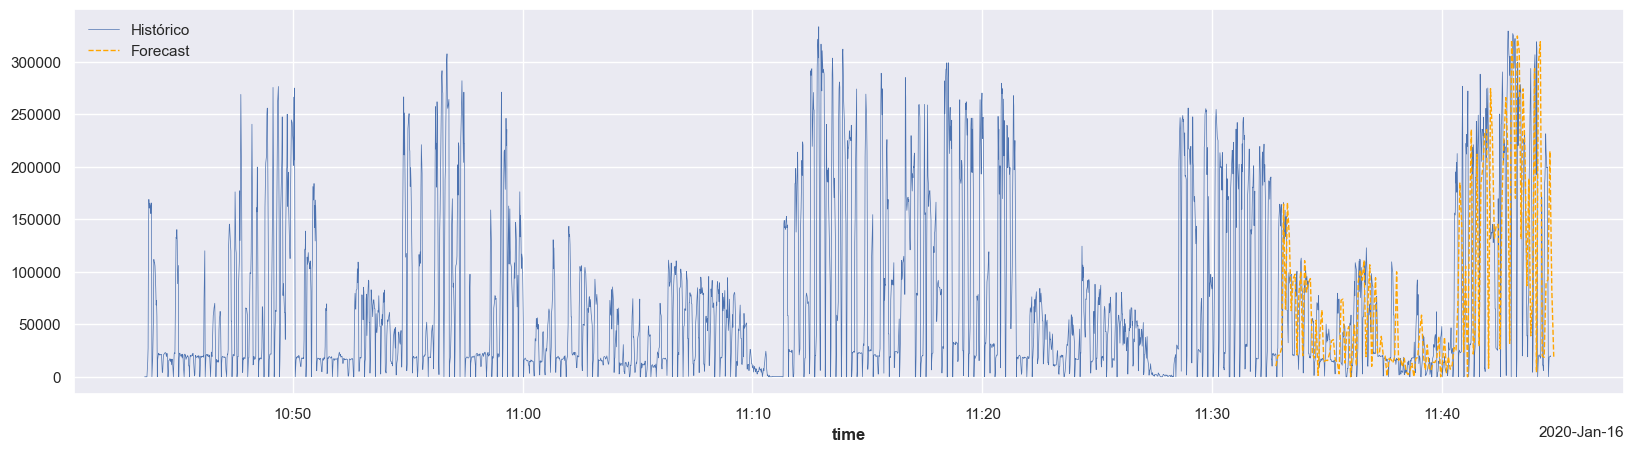

In [37]:
forecast_horizon = 10
stride = 5

naive_ma = NaiveMovingAverage()

forecast = naive_ma.historical_forecasts(
    series,
    start=0.8,             # ou uma timestamp, ou índice exato
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,         # ou False, dependendo do modelo
    verbose=True
)

# Concatenar ao longo do tempo (eixo 0)
forecast_series = concatenate(forecast, axis=0)

# Interseção com ground truth
ground_truth = series.slice_intersect(forecast_series)

# Métricas
print("MAE:", mae(ground_truth, forecast_series))
print("RMSE:", rmse(ground_truth, forecast_series))
# print("MAPE:", mape(ground_truth, forecast_series))

# Plot histórico
series[:-forecast_horizon].plot(label="Histórico", lw=0.5)

# # Plot Ground Truth (últimos forecast_horizon pontos reais)
# series[forecast_horizon:].plot(label="Ground Truth", lw=1, color="blue")

# Plot Forecast
forecast.plot(label="Forecast", lw=1, linestyle="--", color="orange")

## Exponential Smoothing

In [38]:
from darts.utils.utils import ModelMode, SeasonalityMode

### No Trend and No Seasonality

In [39]:
series = processed_series[0]

AIC: 62162.207471086724
MAE: 64688.869299291146
RMSE: 103326.2080875398


<Axes: xlabel='time'>

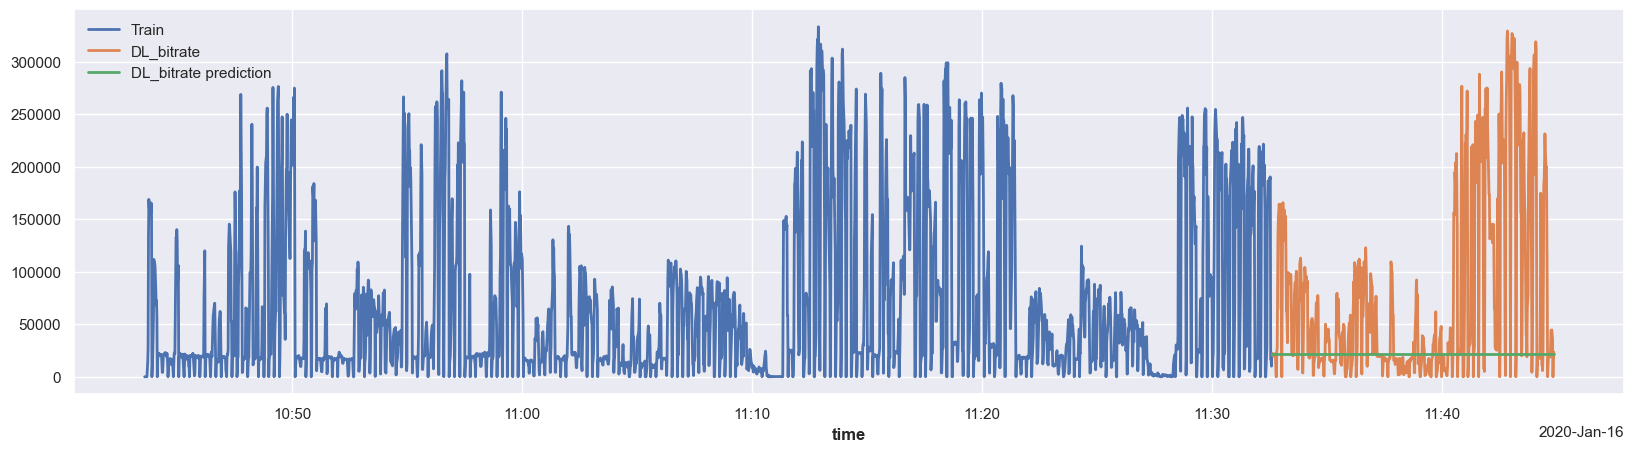

In [42]:
es_model = ExponentialSmoothing(seasonal=ModelMode.NONE, trend=SeasonalityMode.NONE)

train, test = train_test_split(
    series, test_size=0.2, axis=1
)
es_model.fit(train)
print(f"AIC: {es_model.model.aic}")
y_pred = es_model.predict(len(test)).with_columns_renamed("DL_bitrate", "DL_bitrate prediction")

# print("MAPE:", mape(test, y_pred))
print("MAE:", mae(test, y_pred))
print("RMSE:", rmse(test, y_pred))

train.plot(label="Train")
test.plot()
y_pred.plot()

### Backtesting

In [43]:
series = processed_series[0]

In [44]:
forecast_horizon = 10
stride = 5

es_model = ExponentialSmoothing(seasonal=ModelMode.NONE, trend=SeasonalityMode.NONE)

forecast = es_model.historical_forecasts(
    series,
    start=0.8,             # ou uma timestamp, ou índice exato
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,         # ou False, dependendo do modelo
    verbose=True
)

historical forecasts:   0%|          | 0/146 [00:00<?, ?it/s]

MAE: 61822.99476256032
RMSE: 93233.92345881148


<Axes: xlabel='time'>

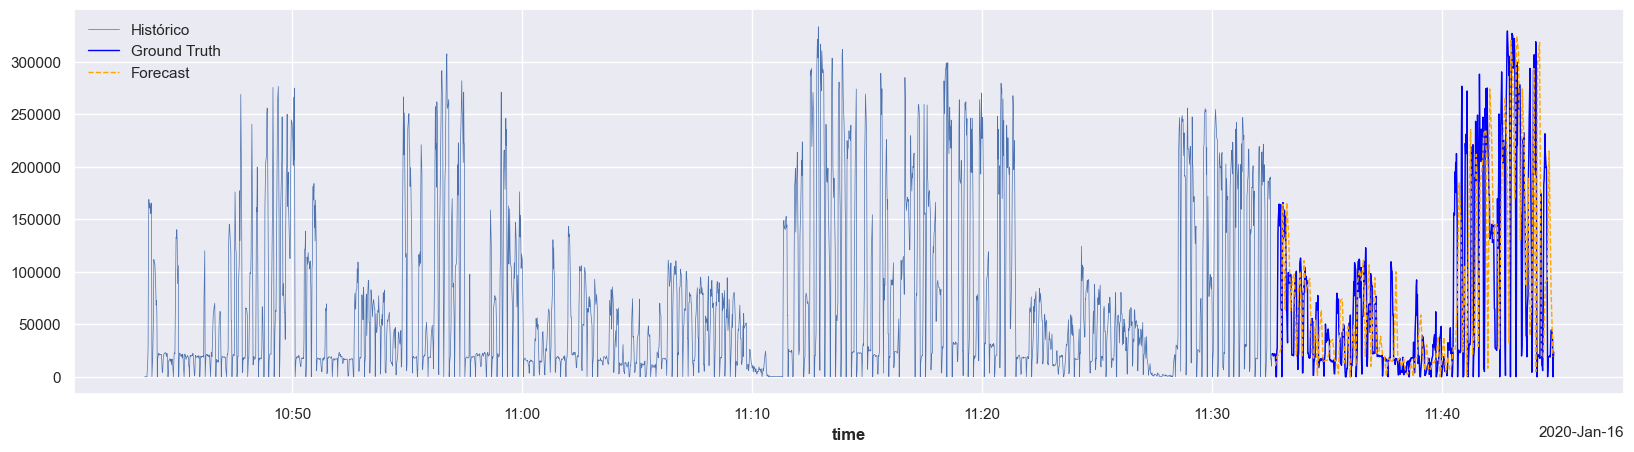

In [45]:
# Concatenar ao longo do tempo (eixo 0)
forecast_series = concatenate(forecast, axis=0)

# Interseção com ground truth
ground_truth = series.slice_intersect(forecast_series)

# Métricas
print("MAE:", mae(ground_truth, forecast_series))
print("RMSE:", rmse(ground_truth, forecast_series))
# print("MAPE:", mape(ground_truth, forecast_series))

# Plot histórico
series[:-forecast_horizon].plot(label="Histórico", lw=0.5)

# Plot Ground Truth (últimos forecast_horizon pontos reais)
test.plot(label="Ground Truth", lw=1, color="blue")

# Plot Forecast
forecast.plot(label="Forecast", lw=1, linestyle="--", color="orange")

### With Trend and Seasonality

In [46]:
series = processed_series[0]

AIC: 62659.866717185825
MAE: 67515.997592618
RMSE: 80359.51182203167


<Axes: xlabel='time'>

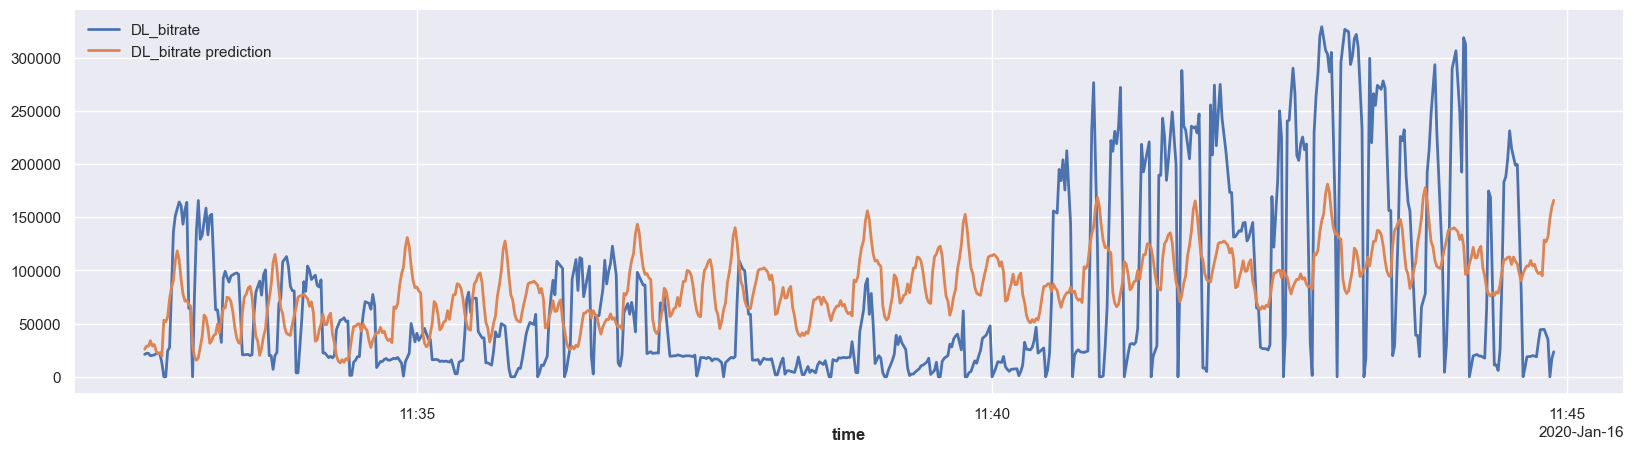

In [48]:
es_model = ExponentialSmoothing(seasonal=ModelMode.ADDITIVE, trend=SeasonalityMode.ADDITIVE, seasonal_periods=60*2)

train, test = train_test_split(
    series, test_size=0.2, axis=1
)
es_model.fit(train)
print(f"AIC: {es_model.model.aic}")
y_pred = es_model.predict(len(test)).with_columns_renamed("DL_bitrate", "DL_bitrate prediction")

# print("MAPE:", mape(test, y_pred))
print("MAE:", mae(test, y_pred))
print("RMSE:", rmse(test, y_pred))

test.plot()
y_pred.plot()

### Only Seasonal Extracted by FFT

In [49]:
series = processed_series[0]
seasonal_periods=221

AIC: 62803.43601235833
MAE: 81445.00255245493
RMSE: 113039.42157236776


<Axes: xlabel='time'>

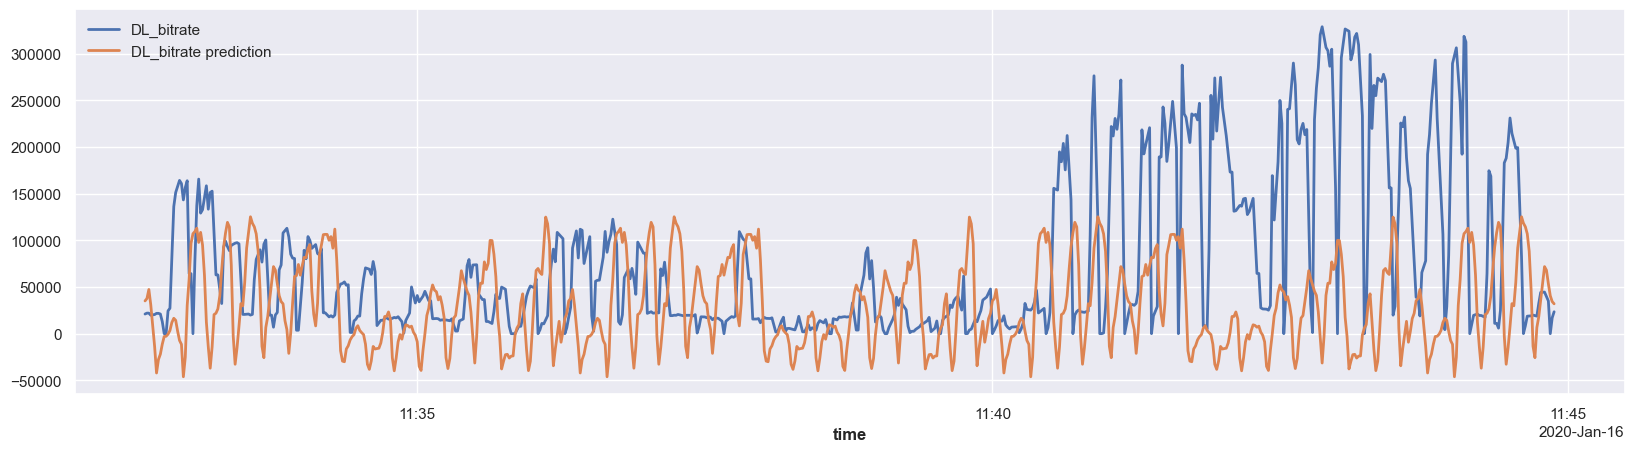

In [51]:
es_model = ExponentialSmoothing(
    seasonal=ModelMode.ADDITIVE, # experimente com "multiplicative" se fizer sentido
    trend=SeasonalityMode.NONE, 
    seasonal_periods=seasonal_periods # Período estimado pela FFT
    )

train, test = train_test_split(
    series, test_size=0.2, axis=1
)
es_model.fit(train)
print(f"AIC: {es_model.model.aic}")
y_pred = es_model.predict(len(test)).with_columns_renamed("DL_bitrate", "DL_bitrate prediction")

# print("MAPE:", mape(test, y_pred))
print("MAE:", mae(test, y_pred))
print("RMSE:", rmse(test, y_pred))

test.plot()
y_pred.plot()

### Backtest: Only Seasonal Extracted by FFT

In [52]:
series = processed_series[0]
seasonal_periods=221
forecast_horizon = 10
stride = 5

es_model = ExponentialSmoothing(
    seasonal=ModelMode.ADDITIVE, # experimente com "multiplicative" se fizer sentido
    trend=SeasonalityMode.NONE, 
    seasonal_periods=221 # Período estimado pela FFT
    )

forecast = es_model.historical_forecasts(
    series,
    start=0.8,             # ou uma timestamp, ou índice exato
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,         # ou False, dependendo do modelo
    verbose=True
)

historical forecasts:   0%|          | 0/146 [00:00<?, ?it/s]

MAE: 91510.35127234946
RMSE: 119838.8661247231


<Axes: xlabel='time'>

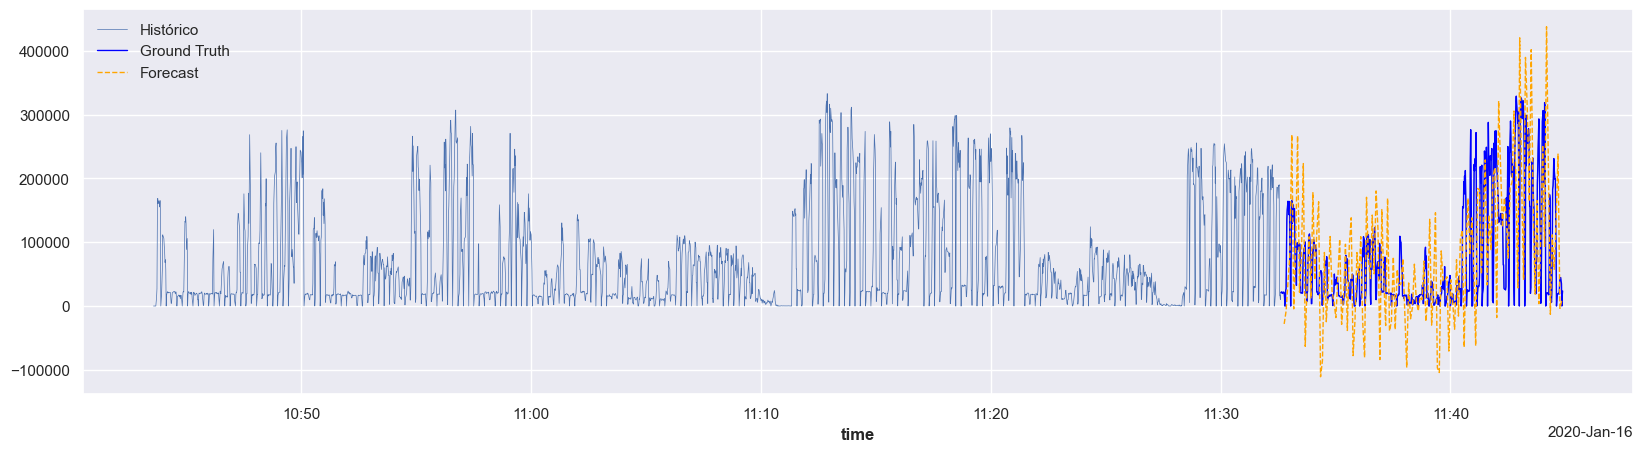

In [54]:
# Concatenar ao longo do tempo (eixo 0)
forecast_series = concatenate(forecast, axis=0)

# Interseção com ground truth
ground_truth = series.slice_intersect(forecast_series)

# Métricas
print("MAE:", mae(ground_truth, forecast_series))
print("RMSE:", rmse(ground_truth, forecast_series))
# print("MAPE:", mape(ground_truth, forecast_series))

# Plot histórico
series[:-forecast_horizon].plot(label="Histórico", lw=0.5)

# Plot Ground Truth (últimos forecast_horizon pontos reais)
test.plot(label="Ground Truth", lw=1, color="blue")

# Plot Forecast
forecast.plot(label="Forecast", lw=1, linestyle="--", color="orange")

## AutoARIMA

### No Seasonal

In [57]:
series = processed_series[0]

In [58]:
auto_arima_model = AutoARIMA(seasonal=False, stepwise=True)

train, test = train_test_split(
    series, test_size=0.2, axis=1
)
auto_arima_model.fit(train)

AutoARIMA(add_encoders=None, seasonal=False, stepwise=True)

In [59]:
auto_arima_model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2944
Model:               SARIMAX(4, 1, 3)   Log Likelihood              -35007.855
Date:                Tue, 20 May 2025   AIC                          70033.710
Time:                        22:13:48   BIC                          70087.595
Sample:                             0   HQIC                         70053.111
                               - 2944                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.3695     65.171      0.619      0.536     -87.364     168.103
ar.L1         -0.2023      0.019    -10.735      0.000      -0.239      -0.165
ar.L2          0.1096      0.014      7.702      0.000       0.082       0.137
ar.L3          0.6872      0.014     48.685      0.000       0.660       0.715
ar.L4         -0.2881      0.014    -20.721      0.000      -0.315      -0.261
ma.L1          0.3053      0.013     22.919      0.000       0.279       0.331
ma.L2         -0.2792      0.011    -25.473      0.000      -0.301      -0.258
ma.L3         -0.9443      0.012    -78.381      0.000      -0.968      -0.921
sigma2      1.314e+09   3.83e-05   3.43e+13      0.000    1.31e+09    1.31e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             13420.44
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+28. Standard errors may be unstable.
"""

MAE: 92940.88574109739
RMSE: 101778.27863339687


<Axes: xlabel='time'>

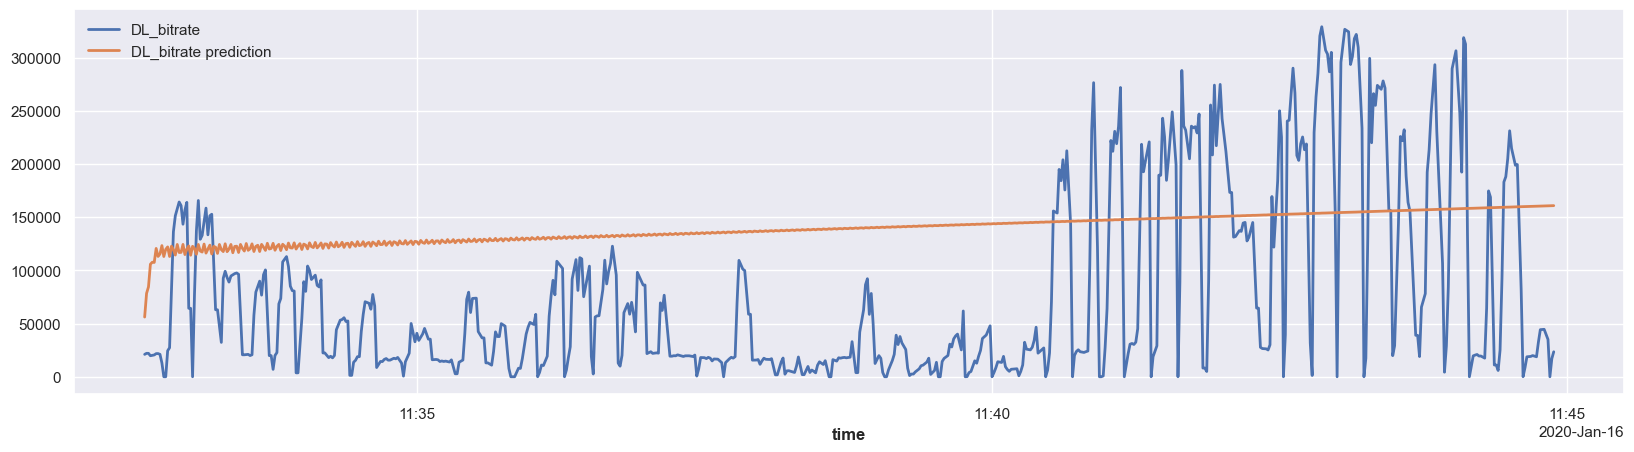

In [62]:
y_pred = auto_arima_model.predict(len(test)).with_columns_renamed("DL_bitrate", "DL_bitrate prediction")

# print("MAPE:", mape(test, y_pred))
print("MAE:", mae(test, y_pred))
print("RMSE:", rmse(test, y_pred))

test.plot()
y_pred.plot()

### AutoARIMA Backtest

In [ ]:
forecast_horizon = 10
stride = 5

auto_arima_model = AutoARIMA(seasonal=False)

forecast = auto_arima_model.historical_forecasts(
    series,
    start=0.8,             # ou uma timestamp, ou índice exato
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,         # ou False, dependendo do modelo
    verbose=True
)

historical forecasts:   0%|          | 0/146 [00:00<?, ?it/s]

MAE: 2.340348589665953
RMSE: 3.530698203127186
MAPE: 2.5639583999073663


<Axes: xlabel='time'>

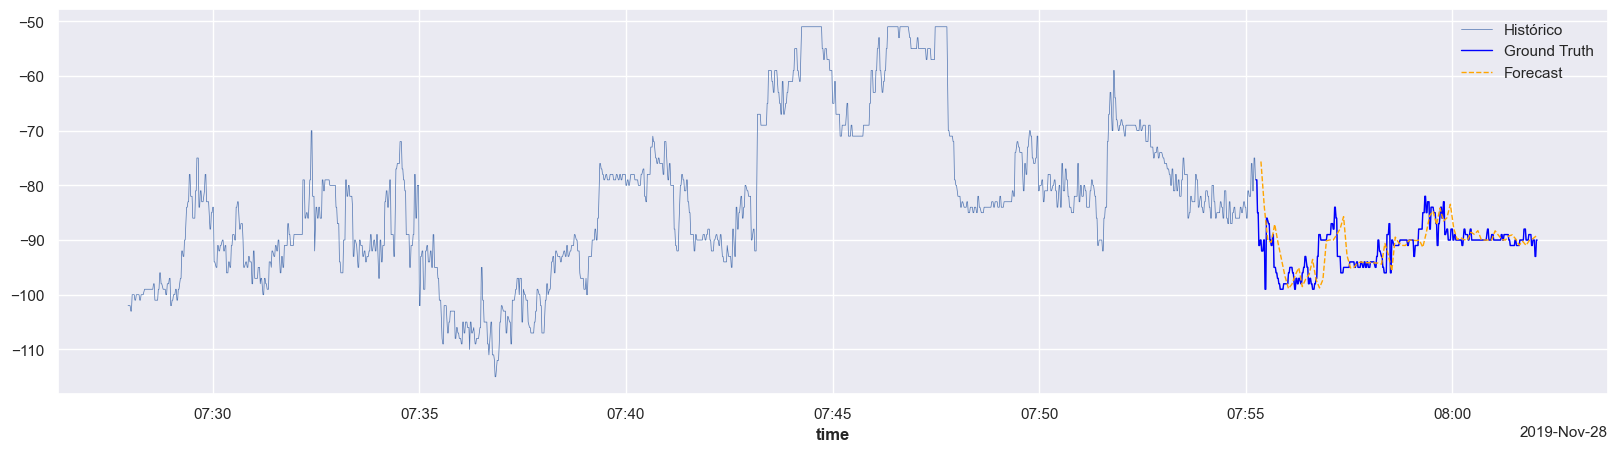

In [ ]:
# Concatenar ao longo do tempo (eixo 0)
forecast_series = concatenate(forecast, axis=0)

# Interseção com ground truth
ground_truth = series.slice_intersect(forecast_series)

# Métricas
print("MAE:", mae(ground_truth, forecast_series))
print("RMSE:", rmse(ground_truth, forecast_series))
print("MAPE:", mape(ground_truth, forecast_series))

# Plot histórico
series[:-forecast_horizon].plot(label="Histórico", lw=0.5)

# Plot Ground Truth (últimos forecast_horizon pontos reais)
test.plot(label="Ground Truth", lw=1, color="blue")

# Plot Forecast
forecast.plot(label="Forecast", lw=1, linestyle="--", color="orange")

### Seasonal

In [ ]:
auto_arima_model = AutoARIMA(seasonal=True)
series = processed_series[0]
train, test = train_test_split(
    series, test_size=0.2, axis=1
)
auto_arima_model.fit(train)

AutoARIMA(add_encoders=None, seasonal=True)

In [ ]:
forecast_horizon = 10
stride = 5

auto_arima_model = AutoARIMA(seasonal=True)

forecast = auto_arima_model.historical_forecasts(
    series,
    start=0.8,             # ou uma timestamp, ou índice exato
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=True,         # ou False, dependendo do modelo
    verbose=True
)

historical forecasts:   0%|          | 0/81 [00:00<?, ?it/s]

MAE: 2.340348589665953
RMSE: 3.530698203127186
MAPE: 2.5639583999073663


<Axes: xlabel='time'>

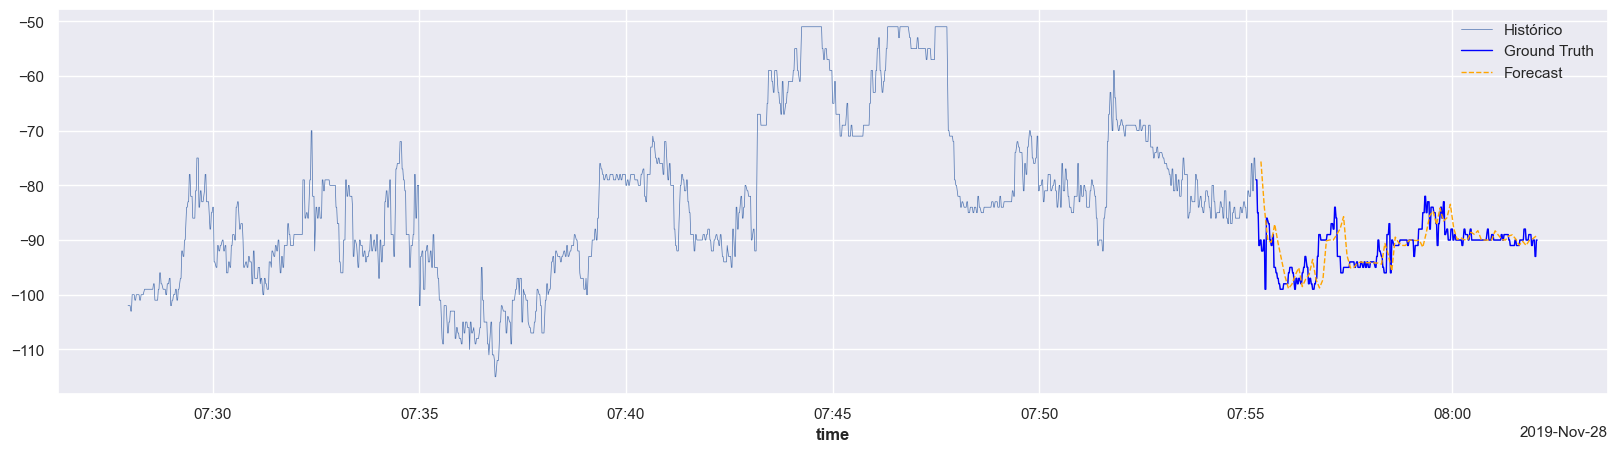

In [ ]:
# Concatenar ao longo do tempo (eixo 0)
forecast_series = concatenate(forecast, axis=0)

# Interseção com ground truth
ground_truth = series.slice_intersect(forecast_series)

# Métricas
print("MAE:", mae(ground_truth, forecast_series))
print("RMSE:", rmse(ground_truth, forecast_series))
print("MAPE:", mape(ground_truth, forecast_series))

# Plot histórico
series[:-forecast_horizon].plot(label="Histórico", lw=0.5)

# Plot Ground Truth (últimos forecast_horizon pontos reais)
test.plot(label="Ground Truth", lw=1, color="blue")

# Plot Forecast
forecast.plot(label="Forecast", lw=1, linestyle="--", color="orange")

# Machine Learning Models

## Simple RNN

In [ ]:
from darts.utils.likelihood_models import GaussianLikelihood

In [ ]:
series = processed_series[0]

# Normalizar (recomendado)
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

train, test = train_test_split(
    series_scaled, test_size=0.2, axis=1
)

# Modelo RNN (pode ser LSTM, GRU também)
model = RNNModel(
    model='GRU',
    input_chunk_length=30,
    output_chunk_length=10,
    hidden_dim=25,
    n_rnn_layers=1,
    training_length=60,
    dropout=0.0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3},
    random_state=42,
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs={"accelerator": "cpu"},  # ou "cpu" se necessário
)

# Treinar modelo
model.fit(train, verbose=True)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 2.1 K  | train
6 | V               | Linear           | 52     | train
-------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=60, input_chunk_length=30, output_chunk_length=10, batch_size=16, n_epochs=100, optimizer_kwargs={'lr': 0.001}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), pl_trainer_kwargs={'accelerator': 'cpu'})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 32.474054144502375
RMSE: 35.42412038822832
MAPE: 35.706771664680225


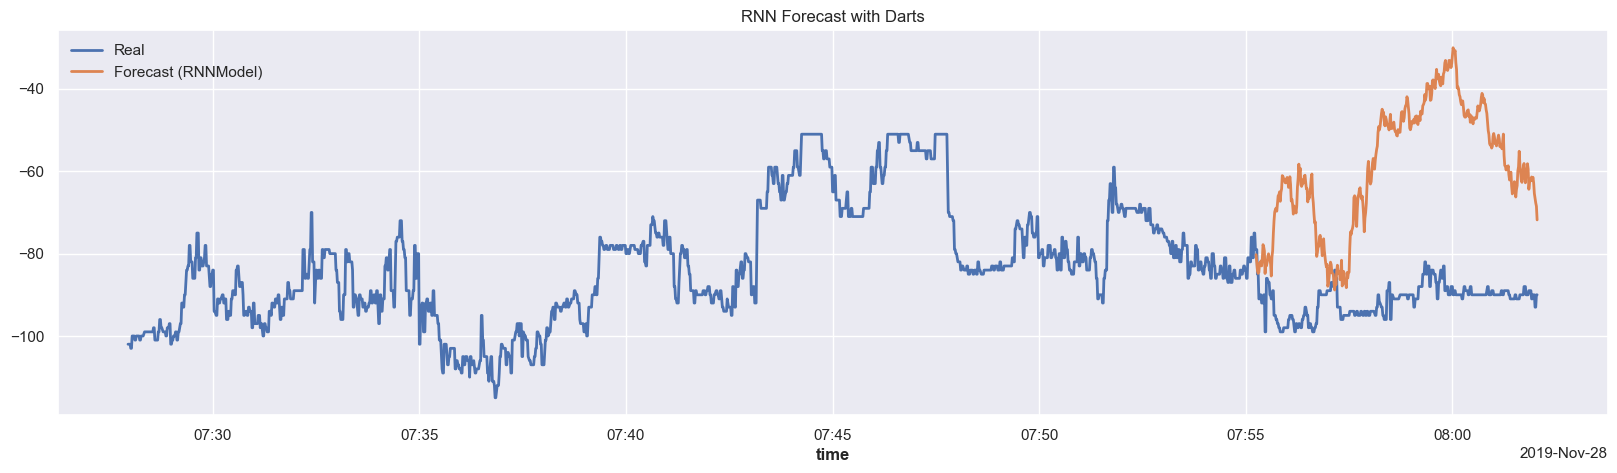

In [ ]:
# Prever
forecast = model.predict(n=len(test))

# Inverter escala
test_back = scaler.inverse_transform(test)
forecast_back = scaler.inverse_transform(forecast)
series_back = scaler.inverse_transform(series_scaled)

# Métricas
print("MAE:", mae(test_back, forecast_back))
print("RMSE:", rmse(test_back, forecast_back))
print("MAPE:", mape(test_back, forecast_back))

# Visualização
series_back.plot(label="Real")
forecast_back.plot(label="Forecast (RNNModel)")
plt.title("RNN Forecast with Darts")
plt.legend()
plt.show()

### Teste com HMM (Hidden Markov Models)

In [ ]:
from hmmlearn.hmm import GaussianHMM

In [ ]:
# Série original (Darts TimeSeries)
series = processed_series[0]

In [ ]:
# Normalizar para melhor estabilidade numérica
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

# Converter para array
y = series_scaled.values().flatten().reshape(-1, 1)

# Definir e treinar HMM
n_states = 4  # número de estados ocultos
model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(y)

Model is not converging.  Current: 2693.490512205655 is not greater than 2693.5121386352203. Delta is -0.02162642956545824


GaussianHMM(n_components=4, n_iter=1000, random_state=42)

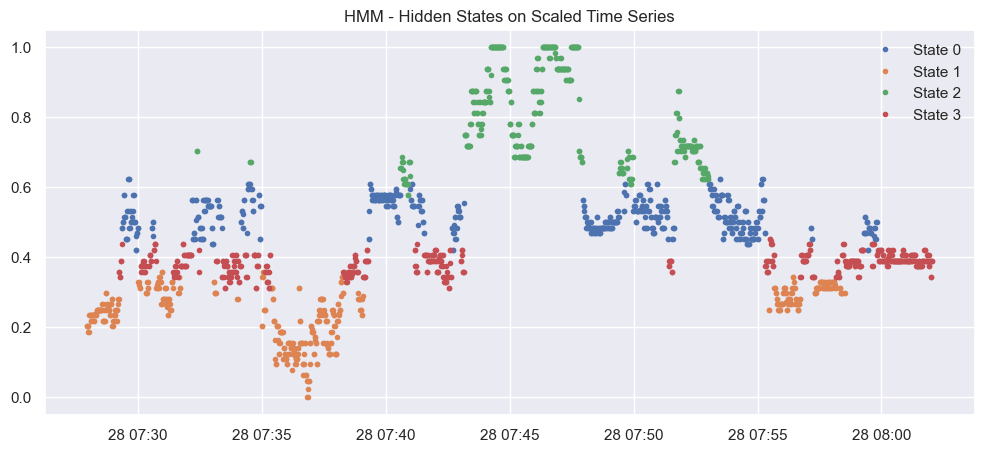

In [ ]:
# Obter estados ocultos
hidden_states = model.predict(y)

# Plotar a série com os estados ocultos
plt.figure(figsize=(12, 5))
for i in range(n_states):
    mask = hidden_states == i
    plt.plot(series.time_index[mask], y[mask], '.', label=f"State {i}")
plt.title("HMM - Hidden States on Scaled Time Series")
plt.legend()
plt.show()

# Testes